# ObsSea4Clim: In Situ Stats

This notebook allows you to explore and visualize the spatial distribution of observing platforms that were active within a selected time range.  

You can:  
- Filter the dataset by **p33 parameter** (e.g. all p33 parameters, water temperature, salinity, etc.)  
- Specify a **start year** and **end year** to focus on platforms that were active during that time.  
- Generate **annual maps** showing the locations of platforms, colored by platform type.  

### Workflow
1. **Load data**: The notebook downloads EMODnet platform metadata (including first/last observation dates).  
2. **Clean data**: Missing dates are filled from creation/update metadata where possible.  
3. **Filter by user input**: Platforms are selected if they were active in the chosen time window and measured the selected p33 parameter.  
4. **Plot maps**: For each year in the range, a map is created showing active platforms, with platform type shown by color.   

Once the inputs are set and the data downloaded, the last code cell of this notebook will generate maps for each year in the selected range, show them as output, and also save them in this Colab session. The saved map images can be accessed by clicking on the **folder icon** in the left-hand menu of this page.

## Setup

In [ ]:
%%capture
# In this cell the library cartopy is installed and all the necessary
# libraries imported.

!pip install cartopy
from datetime import datetime
from ipywidgets import widgets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
import glob

# Ignoring warnings (to keep the output of the last cell clean.
# Cartopy will otherwise show a warning when downloading the COASTLINE feature).
# To see warnings comment the two lines below
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Executing this cell will declare the variables
# needed for the execution of the following cells
# In the first three lines the default values for the Dropdowns and
# Inputs are declared. Keep in mind that each time this cell will be executed
# these variables will be reinitialized

selected_p33_parameter = "All p33 parameters"
min_year = 2024
max_year = datetime.now().year

emod_platform_types_dict = [
    {"platform_types": "Argo/Profiler", "colors": "pink"},
    {"platform_types": "Drifting Buoys", "colors": "green"},
    {"platform_types": "Argo BGC", "colors": "magenta"},
    {"platform_types": "River Station", "colors": "saddlebrown"},
    {"platform_types": "Fishing Vessels", "colors": "orange"},
    {"platform_types": "Bottle Data", "colors": "darkblue"},
    {"platform_types": "Sea Mammals", "colors": "forestgreen"},
    {"platform_types": "Gliders", "colors": "yellow"},
    {"platform_types": "XBT or XCTD Profiles", "colors": "blue"},
    {"platform_types": "Tide Gauge", "colors": "lime"},
    {"platform_types": "Mooring", "colors": "red"},
    {"platform_types": "Thermosalinographers", "colors": "black"},
    {"platform_types": "ADCP", "colors": "lightcoral"},
    {"platform_types": "Weather Station", "colors": "powderblue"},
    {"platform_types": "Mini Logger", "colors": "cyan"},
    {"platform_types": "Not yet identified", "colors": "lightgray"},
    {"platform_types": "Saildrone", "colors": "lightsalmon"},
    {"platform_types": "Thermistor Chain Data", "colors": "olivedrab"},
    {"platform_types": "Ferrybox/Ship", "colors": "deeppink"},
    {"platform_types": "HF Radar Radial", "colors": "peru"},
    {"platform_types": "HF Radar Total", "colors": "saddlebrown"},
    {"platform_types": "Vessel Mounted ADCP", "colors": "black"},
    {"platform_types": "Autonomous Vehicle", "colors": "darkorange"},
    {"platform_types": "Voluntary Observing Ships", "colors": "silver"},
    {"platform_types": "CTD Profiles", "colors": "cornflowerblue"},
]

csv_query_variables = [
'PLATFORMCODE',
'call_name',
'latitude',
'longitude',
'datafeaturetype',
'firstdateobservation',
'lastdateobservation',
'p33_watertemperature',
'p33_currents',
'p33_optical',
'p33_river',
'p33_sealevel',
'p33_waves',
'p33_winds',
'p33_biochemical',
'p33_carbonsystem',
'p33_dissolvedoxygen',
'p33_seaice',
'p33_underwatersound',
'p33_watersalinity',
'p33_meteorological',
'dataownername',
'dataownercountryname',
'dataassemblycenter',
'platformtypecode',
'platformtypedescription',
'integrator_id',
'ingestion',
'official_repository',
'creationdate',
'updatedate',
'datafiles',
'integrator',
'availabledates',
'seaBasinsNames',
'seaBasinsEuropeNames',
'best_practices_doi',
'data_doi'
]

p33_parameters = [
"p33_watertemperature",
"p33_currents",
"p33_optical",
"p33_river",
"p33_sealevel",
"p33_waves",
"p33_winds",
"p33_biochemical",
"p33_carbonsystem",
"p33_dissolvedoxygen",
"p33_watersalinity",
"p33_meteorological"
]

crs_dict = {
    "Plate Carree": ccrs.PlateCarree(),
    "South Polar Stereo": ccrs.SouthPolarStereo(),
    "North Polar Stereo": ccrs.NorthPolarStereo()
}

In [ ]:
# Here the three main functions will be declared
# The first will be used to download the csv files from the URL
# and return a pandas DataFrame;
# the second one generates a map plot for a year and
# the third one is a data cleaning function

def load_points(csv_url):
    print("Downloading csv from:", csv_url)
    try:
        points_df = pd.read_csv(csv_url, skiprows=[1])
        print("Successfully loaded data")
        print("DataFrame has length:", len(points_df))
        return points_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()


def plot_map(map_point, title, crs_value, chunk_size=50000):
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, zorder=1)
    ax.set_extent([-180, 180, -90, 90], crs=crs_value)

    grouped = map_point.groupby("platformtypedescription")

    for ptype, group in grouped:
        color = platform_color_map.get(ptype, "blue")

        if len(group) > chunk_size:
            for i in range(0, len(group), chunk_size):
                chunk = group.iloc[i : i + chunk_size]
                ax.scatter(
                    chunk["longitude"],
                    chunk["latitude"],
                    s=2,
                    c=color,
                    transform=ccrs.PlateCarree(),
                    zorder=2
                )
        else:
            ax.scatter(
                group["longitude"],
                group["latitude"],
                s=2,
                c=color,
                transform=ccrs.PlateCarree(),
            )

    legend_handles = [
        mpatches.Patch(color=color, label=ptype)
        for ptype, color in platform_color_map.items()
    ]

    ax.legend(
        handles=legend_handles,
        fontsize=8,
        frameon=False,
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )

    ax.tick_params(color="white", axis="both", labelcolor="white")

    try:
        plt.title(title, fontsize=8)
        plt.savefig(str(title + "_map.png"), bbox_inches="tight", dpi=300)
    except Exception as e:
        print("Error saving map", title, e)

    plt.show()
    return fig


def force_emodnet_points(df):
    # Convert the 'firstdateobservation', 'lastdateobservation', 'creationdate', and 'updatedate' columns to datetime objects
    df['lastdateobservation'] = pd.to_datetime(df['lastdateobservation'])
    df['creationdate'] = pd.to_datetime(df['creationdate'])
    df['updatedate'] = pd.to_datetime(df['updatedate'])

    df['firstdateobservation'] = pd.to_datetime(df['firstdateobservation'], errors='coerce')

    df['firstdateobservation'] = df.apply(
        lambda row: row['lastdateobservation'] if pd.isna(row['firstdateobservation']) and pd.notna(row['lastdateobservation']) else row['firstdateobservation'],
        axis=1
        )

        # if emodnet_points['lastdateobservation'] is empty and emodnet_points['firstdateobservation'] has value
    df['lastdateobservation'] = df.apply(
            lambda row: row['firstdateobservation'] if pd.isna(row['lastdateobservation']) and pd.notna(row['firstdateobservation']) else row['lastdateobservation'],
            axis=1
        )

        # this cleans the remaining
    df['firstdateobservation'] = df.apply(
            lambda row: row['creationdate'] if pd.isna(row['firstdateobservation']) and pd.notna(row['creationdate']) else row['firstdateobservation'],
            axis=1
        )

    df['lastdateobservation'] = df.apply(
            lambda row: row['creationdate'] if pd.isna(row['lastdateobservation']) and pd.notna(row['creationdate']) else row['lastdateobservation'],
            axis=1
        )

    return df

## Download the data

In [ ]:
# Generating three Dropdowns, the first will allow the user to select
# a p33 parameter group (default value: "All p33 parameters");
# the second and third will generate Text Inputs for the selection of a
# timerange

p33_dropdown = widgets.Dropdown(
    options=[selected_p33_parameter] + p33_parameters,
    value=selected_p33_parameter,
    description="p33 filter:"
)

min_year_input = widgets.IntText(
    value=min_year,
    description="Start year:"
)
max_year_input = widgets.IntText(
    value=max_year,
    description="End year:"
)

display(p33_dropdown, min_year_input, max_year_input)

Dropdown(description='p33 filter:', options=('All p33 parameters', 'p33_watertemperature', 'p33_currents', 'p3…

IntText(value=2024, description='Start year:')

IntText(value=2025, description='End year:')

In [ ]:
# This cell will generate the URLs to make the requests to EMODnet physics'
# ERDDAP and download the metadata in .csv format
# This data will then be loaded into a Pandas DataFrame

selected_p33_parameter = p33_dropdown.value
min_year = min_year_input.value
max_year = max_year_input.value

csv_url = 'https://data-erddap.emodnet-physics.eu/erddap/tabledap/EP_PLATFORMS_METADATA_V2.csv?'
csv_url += '%2C'.join(csv_query_variables)
if selected_p33_parameter != "All p33 parameters":
  csv_url += f"&{selected_p33_parameter}=1"
csv_url += f"&firstdateobservation%3C={max_year}-12-31T23:59:59Z"
csv_url += f"&lastdateobservation%3E={min_year}-01-01T00:00:00Z"

csv_url_ctd = 'https://data-erddap.emodnet-physics.eu/erddap/tabledap/EP_PLATFORMS_METADATA_CTD_V2.csv?'
csv_url_ctd += '%2C'.join(csv_query_variables)
if selected_p33_parameter != "All p33 parameters":
  csv_url_ctd += f"&{selected_p33_parameter}=1"
csv_url_ctd += f"&firstdateobservation%3C={max_year}-12-31T23:59:59Z"
csv_url_ctd += f"&lastdateobservation%3E={min_year}-01-01T00:00:00Z"

print(f"Downloading the csv files...")
print(f"Applied filters:\n\tp33_parameter: {selected_p33_parameter}\n\tMinimum year: {min_year}\n\tMaximum year: {max_year}\n")
subset = pd.concat([load_points(csv_url), load_points(csv_url_ctd)], ignore_index=True)
print("Cleaning data...")
data_df = force_emodnet_points(subset)
if not data_df.empty:
  print("\nDone. Data is ready to be used")
else:
  print("\nNo data. Please try changing the filters")

  #added
emodnet_points = data_df.copy()

Applied filters:
	p33_parameter: p33_watertemperature
	Minimum year: 2000
	Maximum year: 2001

Successfully loaded data
DataFrame has length: 1181
Successfully loaded data
DataFrame has length: 52040
Cleaning data...

Done. Data is ready to be used


In [ ]:
# Preview the first rows of the dataset
display(data_df.head())

PLATFORMCODE call_name  latitude  longitude datafeaturetype  \
0         SK02      SK02    42.120    -70.400         profile   
1         DMF2      DMF2    41.950    -70.490         profile   
2         MJ08      MJ08    40.290    -68.280         profile   
3        44007     44007    43.531    -70.144      timeseries   
4        46002     46002    42.570   -130.460      timeseries   

       firstdateobservation       lastdateobservation  p33_watertemperature  \
0 2001-09-27 22:58:00+00:00 2001-11-10 10:58:00+00:00                     1   
1 1987-12-15 18:00:00+00:00 2015-11-25 17:11:00+00:00                     1   
2 2000-08-19 04:00:00+00:00 2000-11-19 11:00:00+00:00                     1   
3 1982-02-16 23:00:00+00:00 2025-10-26 04:20:00+00:00                     1   
4 1975-07-17 02:00:00+00:00 2023-09-24 11:00:00+00:00                     1   

   p33_currents  p33_optical  ...  official_repository  \
0             0            0  ...                    1   
1             0            0  ...                    1   
2             0            0  ...                    1   
3             0            0  ...                    1   
4             0            0  ...                    1   

               creationdate                updatedate  \
0 2023-08-24 10:05:14+00:00 2025-10-03 06:00:50+00:00   
1 2023-08-24 10:41:49+00:00 2025-10-03 06:01:04+00:00   
2 2023-08-24 10:45:37+00:00 2025-10-03 06:01:34+00:00   
3 2024-02-02 04:21:26+00:00 2025-10-26 04:48:30+00:00   
4 2024-02-02 04:05:34+00:00 2025-10-03 07:04:31+00:00   

                                           datafiles       integrator  \
0  https://erddap.emodnet-physics.eu/erddap/table...  emolthistorical   
1  https://erddap.emodnet-physics.eu/erddap/table...  emolthistorical   
2  https://erddap.emodnet-physics.eu/erddap/table...  emolthistorical   
3  https://erddap.emodnet-physics.eu/erddap/table...             ndbc   
4  https://erddap.emodnet-physics.eu/erddap/table...             ndbc   

                                      availabledates  seaBasinsNames  \
0                        [09-2001, 10-2001, 11-2001]             NaN   
1  [02-1992, 06-2010, 08-1996, 12-2010, 01-2001, ...             NaN   
2               [09-2000, 11-2000, 08-2000, 10-2000]             NaN   
3  [01-1986, 04-1996, 06-1996, 01-1988, 07-1986, ...             NaN   
4  [12-1990, 01-1985, 12-1992, 03-2023, 11-2004, ...             NaN   

   seaBasinsEuropeNames                                 best_practices_doi  \
0                   NaN                                                NaN   
1                   NaN                                                NaN   
2                   NaN                                                NaN   
3                   NaN  https://atlantos-h2020.eu/download/7.2-QC-Repo...   
4                   NaN  https://atlantos-h2020.eu/download/7.2-QC-Repo...   

   data_doi  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

[5 rows x 38 columns]

In [ ]:
# N of platform present
platform_type_counts = data_df['platformtypedescription'].value_counts()

print("Platform type counts:")
print(platform_type_counts)

Platform type counts:
platformtypedescription
CTD Profiles            52040
XBT or XCTD Profiles      602
Argo/Profiler             351
Mooring                   137
Mini Logger                84
River Station               6
Drifting Buoys              1
Name: count, dtype: int64


## Plot the maps

In [ ]:
# This cell will create and show a Dropdown that will allow the user to select
# a CRS that will be used when generating the map plots

selected_crs = list(crs_dict.keys())[0]

crs_dropdown = widgets.Dropdown(
    options=list(crs_dict.keys()),
    value=selected_crs,
    description="Select a crs:"
)

display(crs_dropdown)

Dropdown(description='Select a crs:', options=('Plate Carree', 'South Polar Stereo', 'North Polar Stereo'), va…

Generating plot for year 2000...


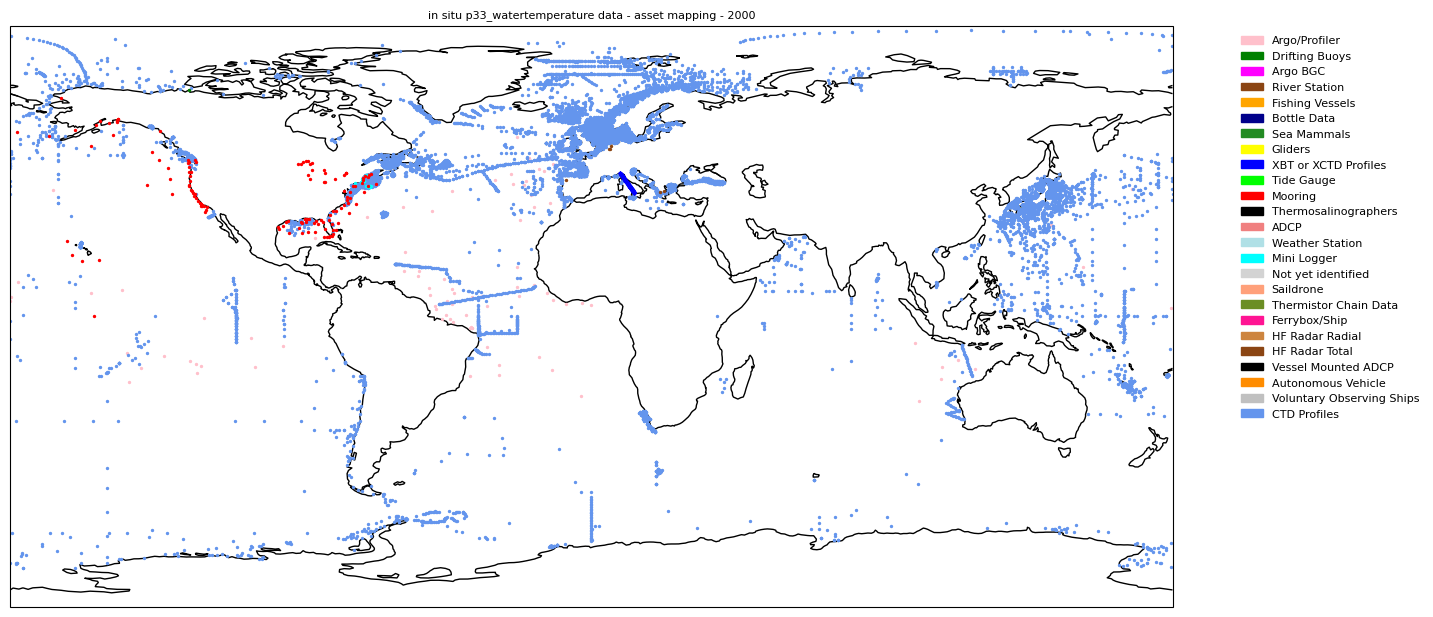

Generating plot for year 2001...


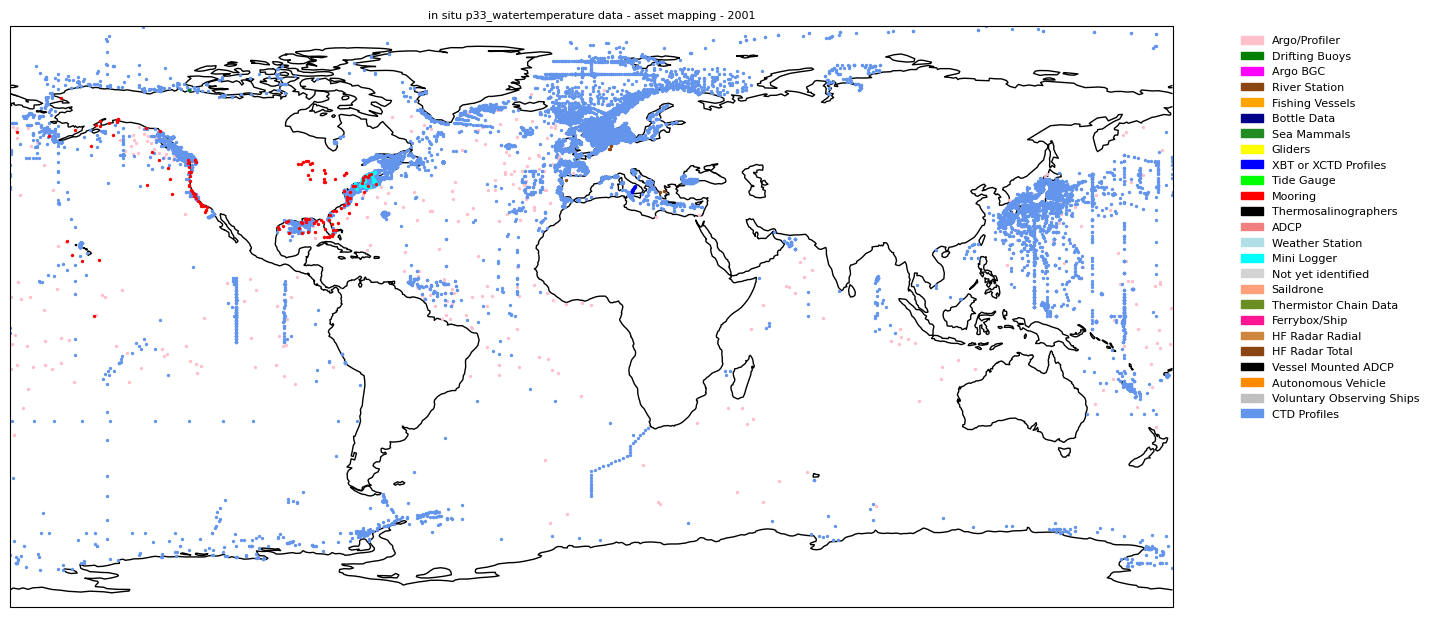

In [ ]:
# This cell will plot a map for each of the selected years.
# Each map will be also saved in this Colab's folder

years = range(min_year, max_year + 1)
crs_value = [v for k, v in crs_dict.items() if k == crs_dropdown.value][0]
platform_color_map = {
    d["platform_types"]: d["colors"] for d in emod_platform_types_dict
}

for year in years:
    print(f"Generating plot for year {year}...")
    if selected_p33_parameter != "All p33 parameters":
      subset_filtered = data_df[
          (data_df['firstdateobservation'].dt.year <= year) &
          (data_df['lastdateobservation'].dt.year >= year) &
          (data_df[selected_p33_parameter] == 1)
      ]
    else:
      subset_filtered = data_df[
          (data_df['firstdateobservation'].dt.year <= year) &
          (data_df['lastdateobservation'].dt.year >= year)
      ]
    plot_map(subset_filtered, f"in situ {selected_p33_parameter.lower()} data - asset mapping - {year}", crs_value)

## Generate an animation with the plots

In [ ]:
frames = sorted(glob.glob("*_map.png"))

# open all images
images = [Image.open(f) for f in frames]

images[0].save(
    "animation.gif",
    save_all=True,
    append_images=images[1:],
    duration=1000,   # duration of each frame (800 ms = 0.8s)
    loop=0          # 0 = infinite loop
)

print("GIF saved as animation.gif")


GIF saved as animation.gif



#  **Provider** pie chart e PDF

These cells create **pie charts for each provider** (field `dataownername`)
showing the distribution of `platformtypedescription`, save individual **PNGs**, and:

- one **png per provider** (`provider_<slug>.pdf`)

- one **cumulative PDF** with all the pie charts (`all_owners_pie_charts.pdf`).

Assumed that the data is in the DataFrame `emodnet_points` with the columns `dataownername` and `platformtypedescription` already populated.

## Setup

In [ ]:
# In this cell the library reportlab is installed and all the necessary
# libraries imported.
!pip install reportlab
import os, re, glob
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image as RLImage, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import cm
from PIL import Image as PILImage
from datetime import datetime
import textwrap

In [ ]:
# Convert text into a safe string for filenames:
# - lowercase, strip spaces
# - replace non-alphanumeric chars with "-"
# - collapse multiple "-" and remove at ends
# - fallback to "unknown" if empty

def slugify(text):
    text = str(text).strip().lower()
    text = re.sub(r"[^a-z0-9]+", "-", text)
    return re.sub(r"-+", "-", text).strip("-") or "unknown"

if 'emodnet_points' not in globals():
    raise NameError("DataFrame 'emodnet_points' not found. Make sure you created it earlier.")

# define required columns
req_cols = {'dataownername', 'platformtypedescription'}

missing = req_cols - set(map(str.lower, emodnet_points.columns))
colmap = {c.lower(): c for c in emodnet_points.columns}
if missing:
    raise KeyError(f"Missing required columns: {missing}. Present: {list(emodnet_points.columns)}")

owner_col = colmap['dataownername']
ptype_col = colmap['platformtypedescription']

pivot_table = emodnet_points.pivot_table(
    index=owner_col, columns=ptype_col, aggfunc='size', fill_value=0
).sort_index()

pivot_csv = "pivot_table_provider_platforms.csv"
pivot_table.to_csv(pivot_csv)
print(f"Pivot saved: {pivot_csv}  (rows={pivot_table.shape[0]}, cols={pivot_table.shape[1]})")

out_dir = "provider_pies"
os.makedirs(out_dir, exist_ok=True)

Pivot saved: pivot_table_provider_platforms.csv  (rows=234, cols=18)


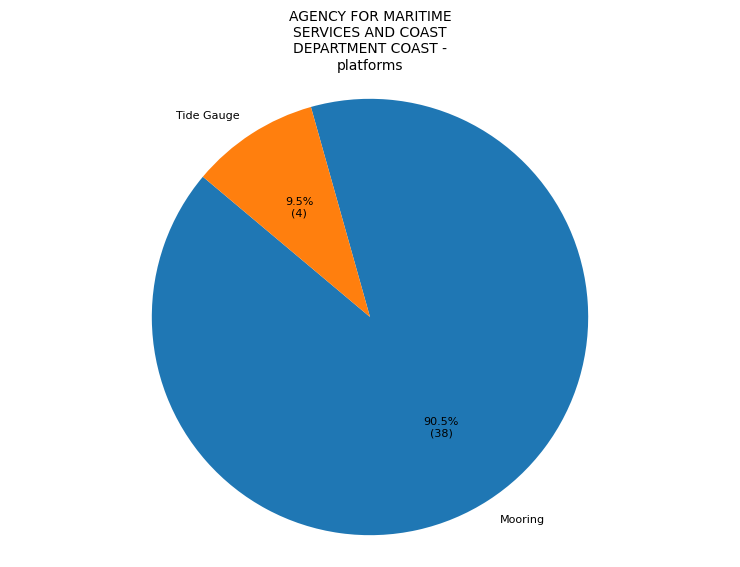

Saved: provider_pies/pie_agency-for-maritime-services-and-coast-department-coast.png


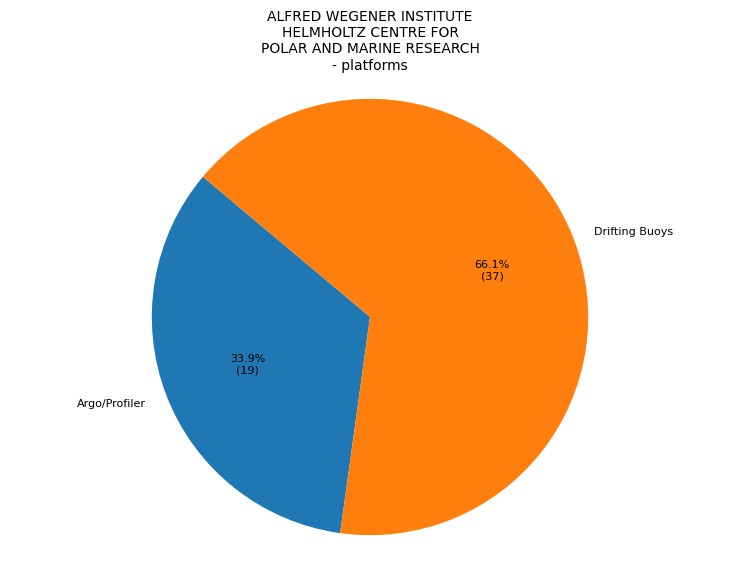

Saved: provider_pies/pie_alfred-wegener-institute-helmholtz-centre-for-polar-and-marine-research.png


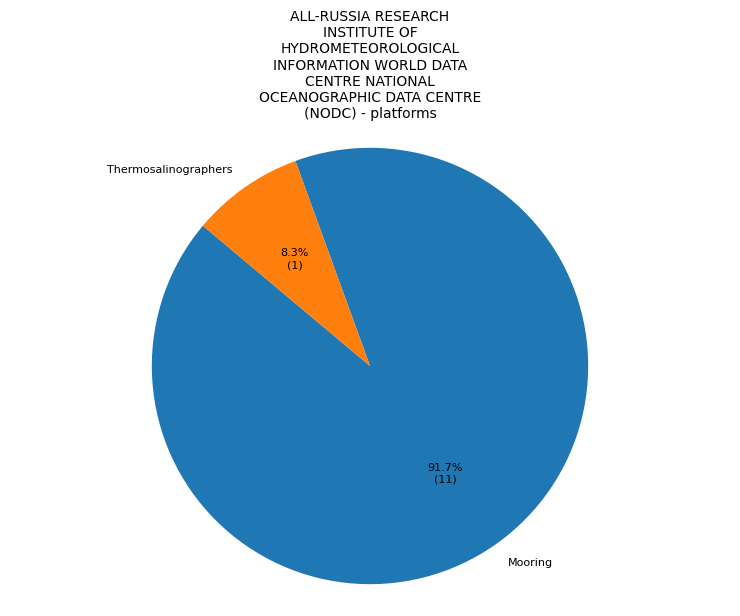

Saved: provider_pies/pie_all-russia-research-institute-of-hydrometeorological-information-world-data-centre-national-oceanographic-data-centre-nodc.png


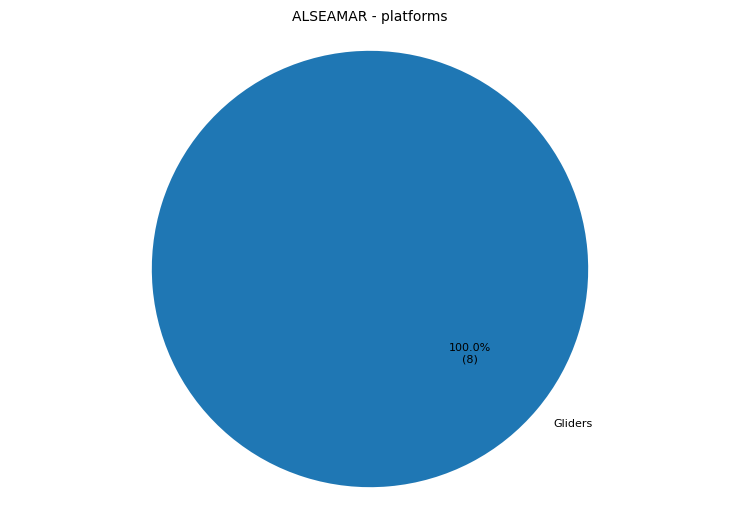

Saved: provider_pies/pie_alseamar.png


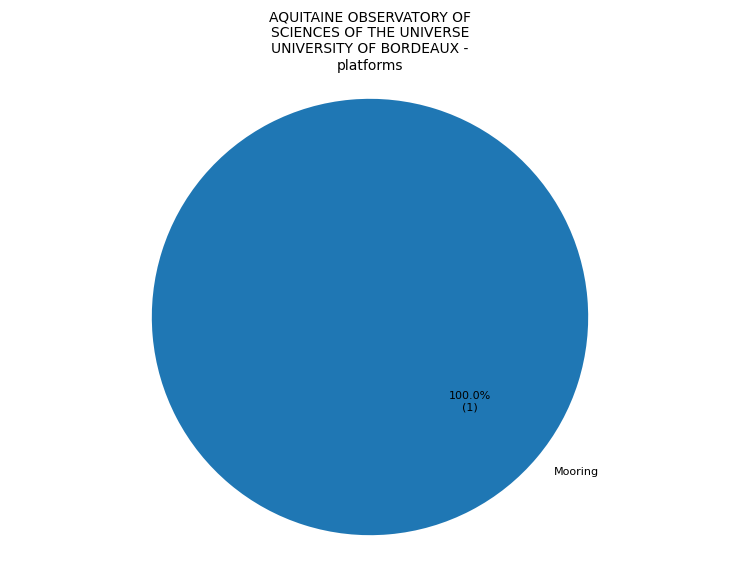

Saved: provider_pies/pie_aquitaine-observatory-of-sciences-of-the-universe-university-of-bordeaux.png


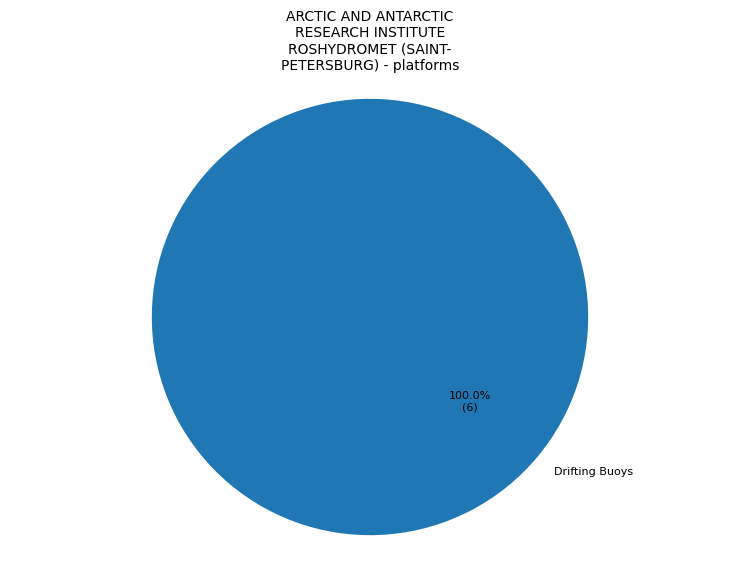

Saved: provider_pies/pie_arctic-and-antarctic-research-institute-roshydromet-saint-petersburg.png


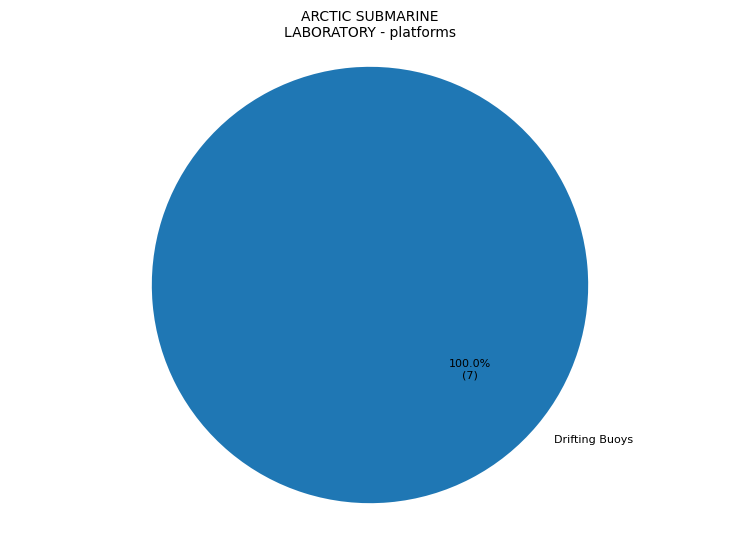

Saved: provider_pies/pie_arctic-submarine-laboratory.png


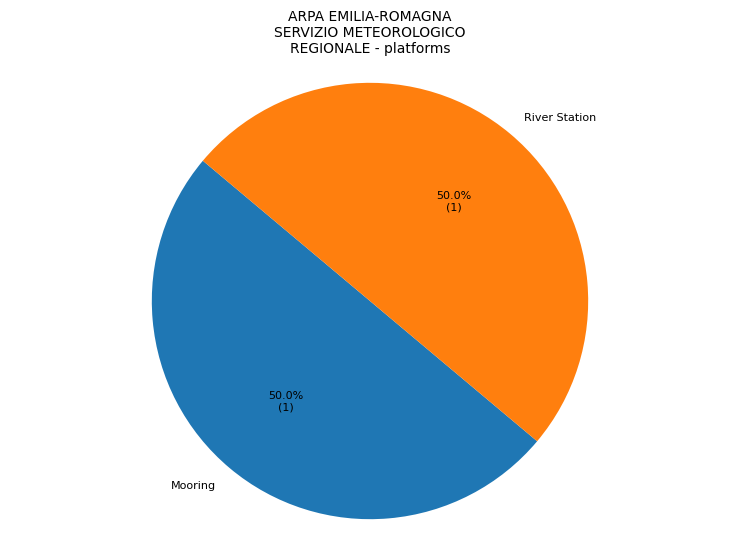

Saved: provider_pies/pie_arpa-emilia-romagna-servizio-meteorologico-regionale.png


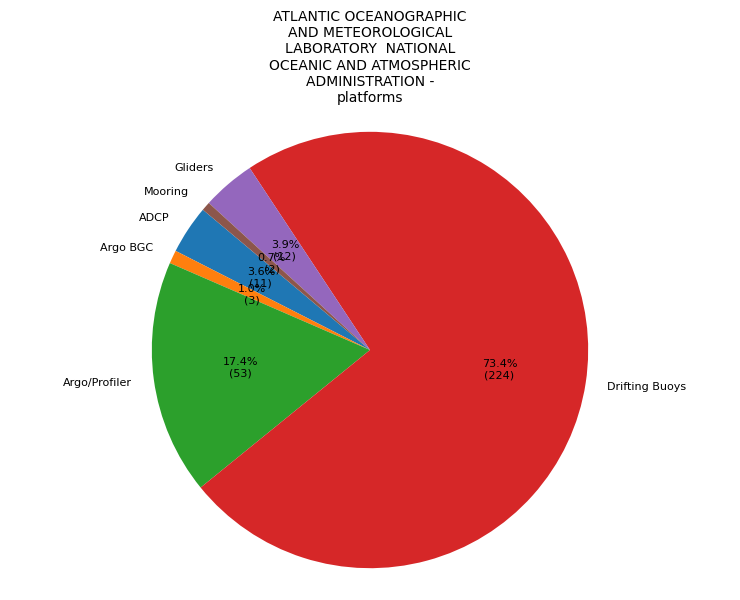

Saved: provider_pies/pie_atlantic-oceanographic-and-meteorological-laboratory-national-oceanic-and-atmospheric-administration.png


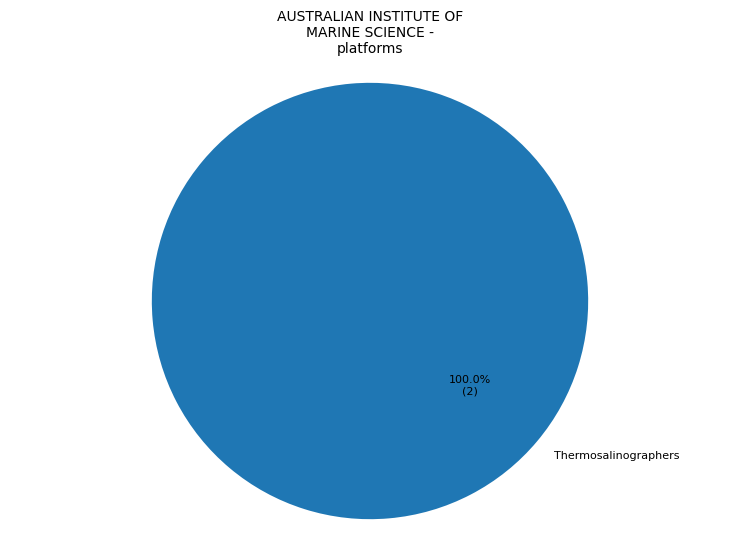

Saved: provider_pies/pie_australian-institute-of-marine-science.png


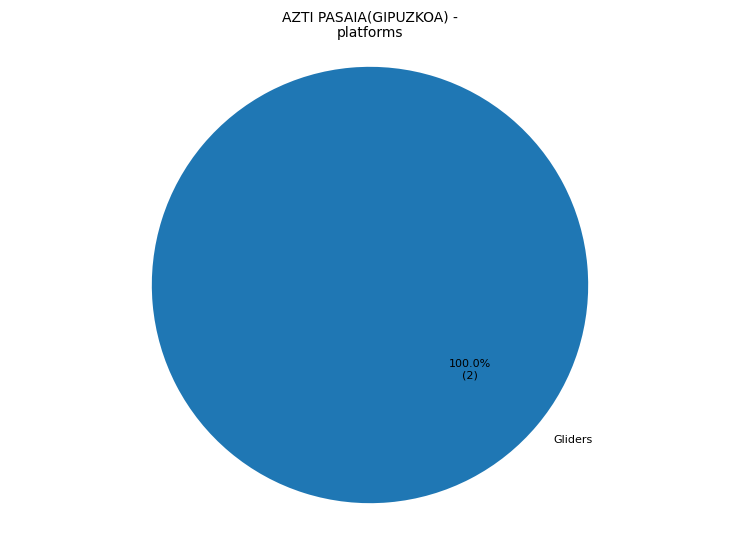

Saved: provider_pies/pie_azti-pasaia-gipuzkoa.png


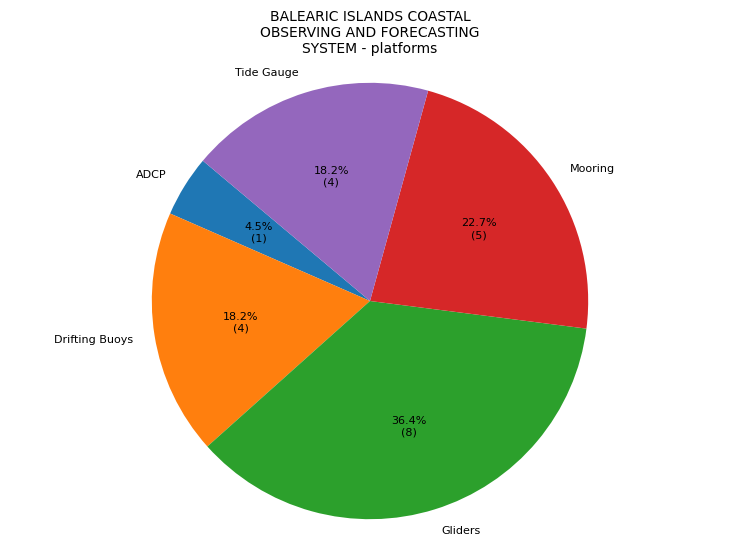

Saved: provider_pies/pie_balearic-islands-coastal-observing-and-forecasting-system.png


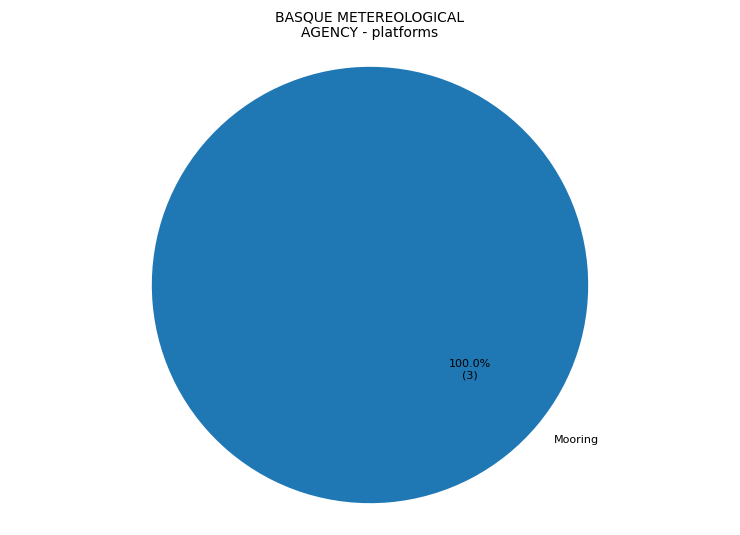

Saved: provider_pies/pie_basque-metereological-agency.png


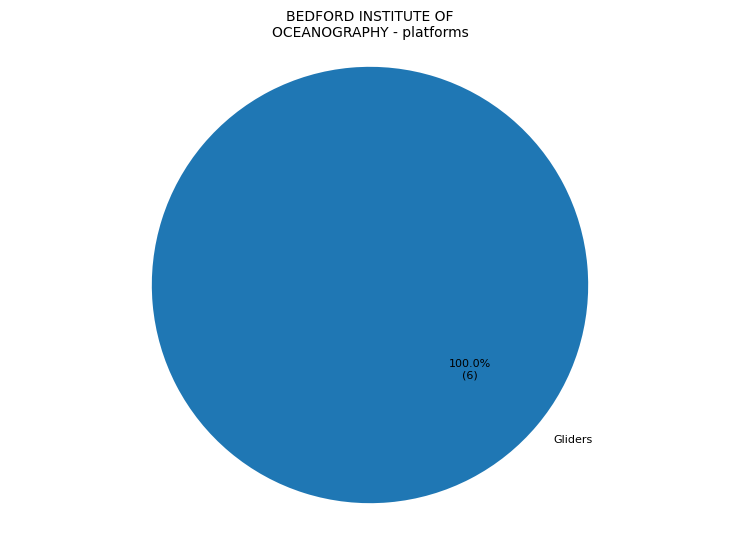

Saved: provider_pies/pie_bedford-institute-of-oceanography.png


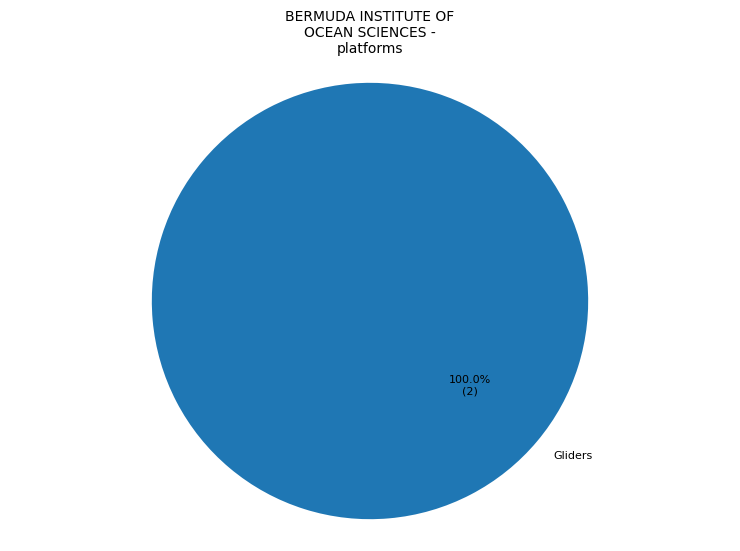

Saved: provider_pies/pie_bermuda-institute-of-ocean-sciences.png


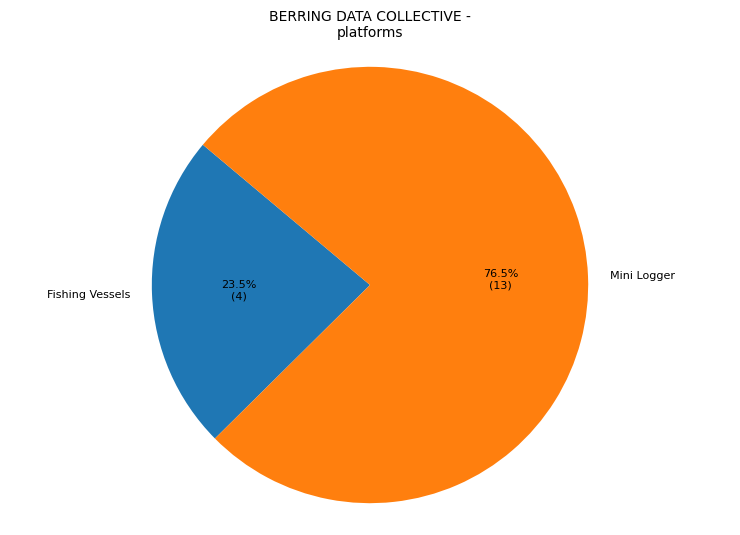

Saved: provider_pies/pie_berring-data-collective.png


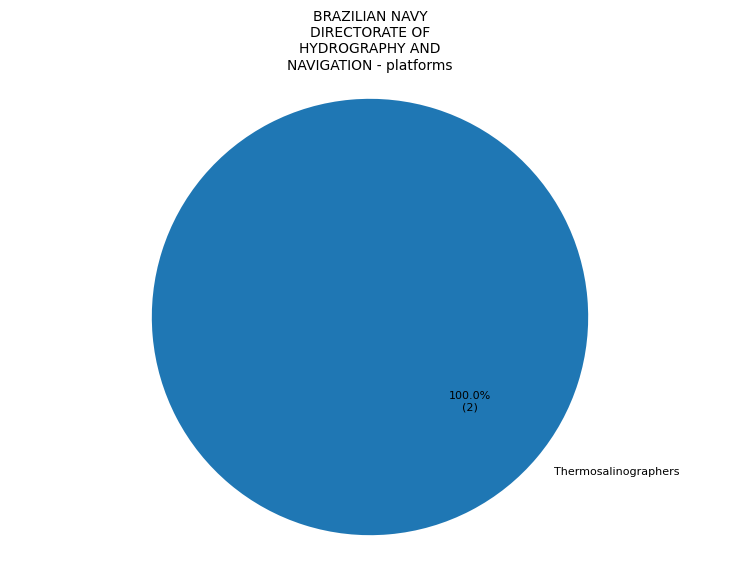

Saved: provider_pies/pie_brazilian-navy-directorate-of-hydrography-and-navigation.png


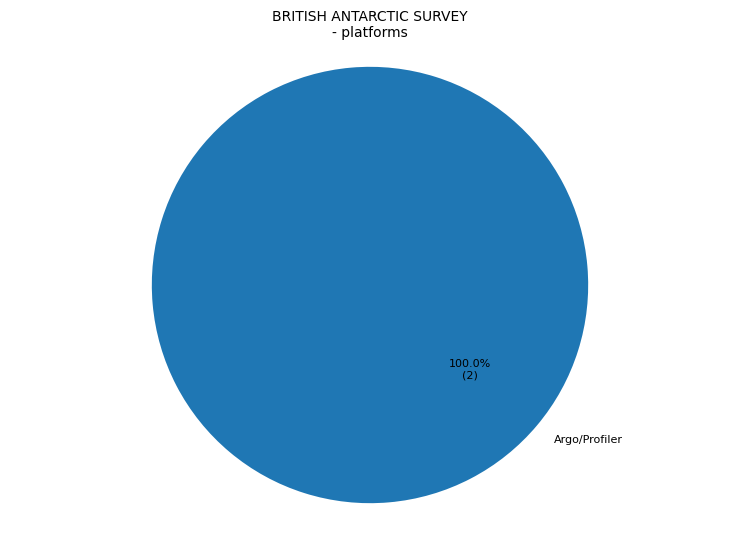

Saved: provider_pies/pie_british-antarctic-survey.png


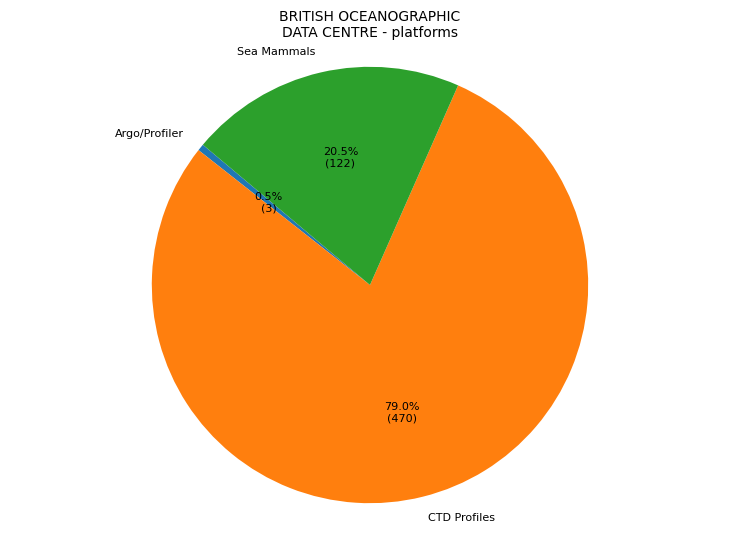

Saved: provider_pies/pie_british-oceanographic-data-centre.png


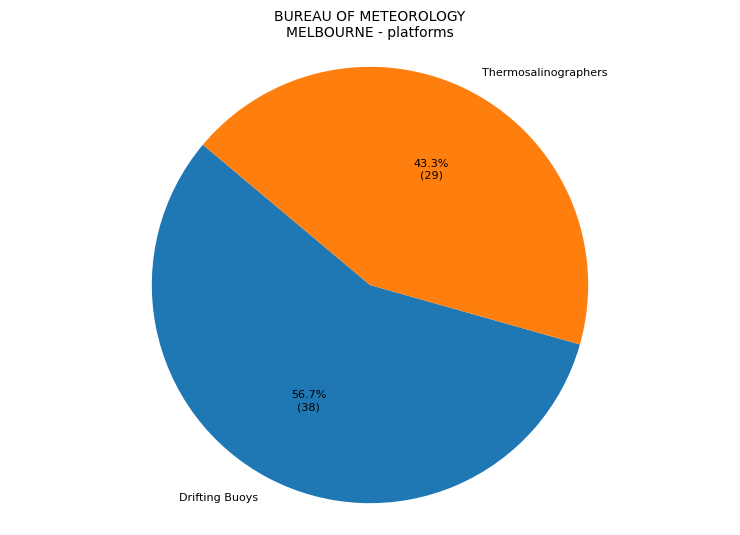

Saved: provider_pies/pie_bureau-of-meteorology-melbourne.png


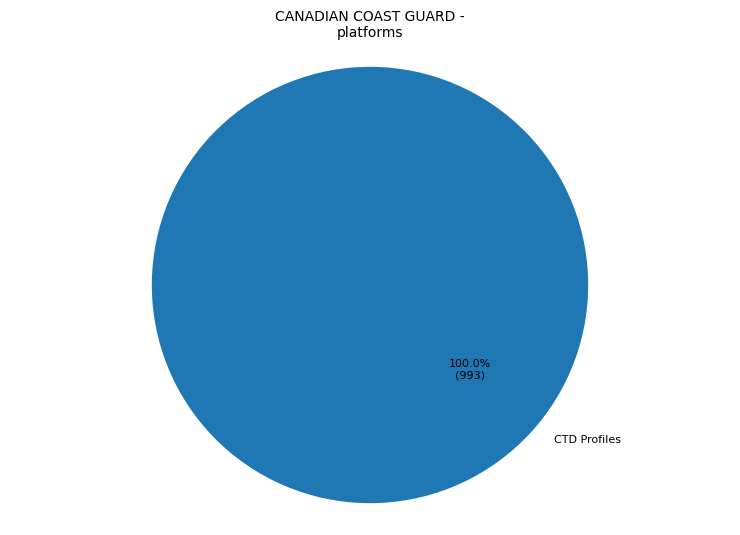

Saved: provider_pies/pie_canadian-coast-guard.png


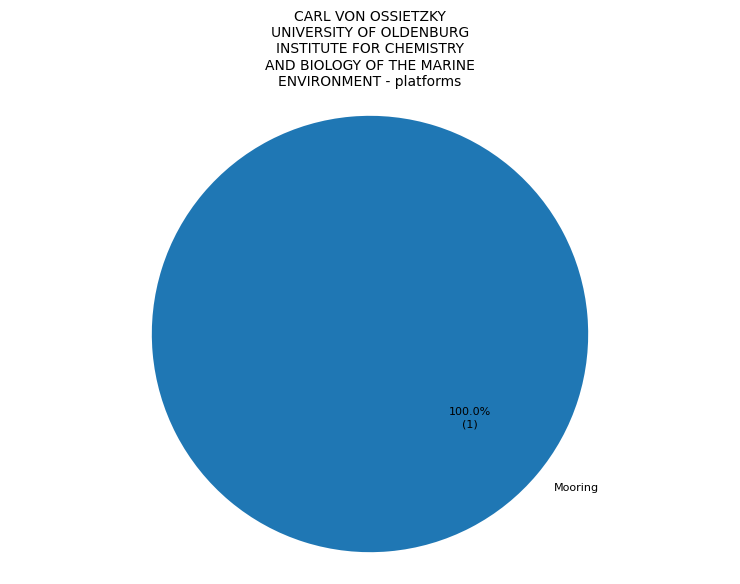

Saved: provider_pies/pie_carl-von-ossietzky-university-of-oldenburg-institute-for-chemistry-and-biology-of-the-marine-environment.png


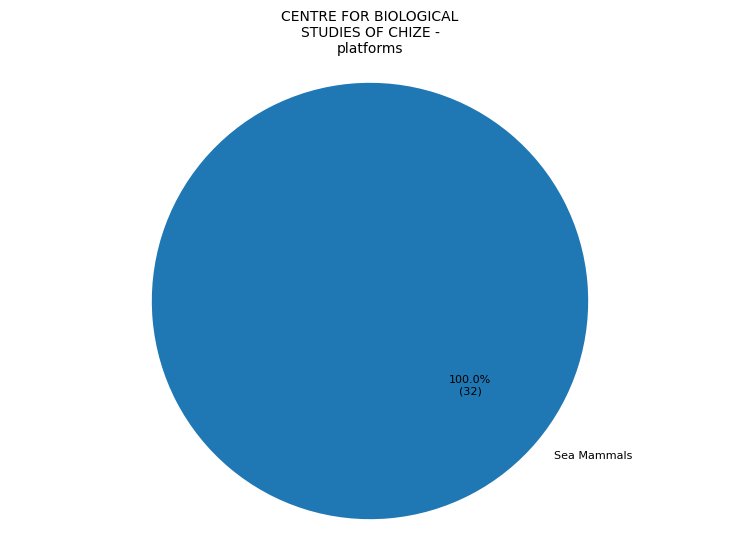

Saved: provider_pies/pie_centre-for-biological-studies-of-chize.png


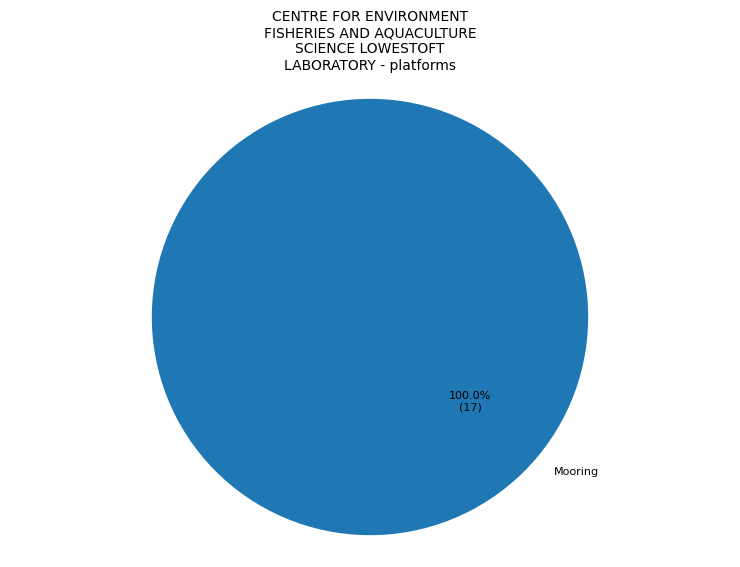

Saved: provider_pies/pie_centre-for-environment-fisheries-and-aquaculture-science-lowestoft-laboratory.png


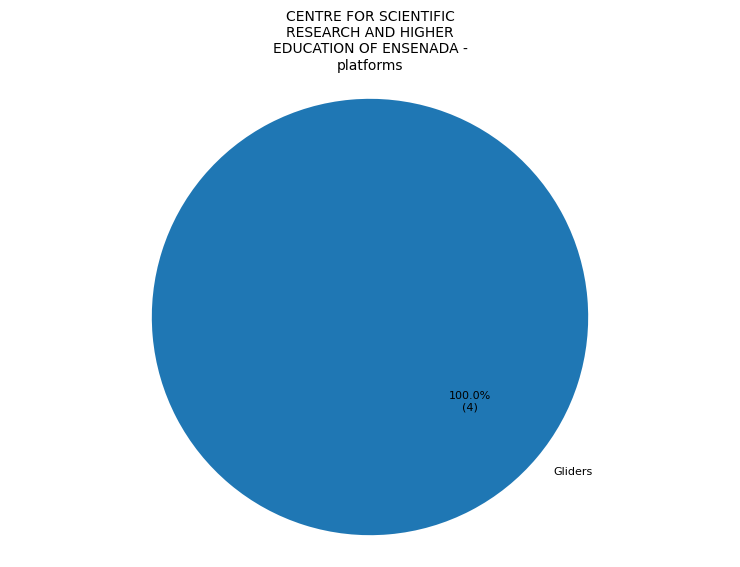

Saved: provider_pies/pie_centre-for-scientific-research-and-higher-education-of-ensenada.png


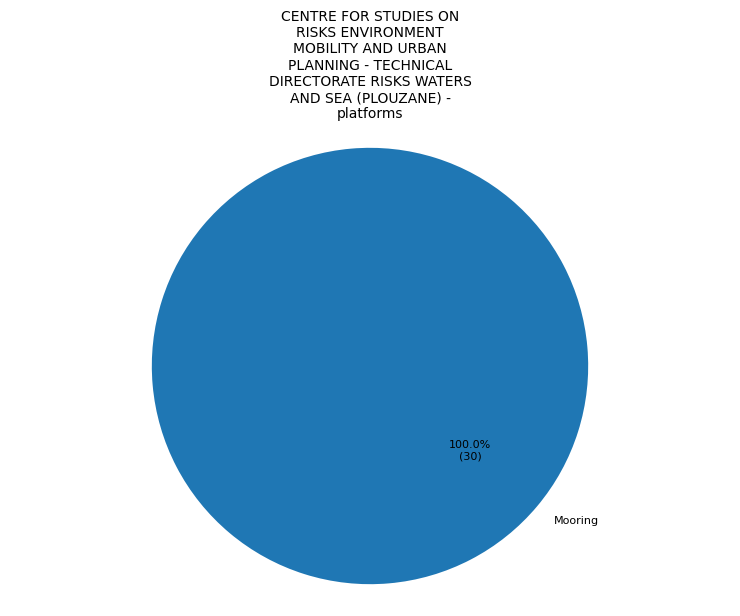

Saved: provider_pies/pie_centre-for-studies-on-risks-environment-mobility-and-urban-planning-technical-directorate-risks-waters-and-sea-plouzane.png


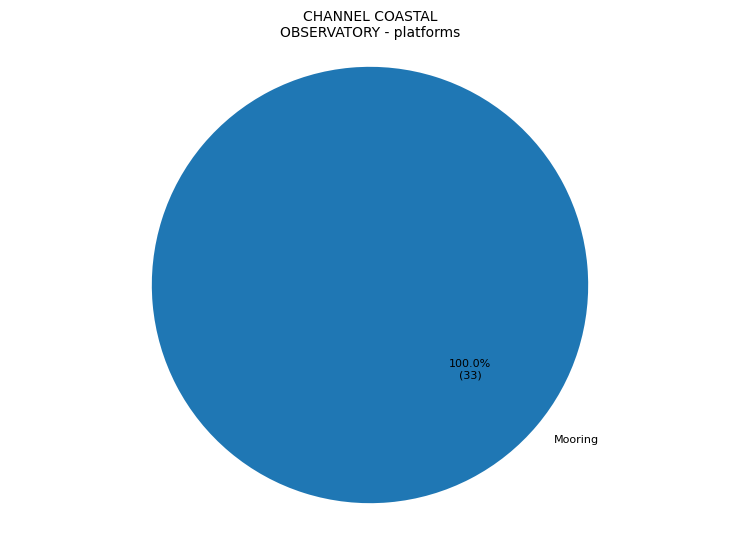

Saved: provider_pies/pie_channel-coastal-observatory.png


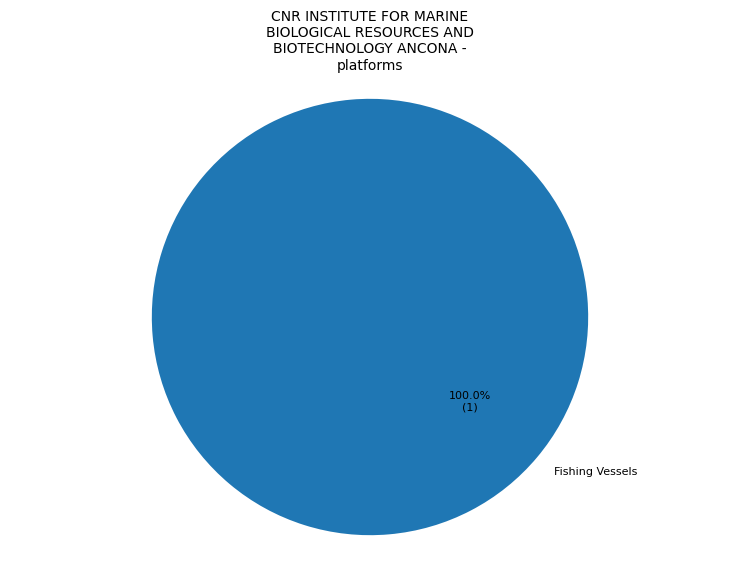

Saved: provider_pies/pie_cnr-institute-for-marine-biological-resources-and-biotechnology-ancona.png


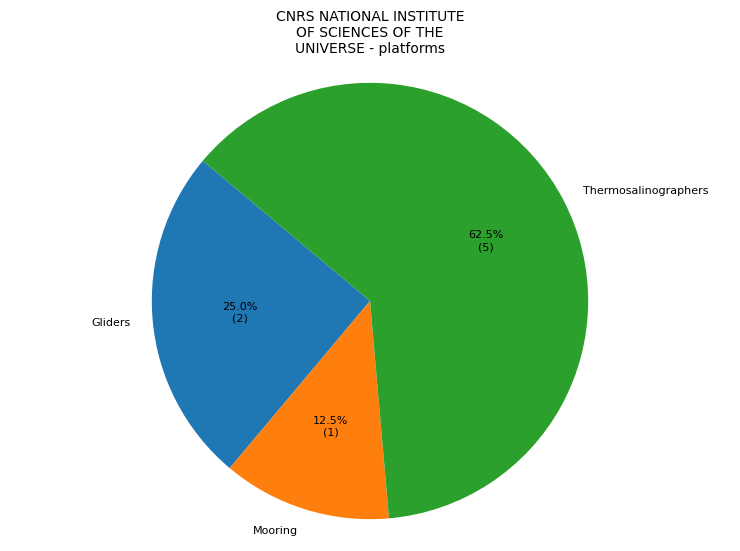

Saved: provider_pies/pie_cnrs-national-institute-of-sciences-of-the-universe.png


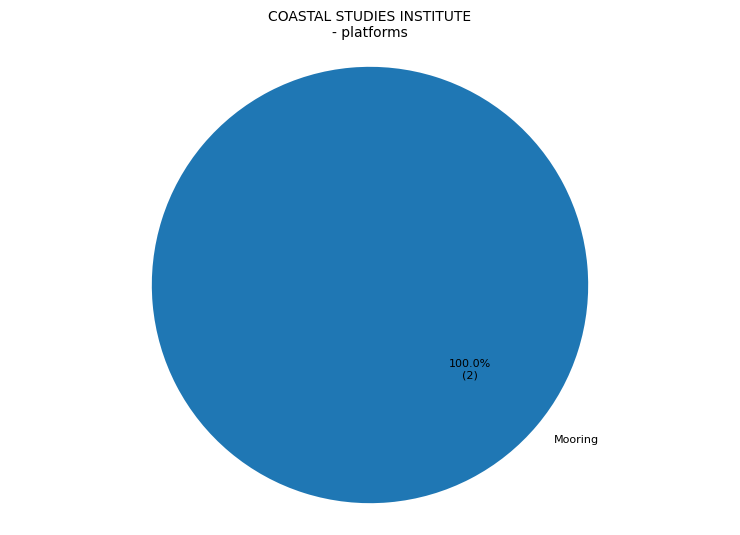

Saved: provider_pies/pie_coastal-studies-institute.png


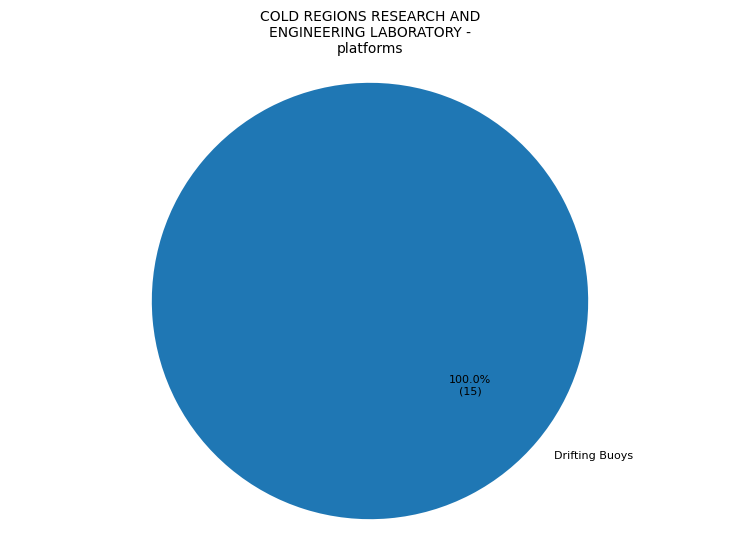

Saved: provider_pies/pie_cold-regions-research-and-engineering-laboratory.png


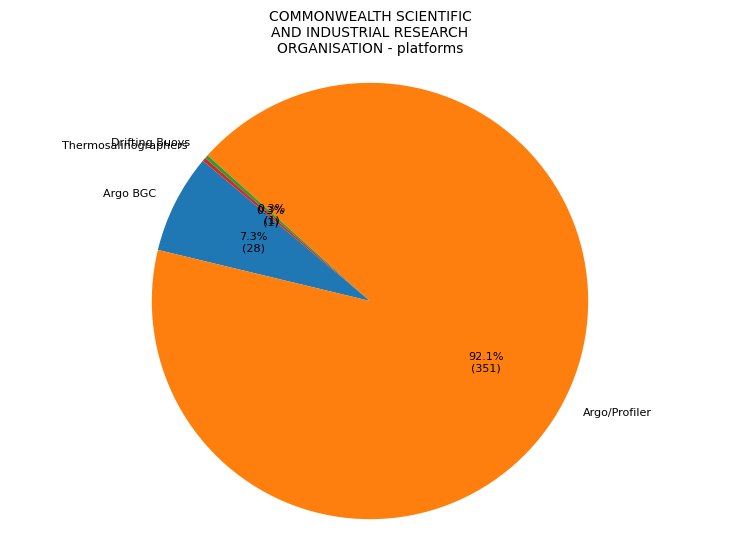

Saved: provider_pies/pie_commonwealth-scientific-and-industrial-research-organisation.png


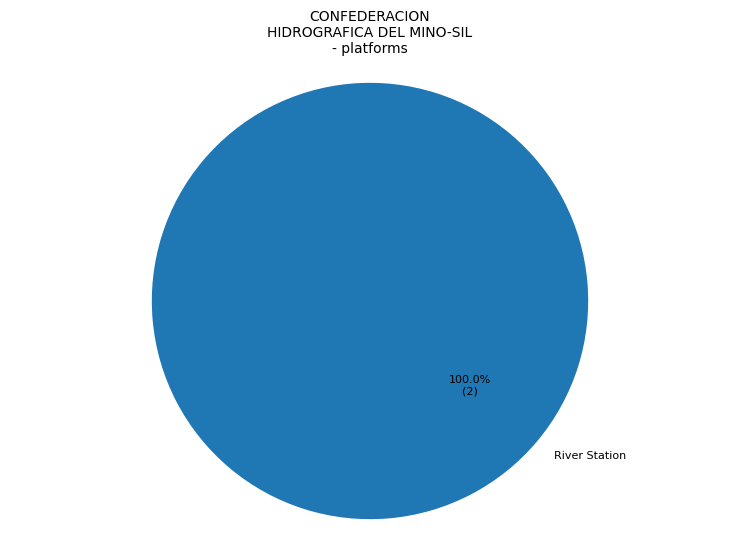

Saved: provider_pies/pie_confederacion-hidrografica-del-mino-sil.png


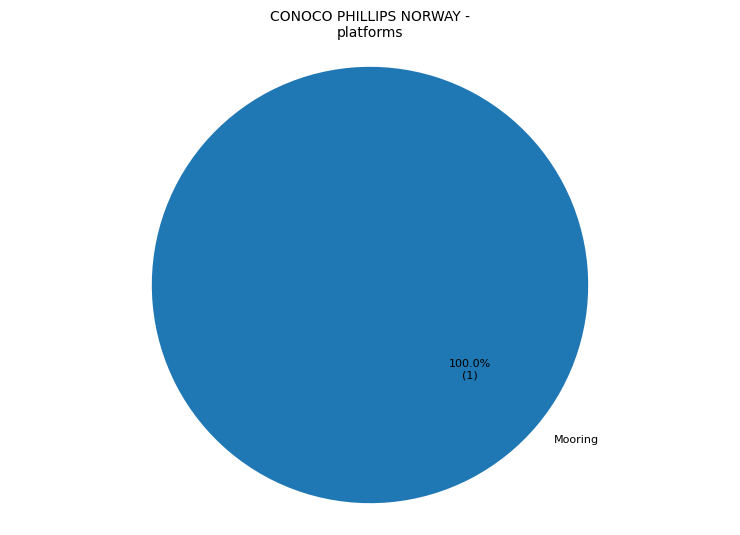

Saved: provider_pies/pie_conoco-phillips-norway.png


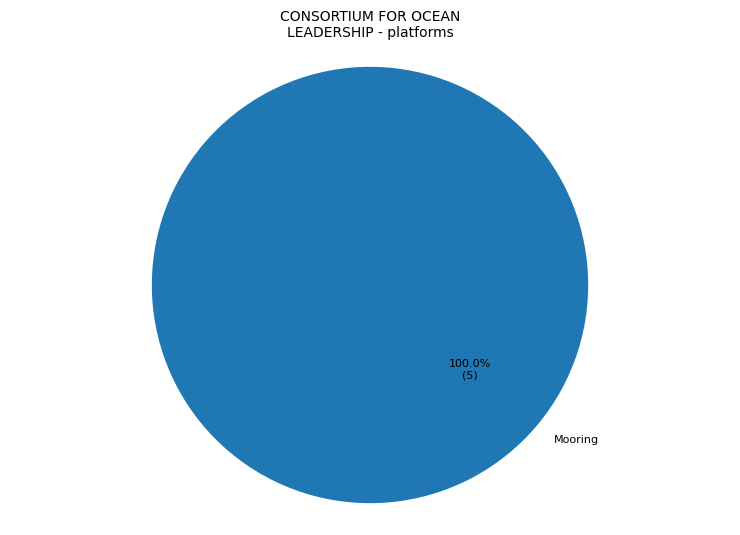

Saved: provider_pies/pie_consortium-for-ocean-leadership.png


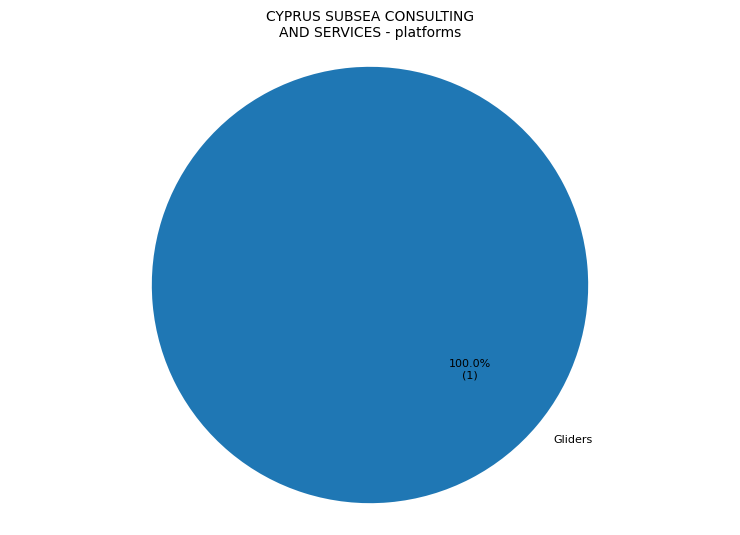

Saved: provider_pies/pie_cyprus-subsea-consulting-and-services.png


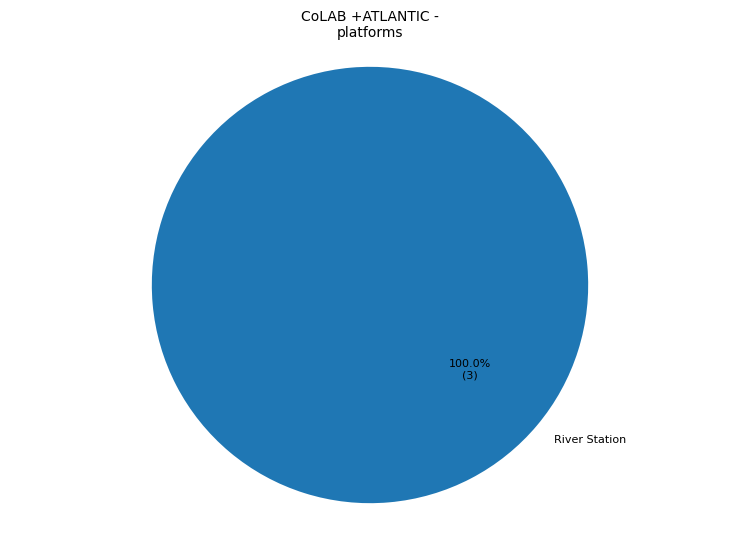

Saved: provider_pies/pie_colab-atlantic.png


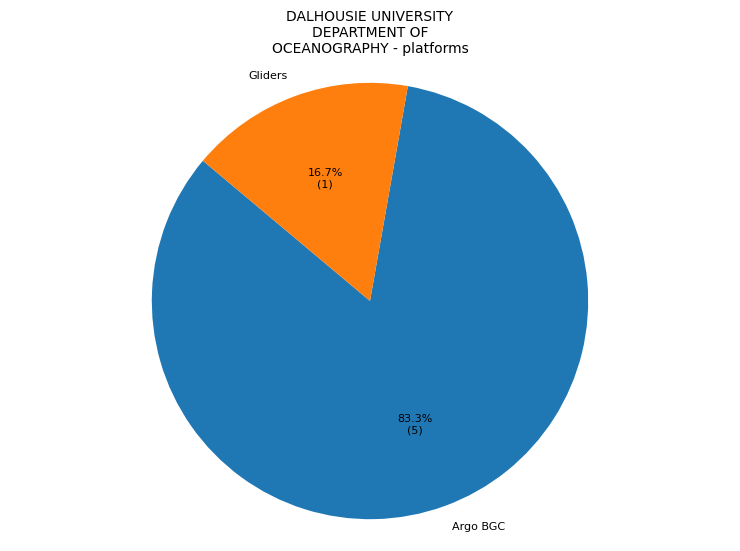

Saved: provider_pies/pie_dalhousie-university-department-of-oceanography.png


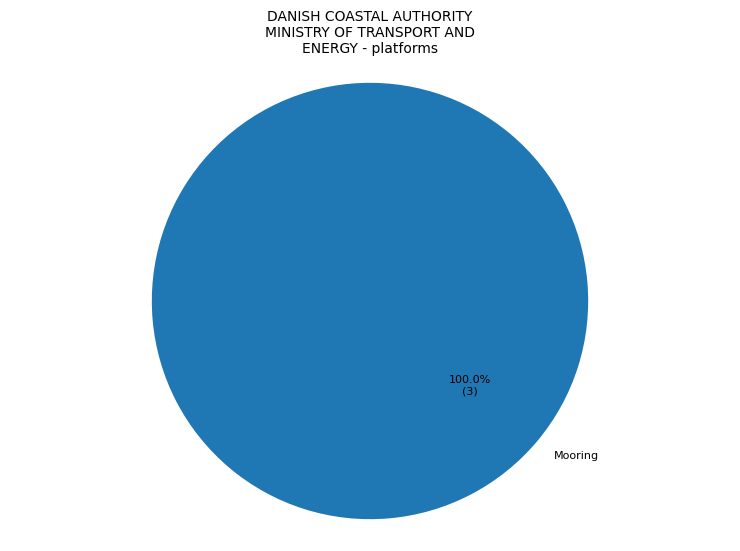

Saved: provider_pies/pie_danish-coastal-authority-ministry-of-transport-and-energy.png


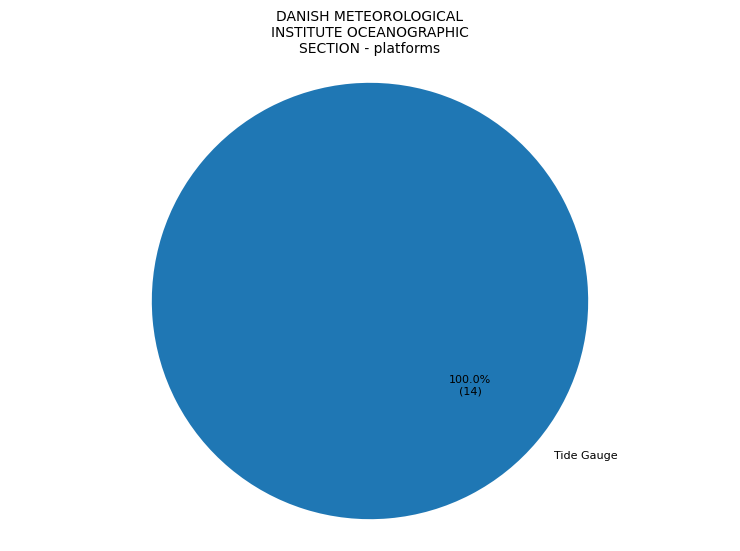

Saved: provider_pies/pie_danish-meteorological-institute-oceanographic-section.png


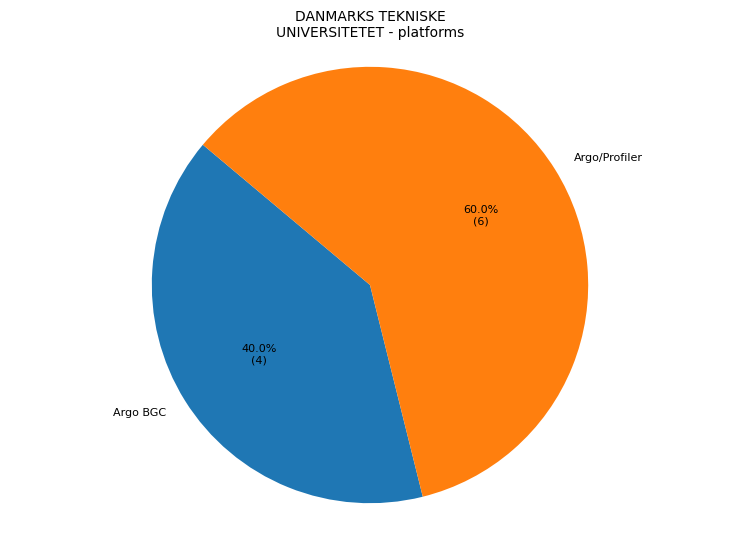

Saved: provider_pies/pie_danmarks-tekniske-universitetet.png


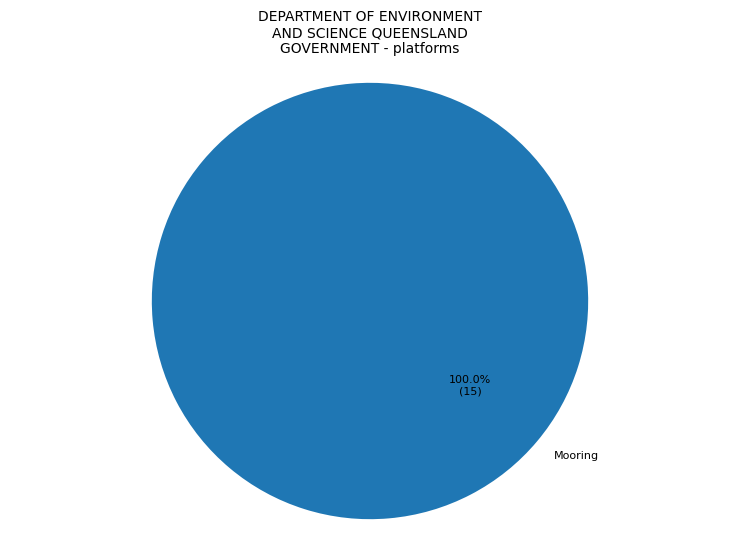

Saved: provider_pies/pie_department-of-environment-and-science-queensland-government.png


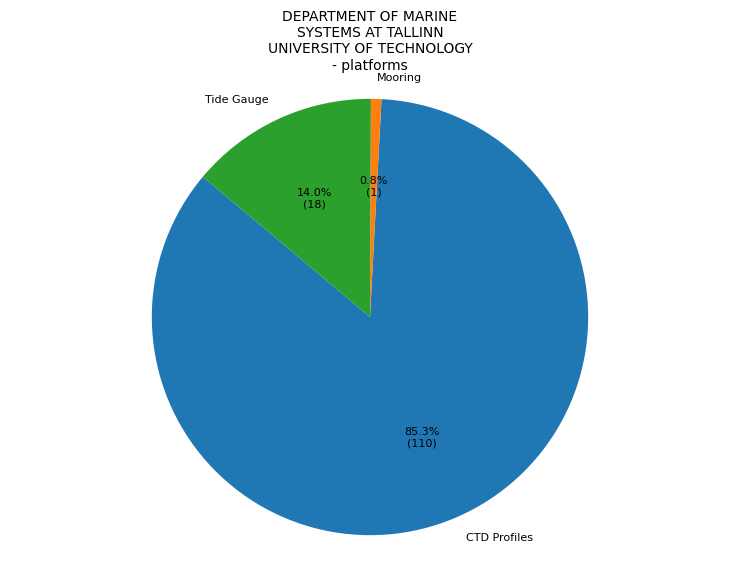

Saved: provider_pies/pie_department-of-marine-systems-at-tallinn-university-of-technology.png


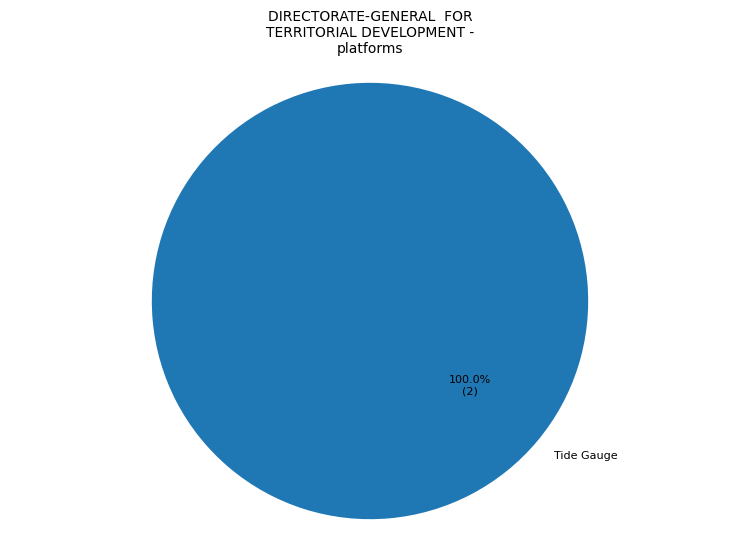

Saved: provider_pies/pie_directorate-general-for-territorial-development.png


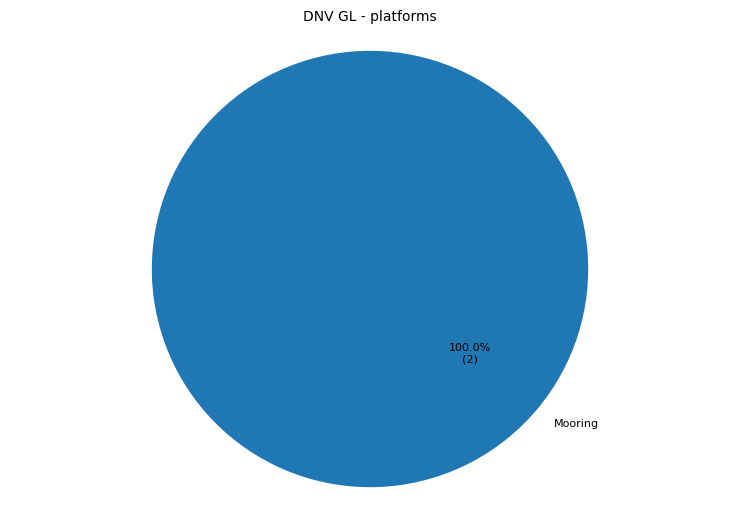

Saved: provider_pies/pie_dnv-gl.png


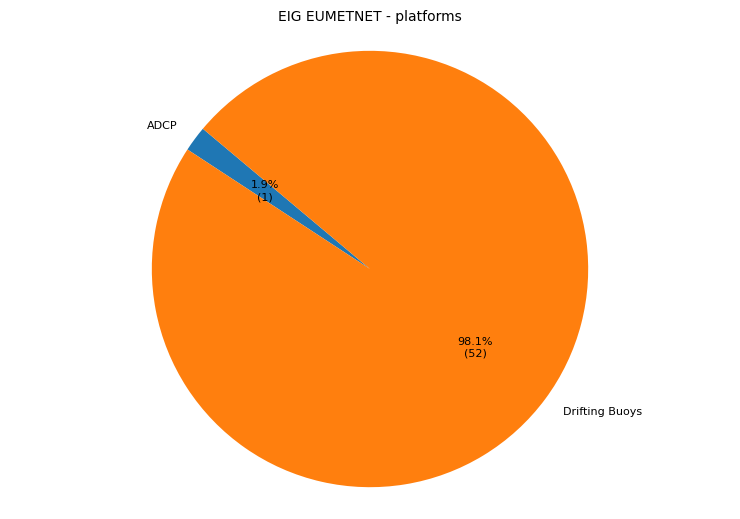

Saved: provider_pies/pie_eig-eumetnet.png


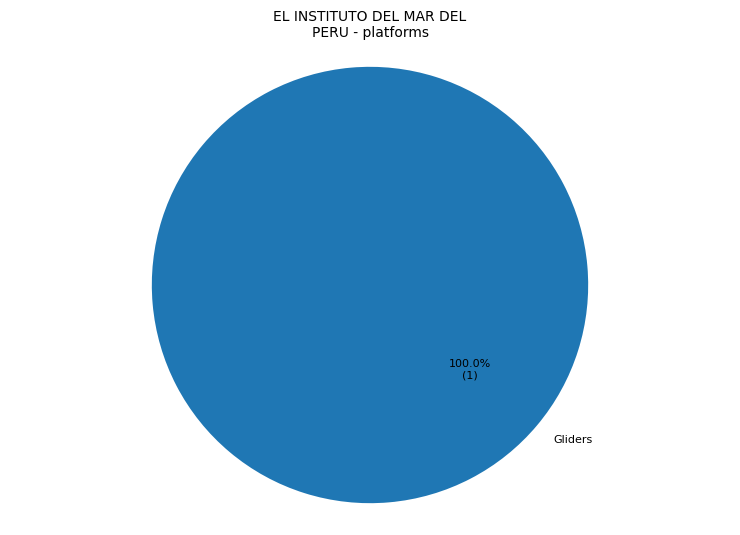

Saved: provider_pies/pie_el-instituto-del-mar-del-peru.png


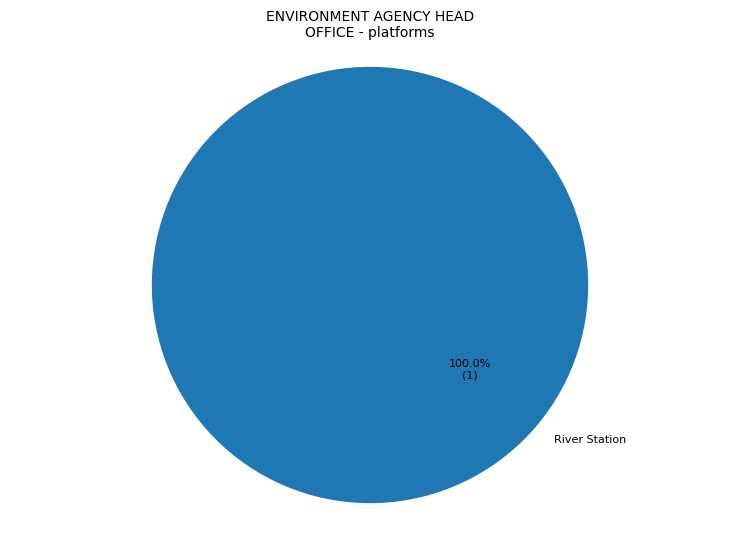

Saved: provider_pies/pie_environment-agency-head-office.png


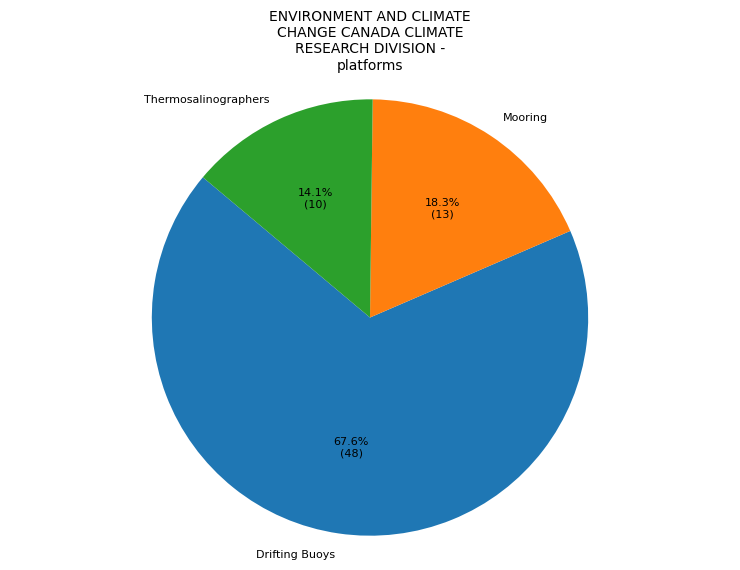

Saved: provider_pies/pie_environment-and-climate-change-canada-climate-research-division.png


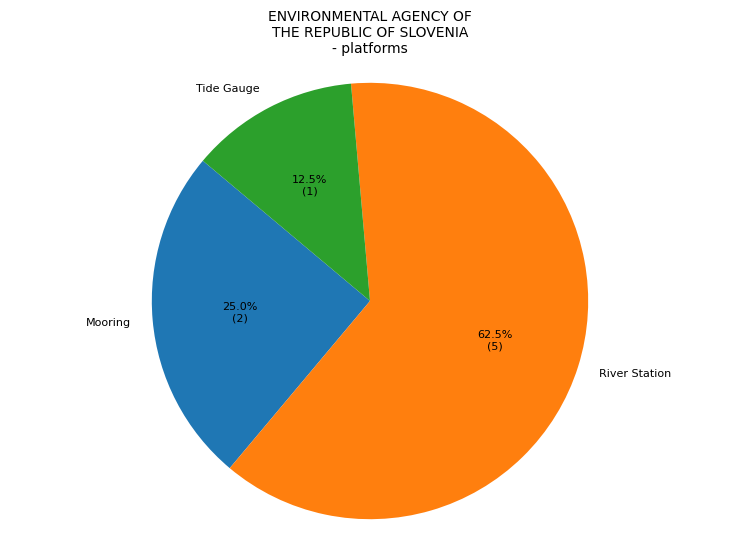

Saved: provider_pies/pie_environmental-agency-of-the-republic-of-slovenia.png


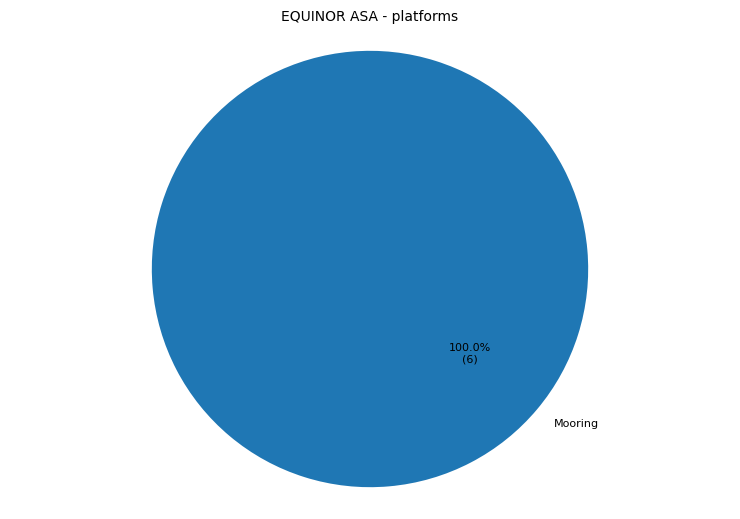

Saved: provider_pies/pie_equinor-asa.png


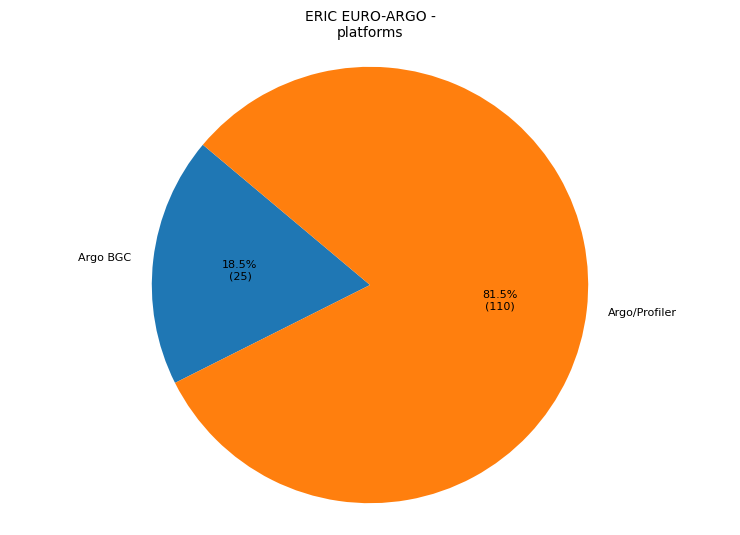

Saved: provider_pies/pie_eric-euro-argo.png


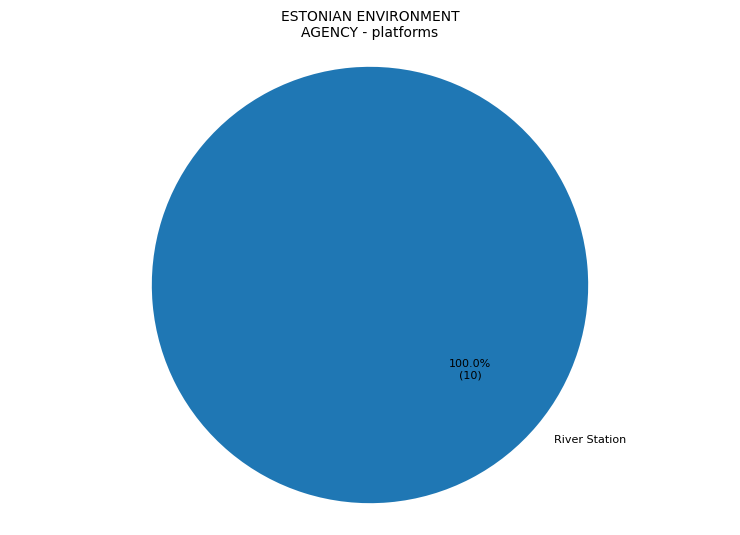

Saved: provider_pies/pie_estonian-environment-agency.png


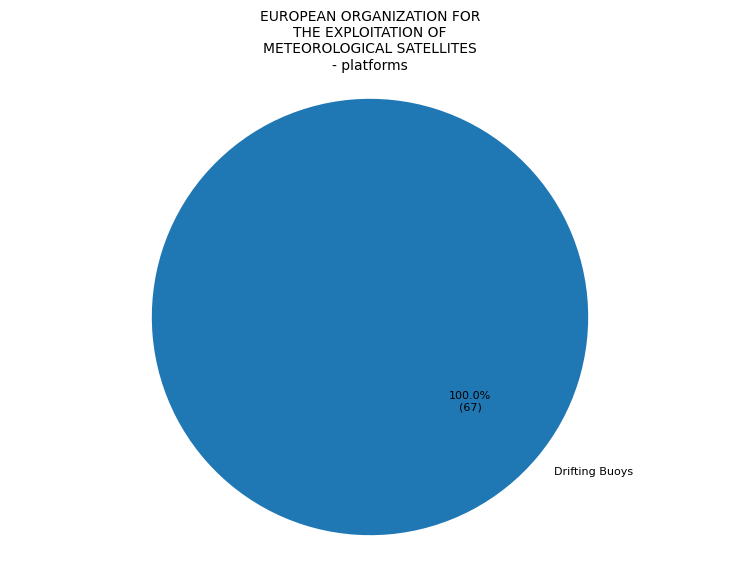

Saved: provider_pies/pie_european-organization-for-the-exploitation-of-meteorological-satellites.png


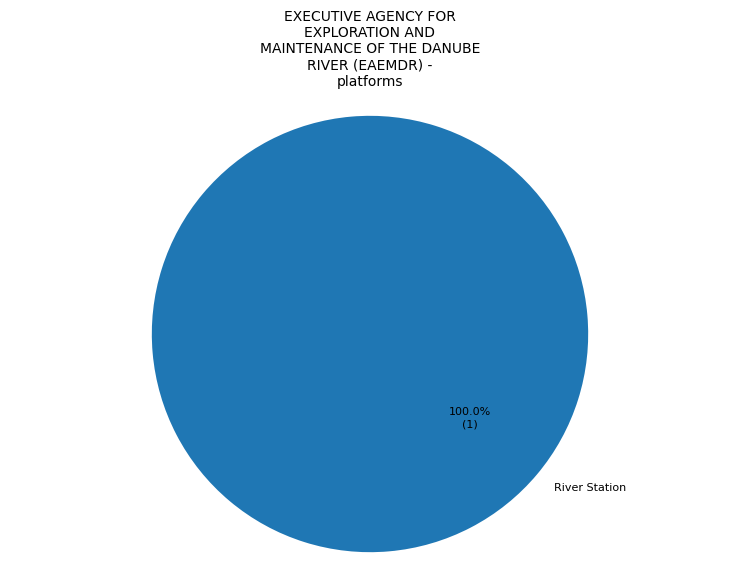

Saved: provider_pies/pie_executive-agency-for-exploration-and-maintenance-of-the-danube-river-eaemdr.png


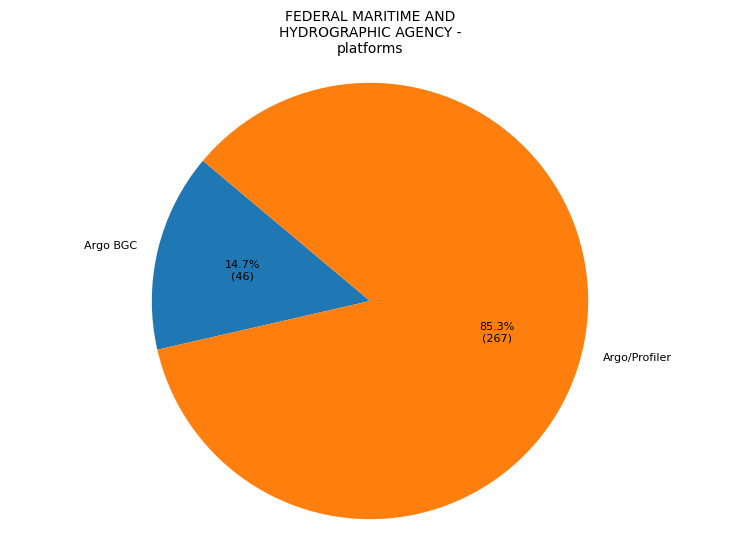

Saved: provider_pies/pie_federal-maritime-and-hydrographic-agency.png


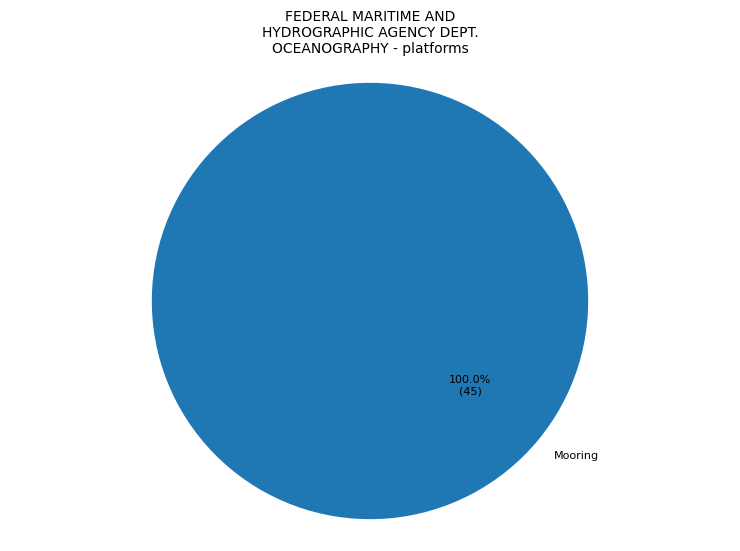

Saved: provider_pies/pie_federal-maritime-and-hydrographic-agency-dept-oceanography.png


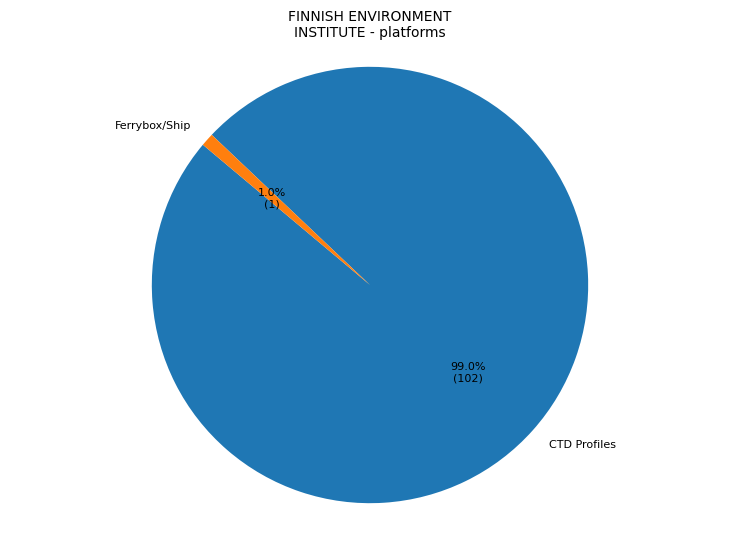

Saved: provider_pies/pie_finnish-environment-institute.png


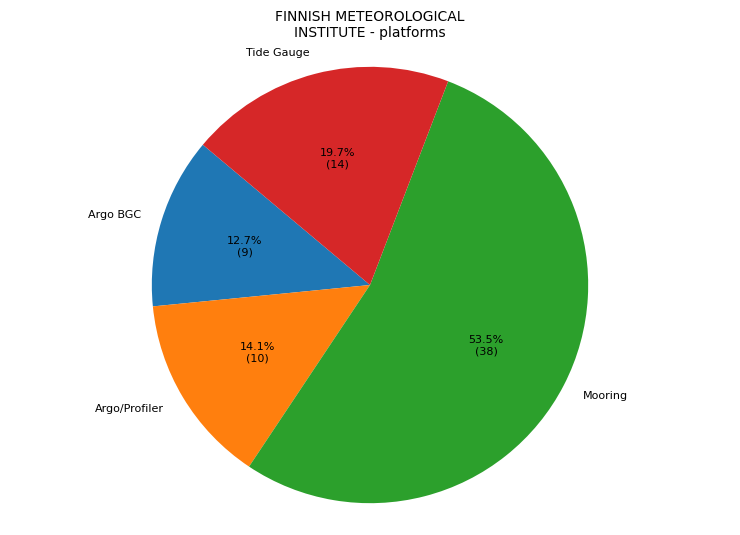

Saved: provider_pies/pie_finnish-meteorological-institute.png


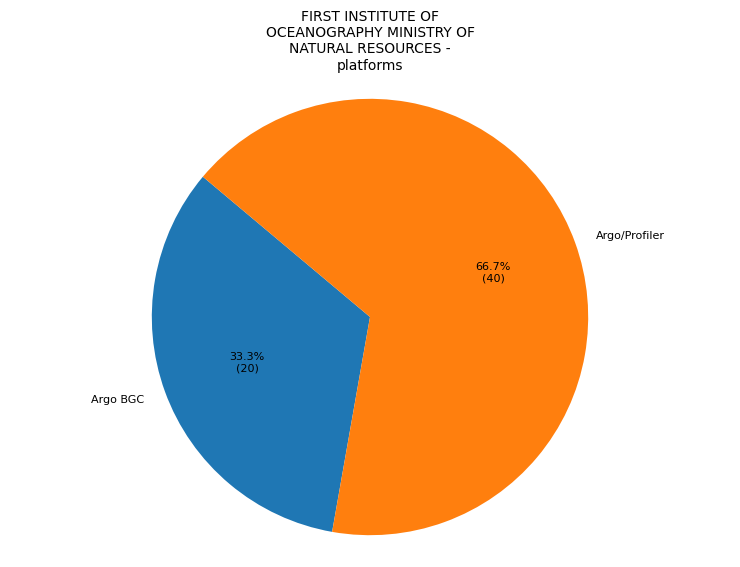

Saved: provider_pies/pie_first-institute-of-oceanography-ministry-of-natural-resources.png


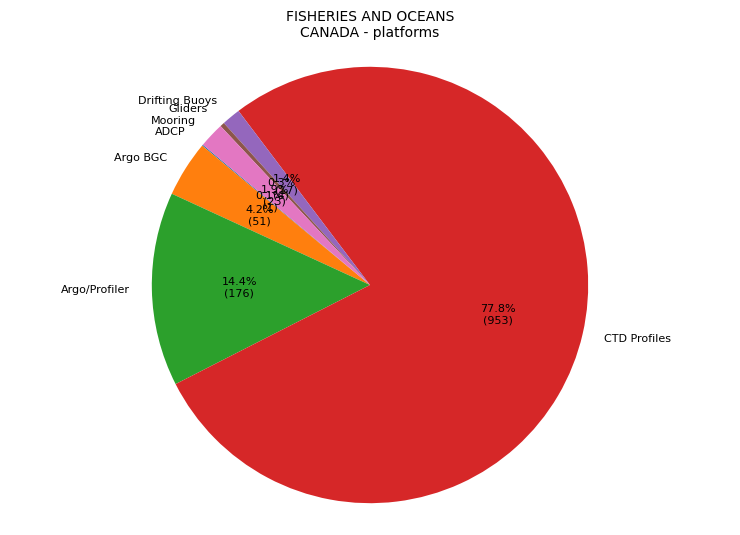

Saved: provider_pies/pie_fisheries-and-oceans-canada.png


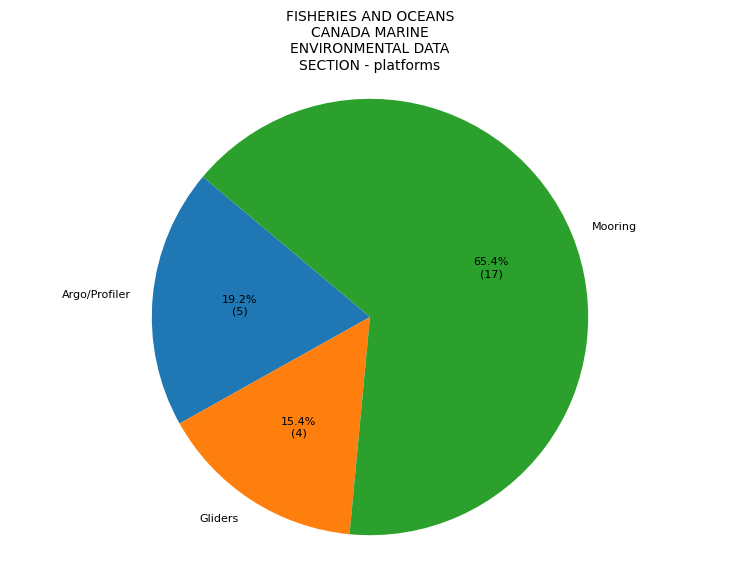

Saved: provider_pies/pie_fisheries-and-oceans-canada-marine-environmental-data-section.png


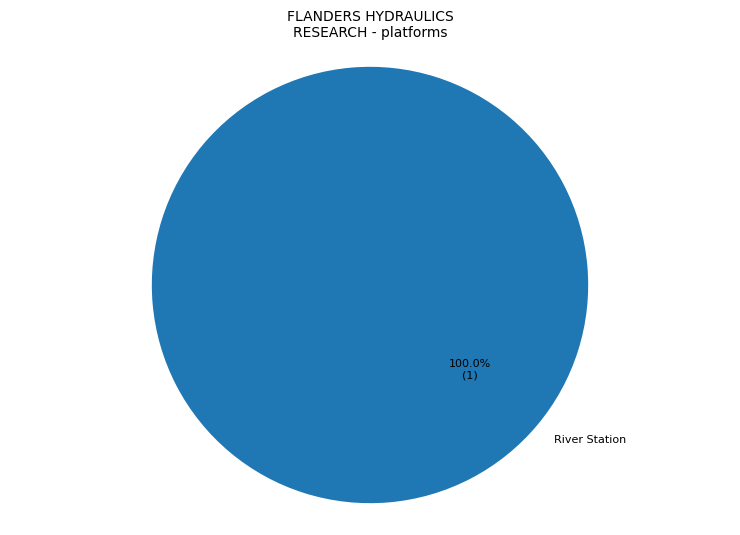

Saved: provider_pies/pie_flanders-hydraulics-research.png


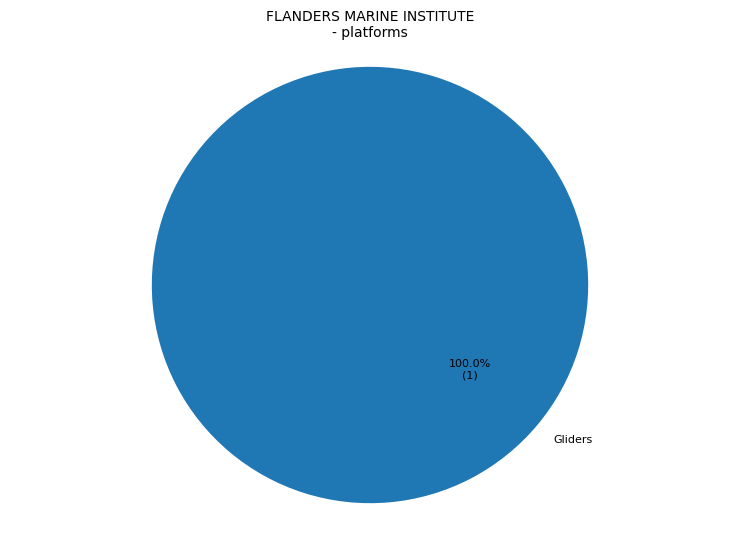

Saved: provider_pies/pie_flanders-marine-institute.png


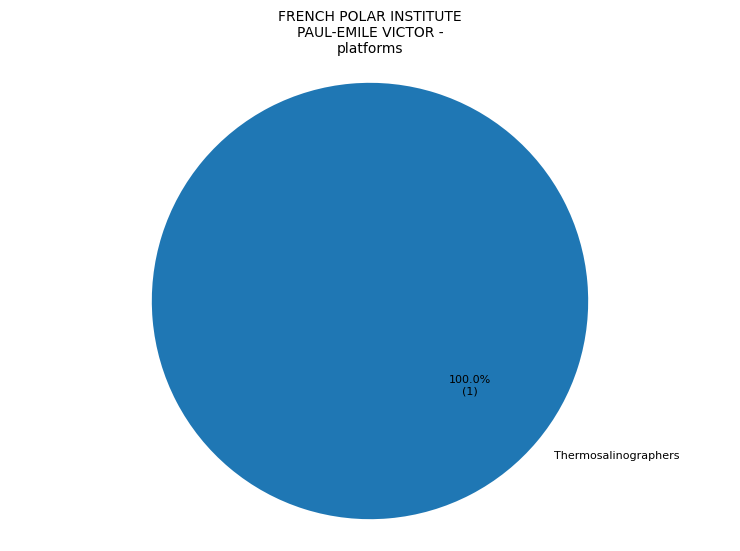

Saved: provider_pies/pie_french-polar-institute-paul-emile-victor.png


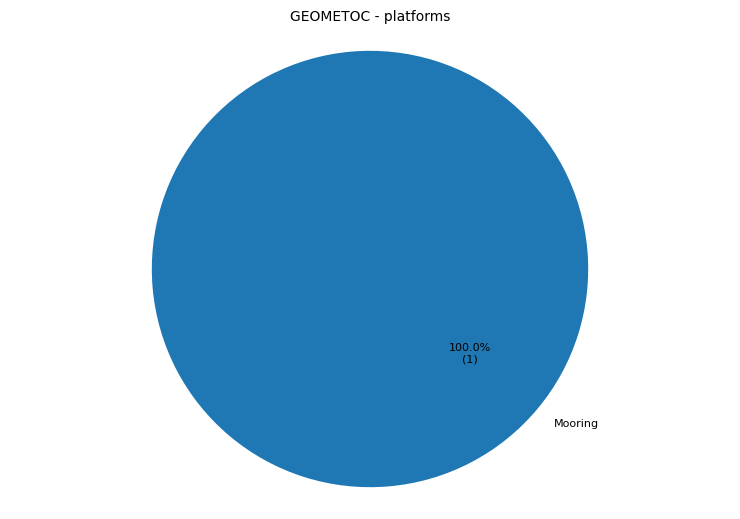

Saved: provider_pies/pie_geometoc.png


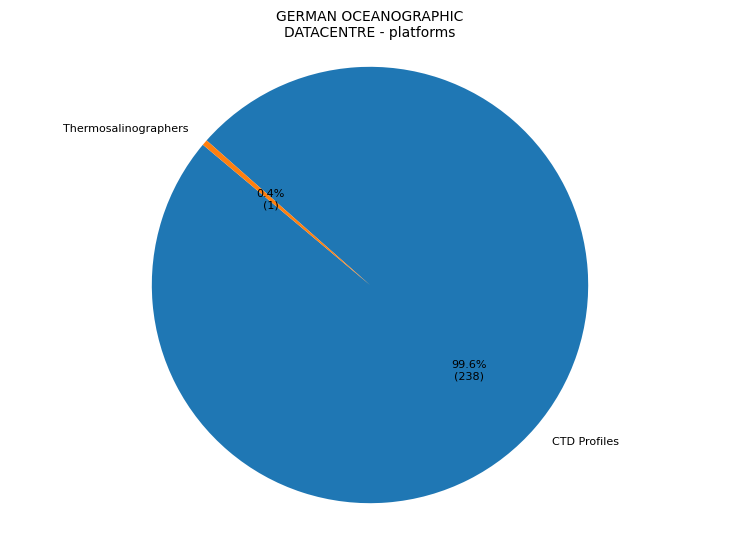

Saved: provider_pies/pie_german-oceanographic-datacentre.png


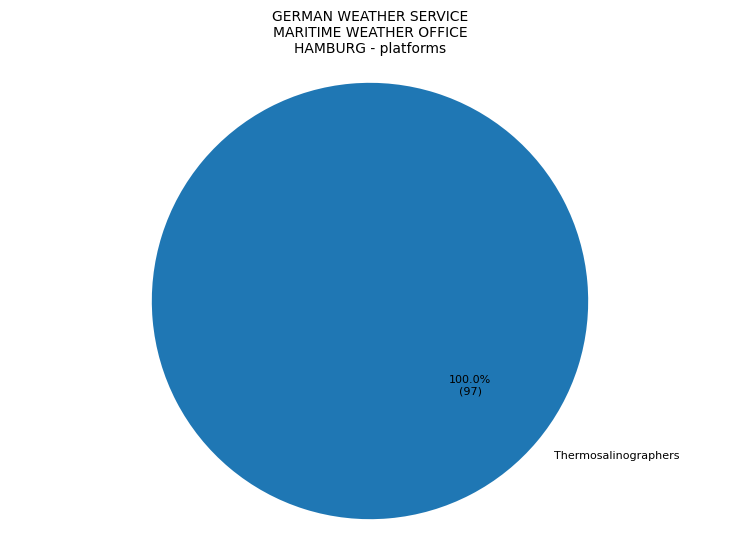

Saved: provider_pies/pie_german-weather-service-maritime-weather-office-hamburg.png


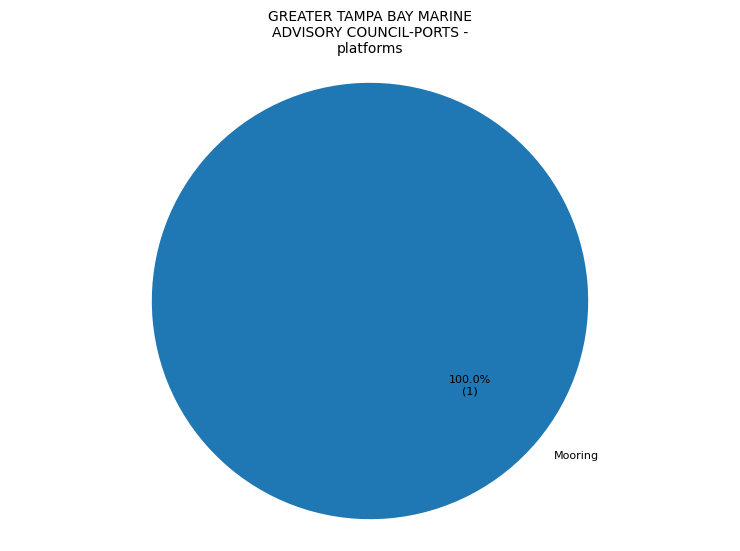

Saved: provider_pies/pie_greater-tampa-bay-marine-advisory-council-ports.png


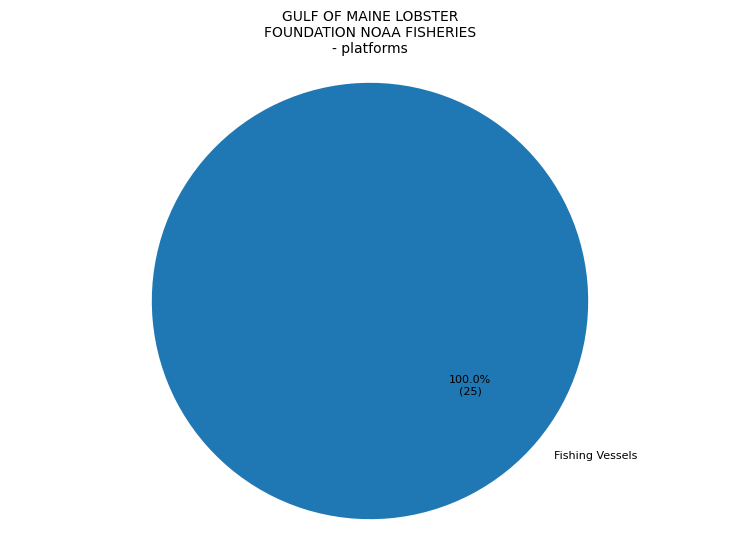

Saved: provider_pies/pie_gulf-of-maine-lobster-foundation-noaa-fisheries.png


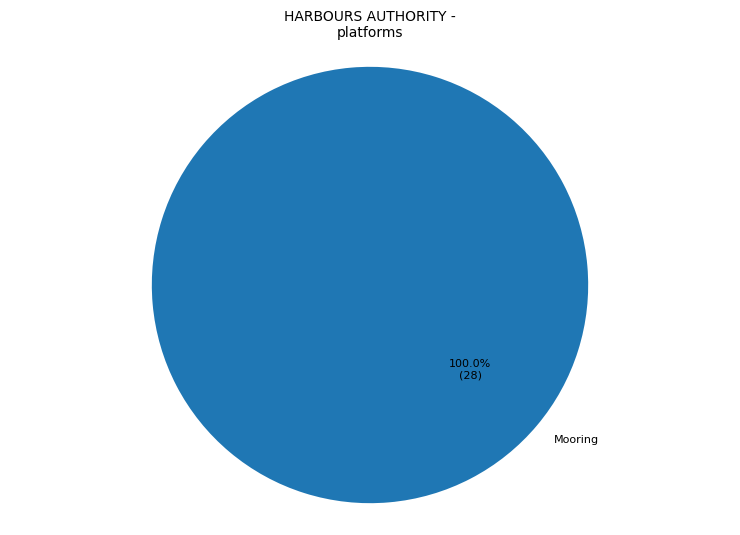

Saved: provider_pies/pie_harbours-authority.png


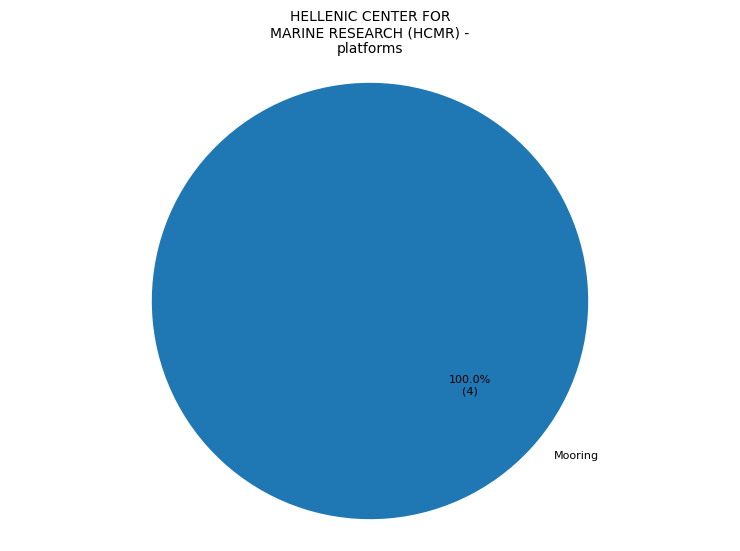

Saved: provider_pies/pie_hellenic-center-for-marine-research-hcmr.png


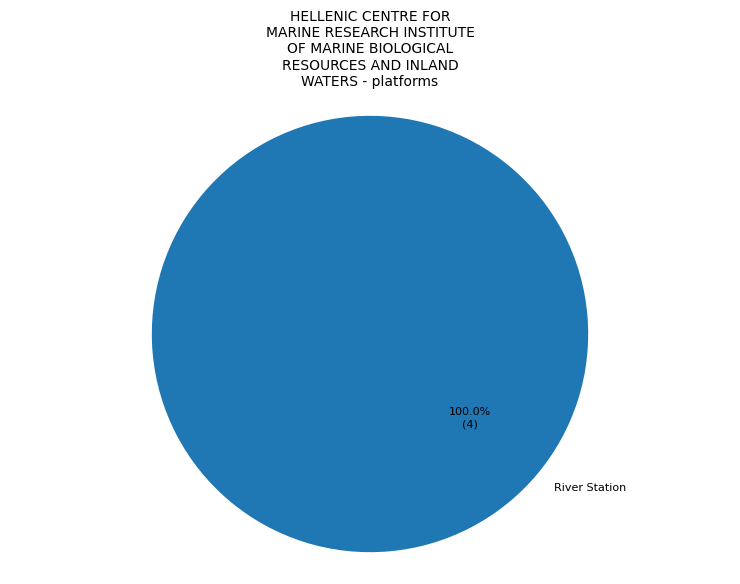

Saved: provider_pies/pie_hellenic-centre-for-marine-research-institute-of-marine-biological-resources-and-inland-waters.png


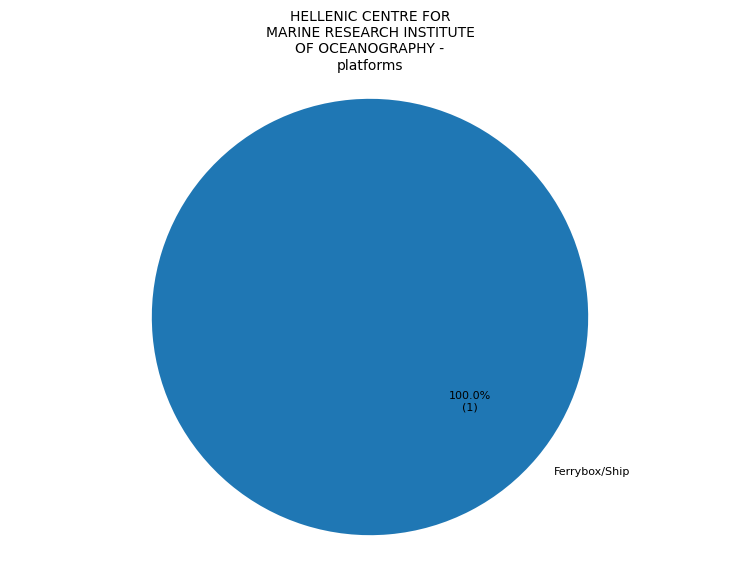

Saved: provider_pies/pie_hellenic-centre-for-marine-research-institute-of-oceanography.png


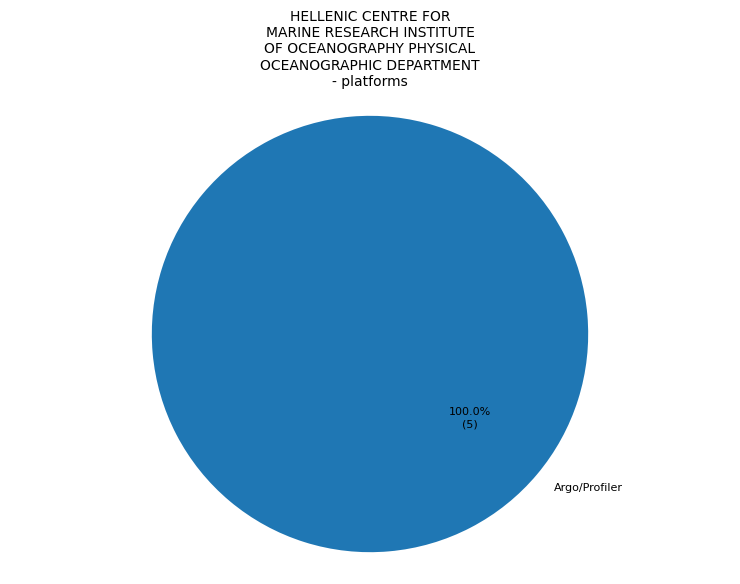

Saved: provider_pies/pie_hellenic-centre-for-marine-research-institute-of-oceanography-physical-oceanographic-department.png


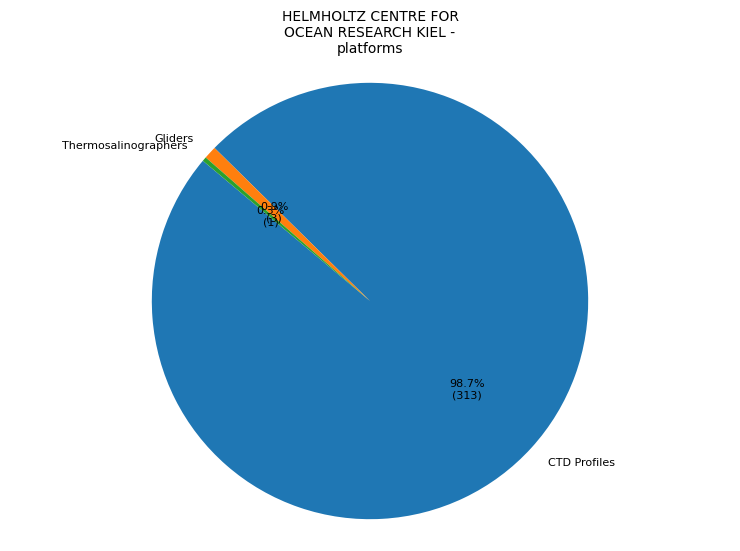

Saved: provider_pies/pie_helmholtz-centre-for-ocean-research-kiel.png


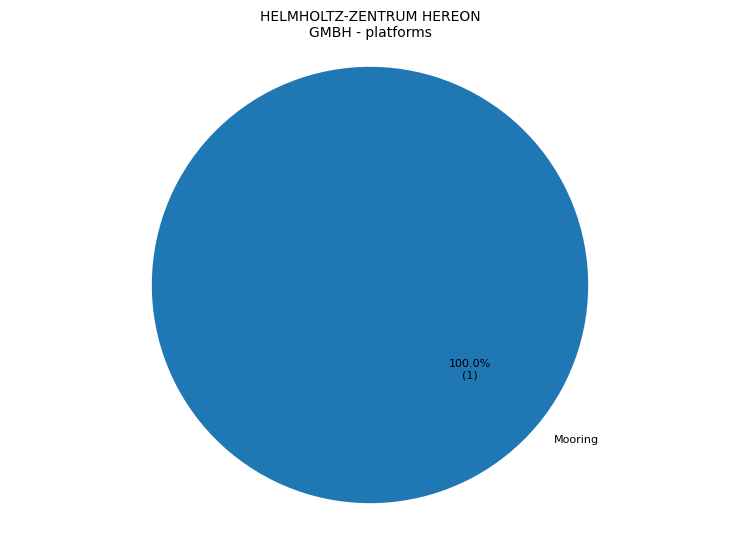

Saved: provider_pies/pie_helmholtz-zentrum-hereon-gmbh.png


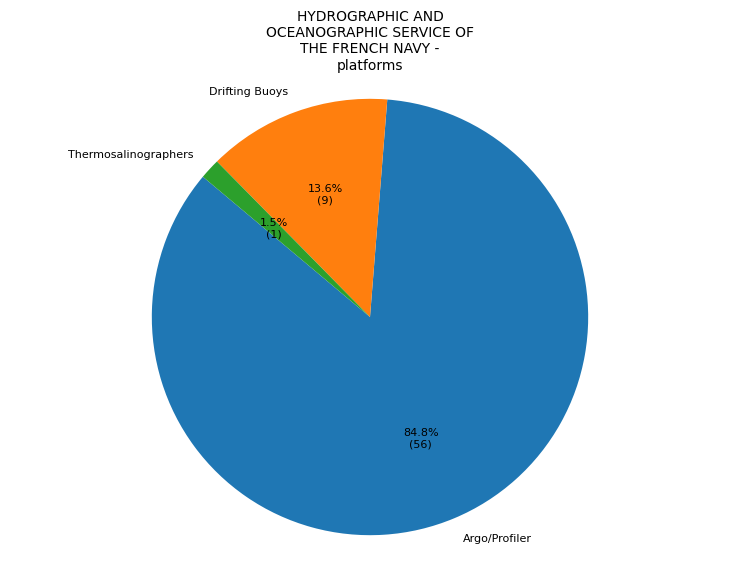

Saved: provider_pies/pie_hydrographic-and-oceanographic-service-of-the-french-navy.png


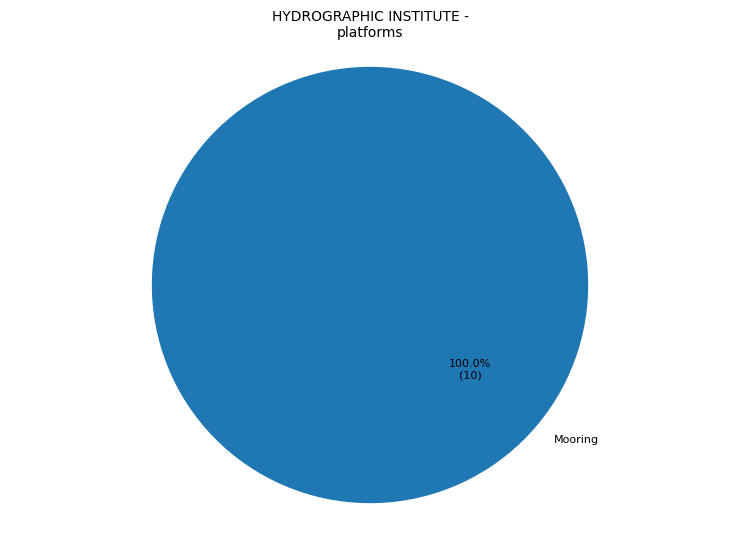

Saved: provider_pies/pie_hydrographic-institute.png


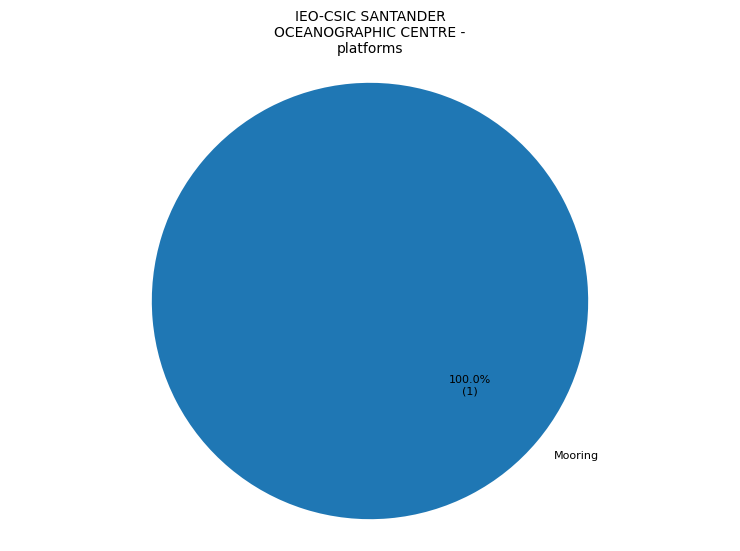

Saved: provider_pies/pie_ieo-csic-santander-oceanographic-centre.png


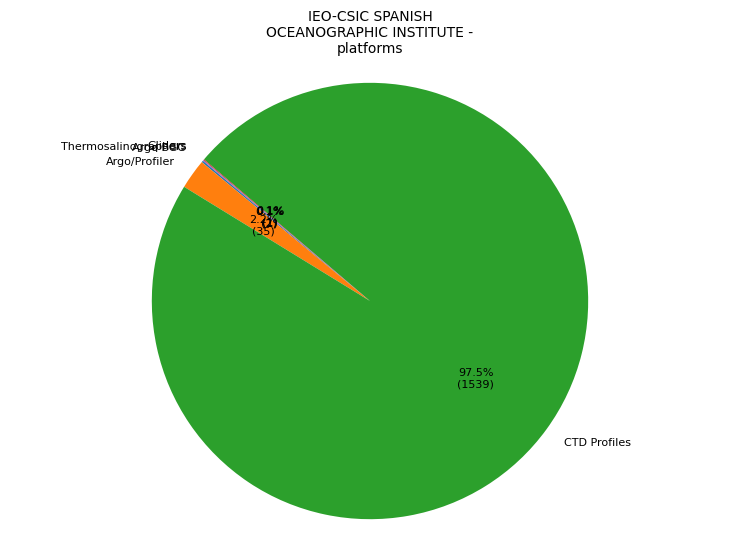

Saved: provider_pies/pie_ieo-csic-spanish-oceanographic-institute.png


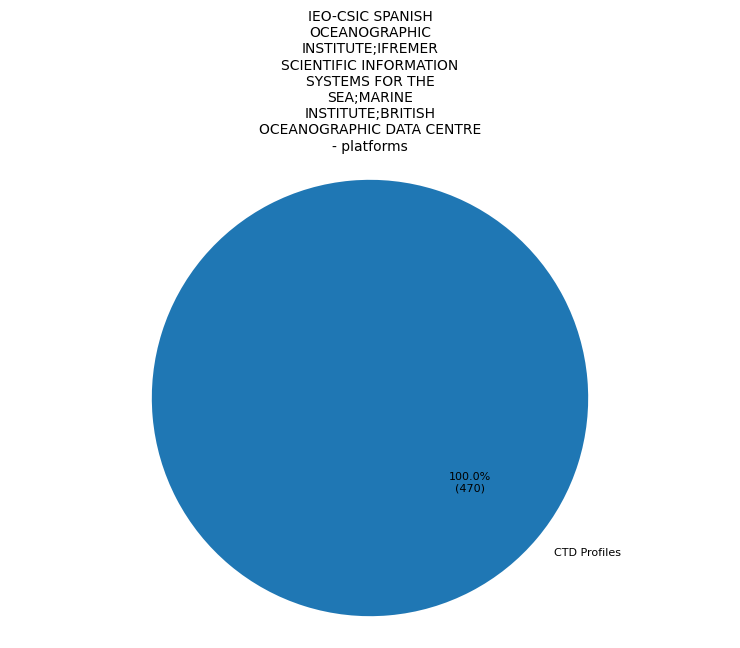

Saved: provider_pies/pie_ieo-csic-spanish-oceanographic-institute-ifremer-scientific-information-systems-for-the-sea-marine-institute-british-oceanographic-data-centre.png


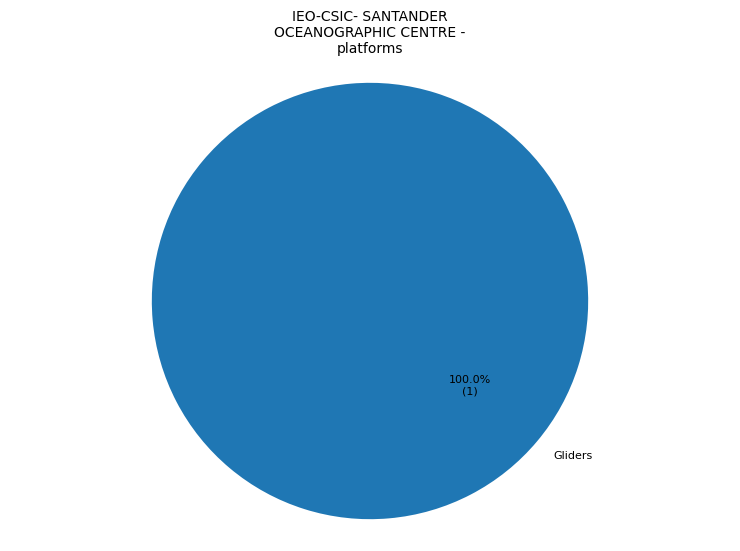

Saved: provider_pies/pie_ieo-csic-santander-oceanographic-centre.png


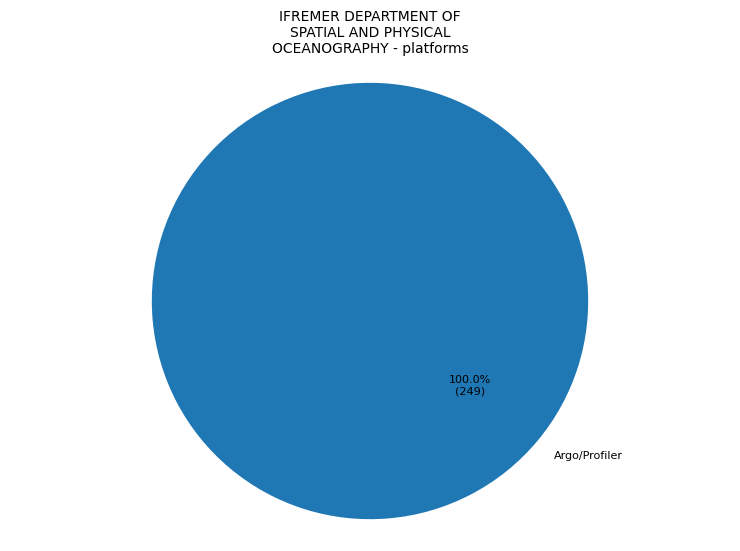

Saved: provider_pies/pie_ifremer-department-of-spatial-and-physical-oceanography.png


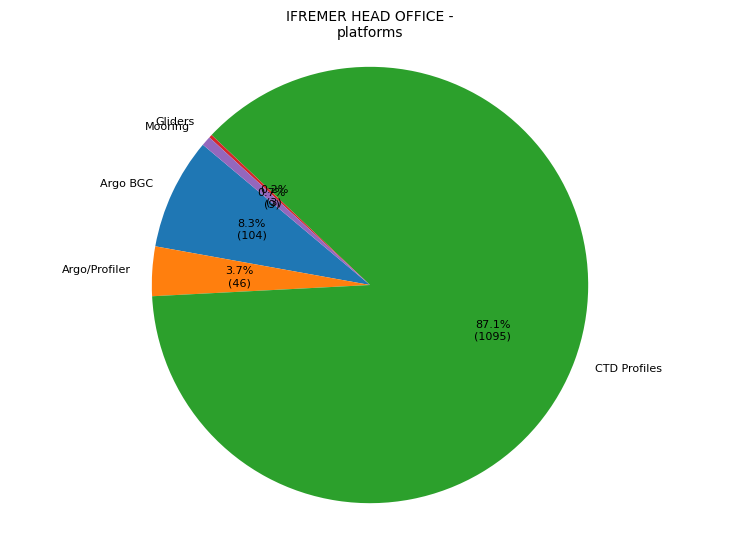

Saved: provider_pies/pie_ifremer-head-office.png


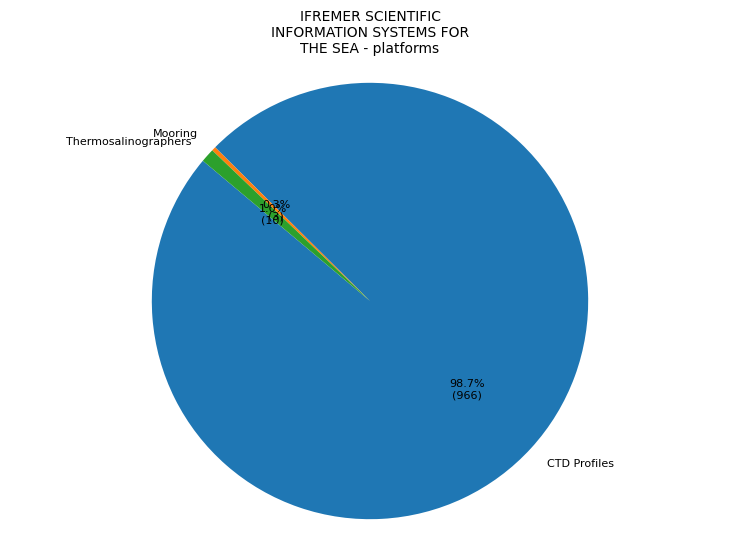

Saved: provider_pies/pie_ifremer-scientific-information-systems-for-the-sea.png


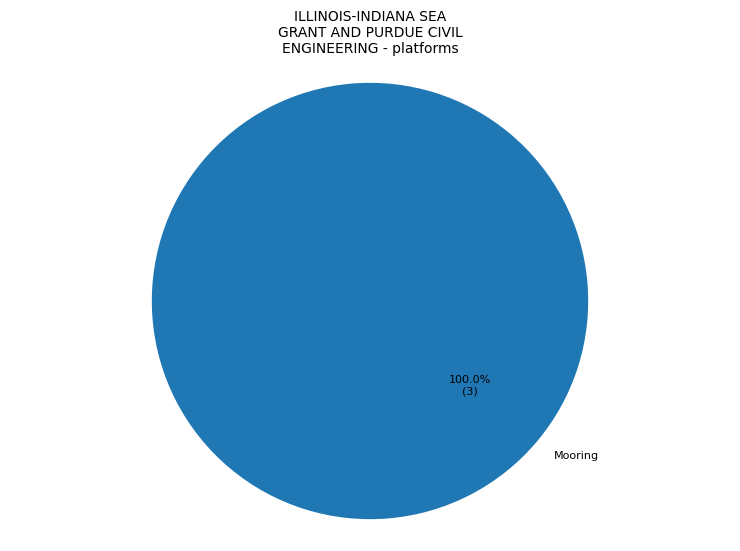

Saved: provider_pies/pie_illinois-indiana-sea-grant-and-purdue-civil-engineering.png


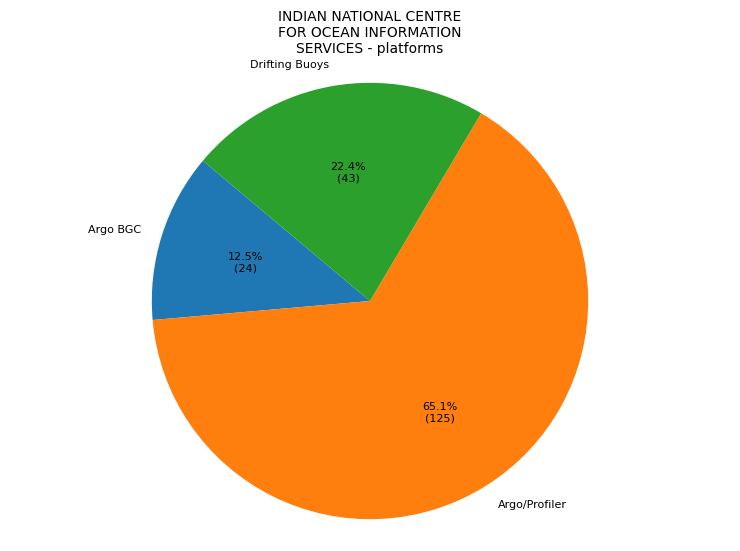

Saved: provider_pies/pie_indian-national-centre-for-ocean-information-services.png


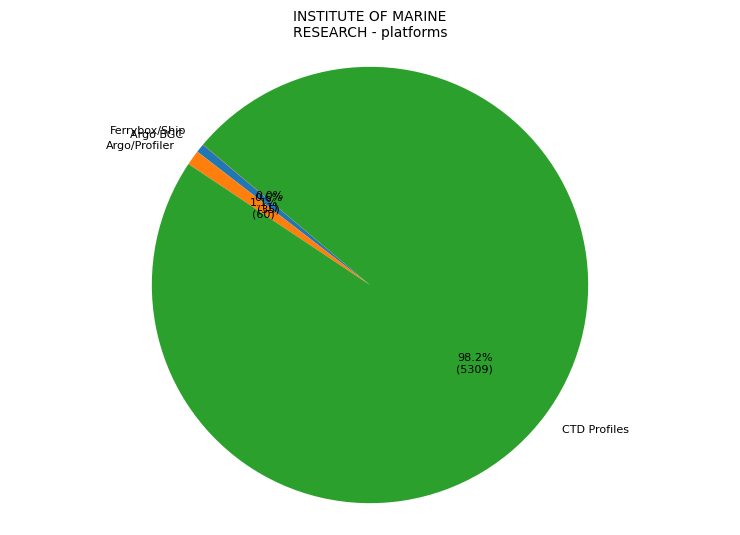

Saved: provider_pies/pie_institute-of-marine-research.png


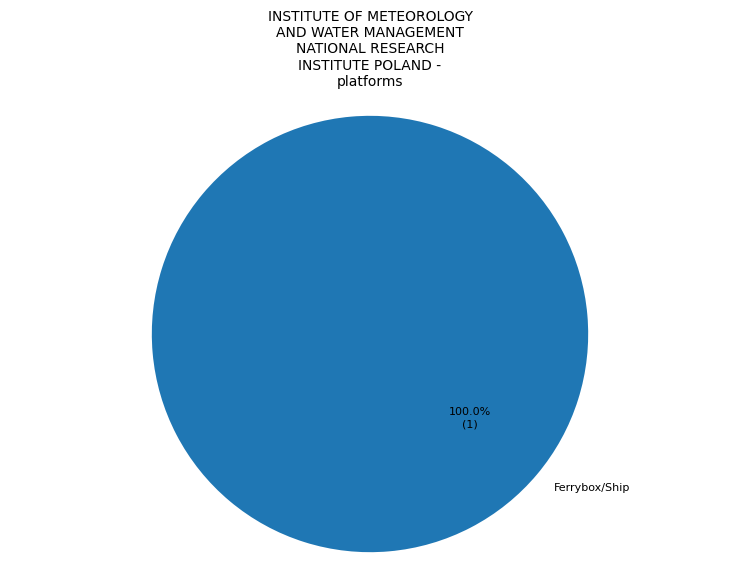

Saved: provider_pies/pie_institute-of-meteorology-and-water-management-national-research-institute-poland.png


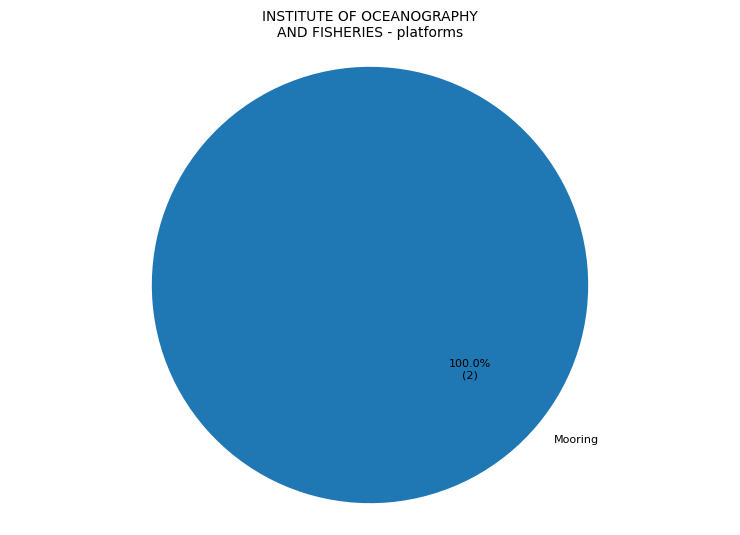

Saved: provider_pies/pie_institute-of-oceanography-and-fisheries.png


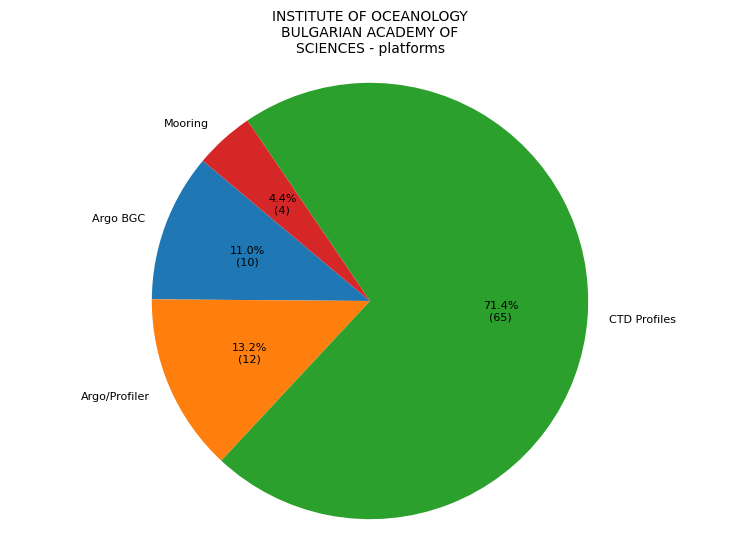

Saved: provider_pies/pie_institute-of-oceanology-bulgarian-academy-of-sciences.png


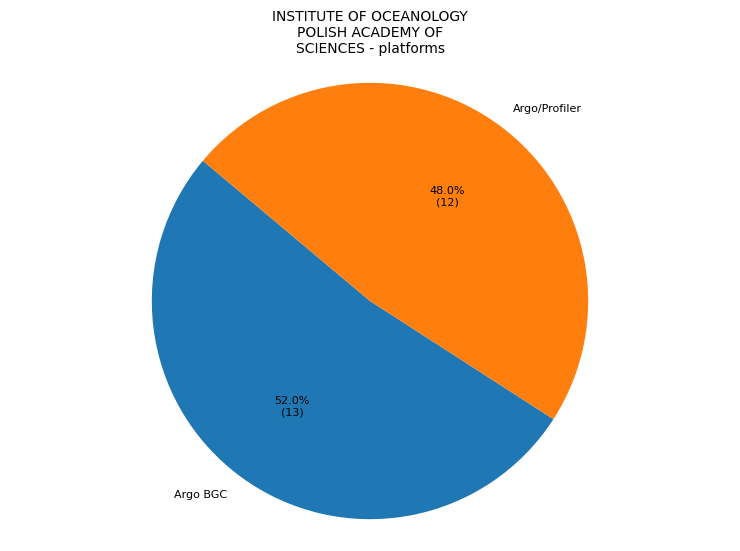

Saved: provider_pies/pie_institute-of-oceanology-polish-academy-of-sciences.png


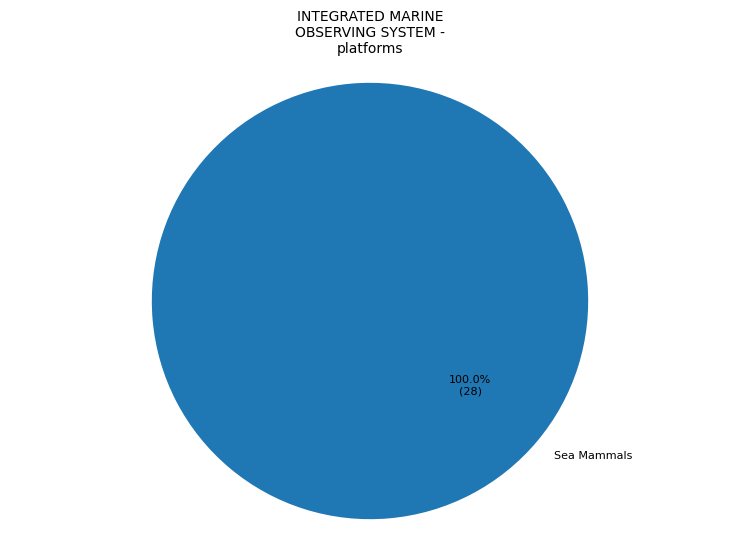

Saved: provider_pies/pie_integrated-marine-observing-system.png


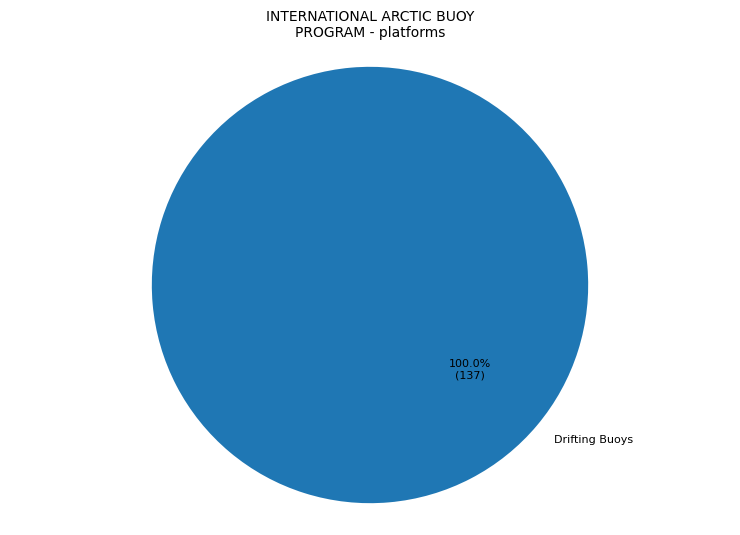

Saved: provider_pies/pie_international-arctic-buoy-program.png


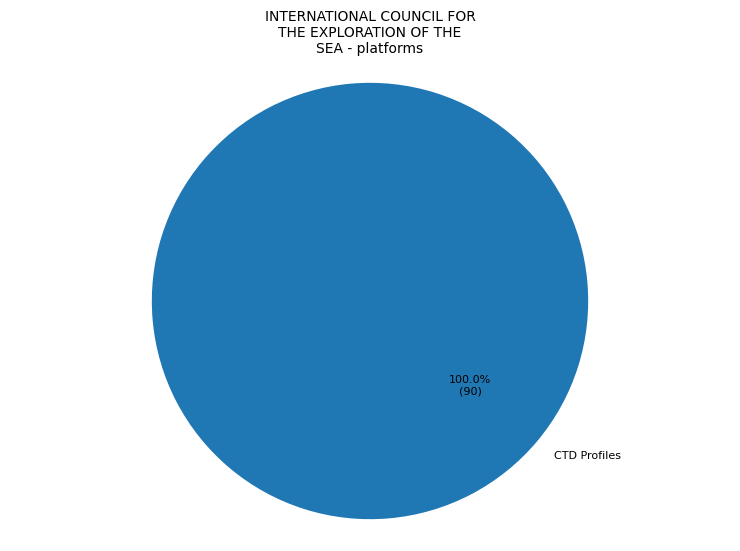

Saved: provider_pies/pie_international-council-for-the-exploration-of-the-sea.png


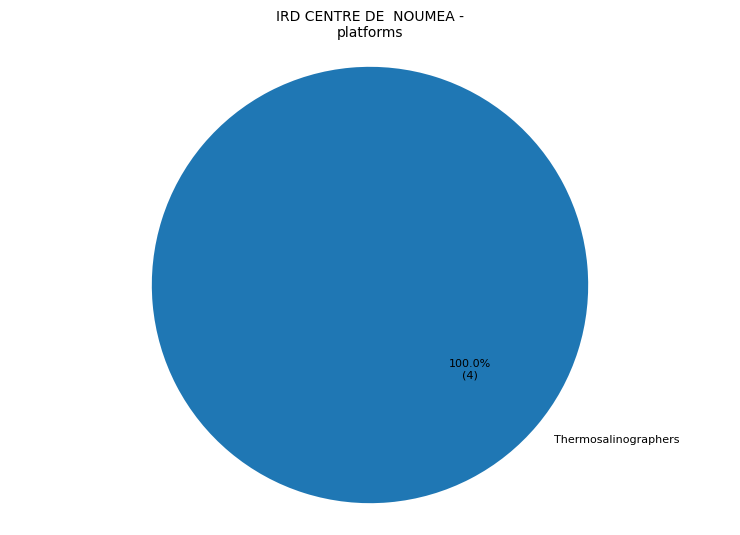

Saved: provider_pies/pie_ird-centre-de-noumea.png


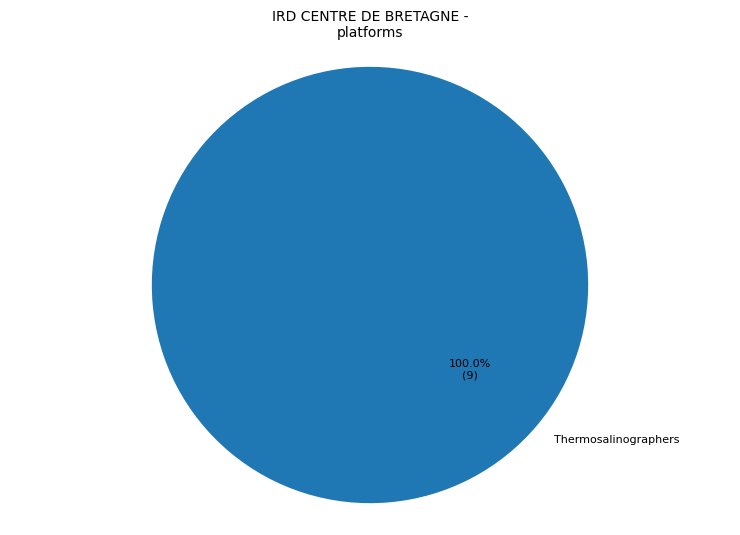

Saved: provider_pies/pie_ird-centre-de-bretagne.png


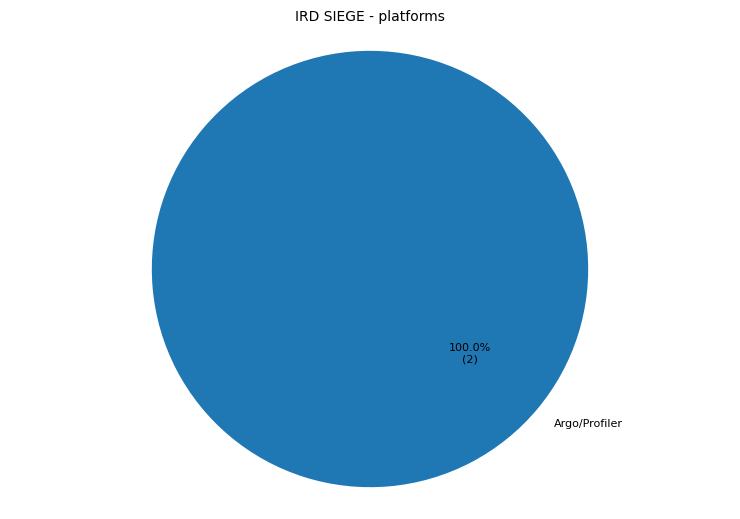

Saved: provider_pies/pie_ird-siege.png


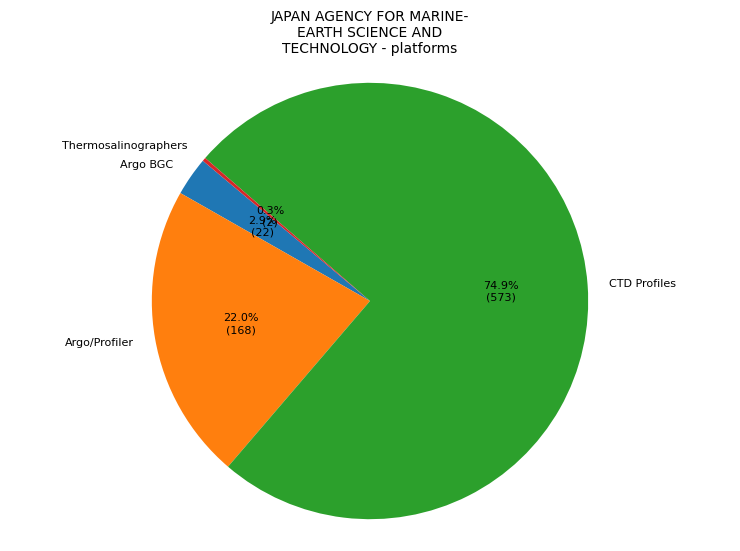

Saved: provider_pies/pie_japan-agency-for-marine-earth-science-and-technology.png


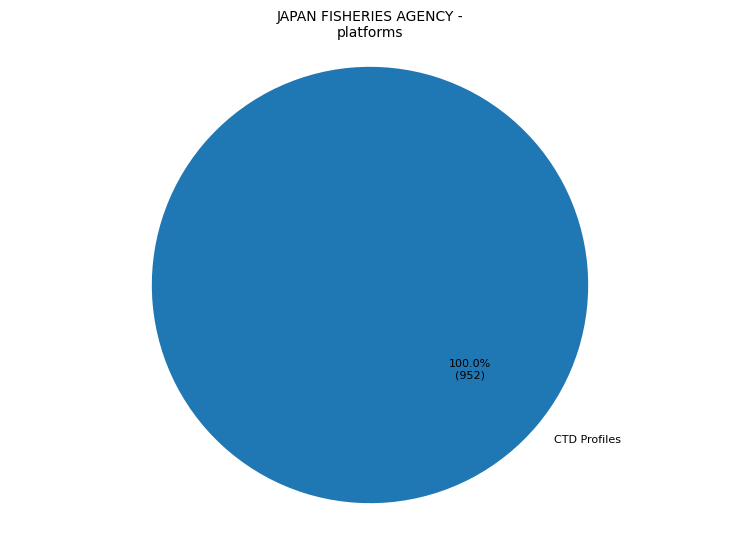

Saved: provider_pies/pie_japan-fisheries-agency.png


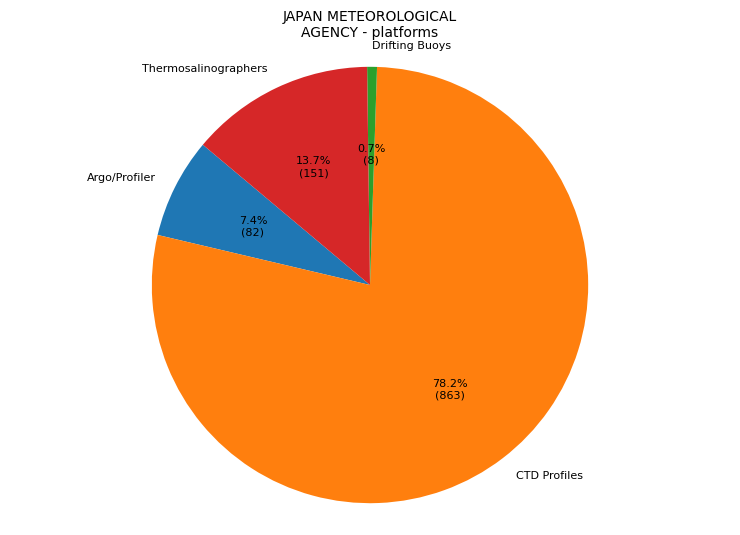

Saved: provider_pies/pie_japan-meteorological-agency.png


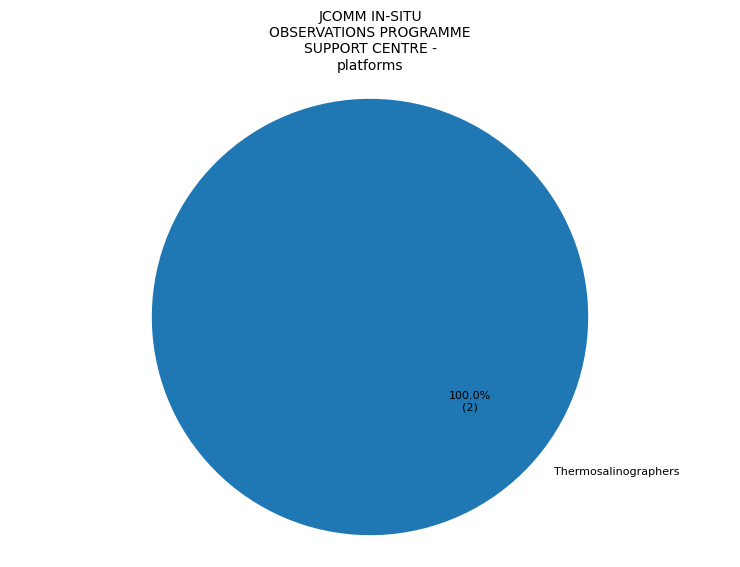

Saved: provider_pies/pie_jcomm-in-situ-observations-programme-support-centre.png


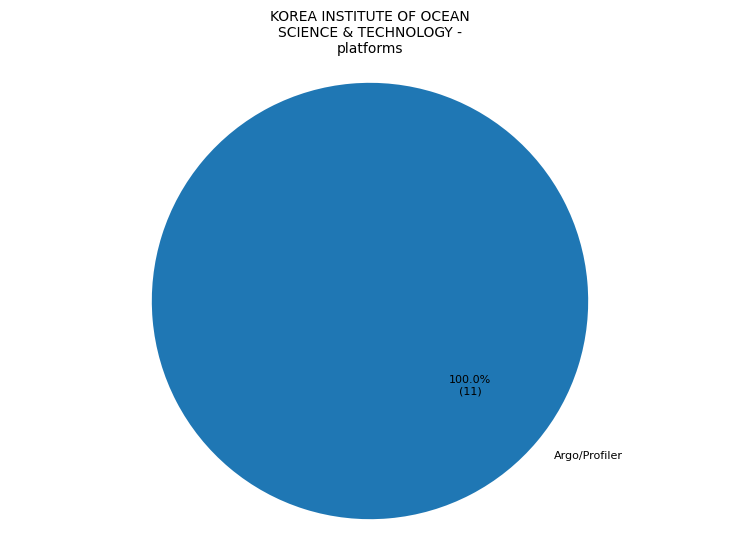

Saved: provider_pies/pie_korea-institute-of-ocean-science-technology.png


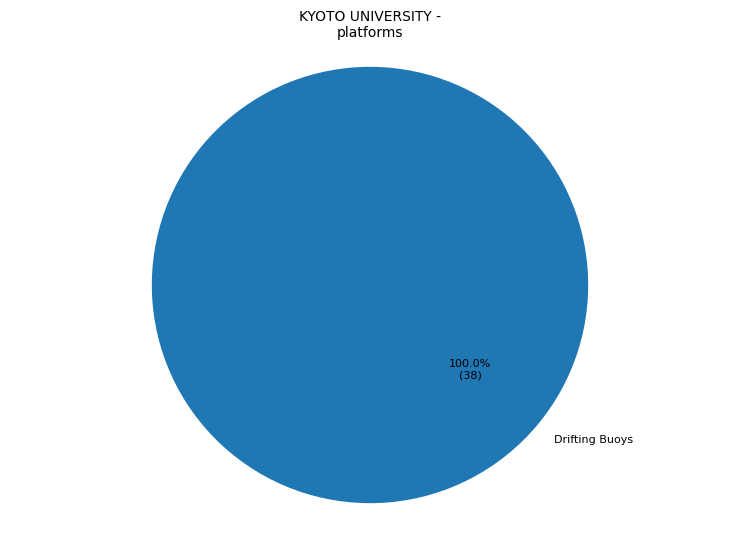

Saved: provider_pies/pie_kyoto-university.png


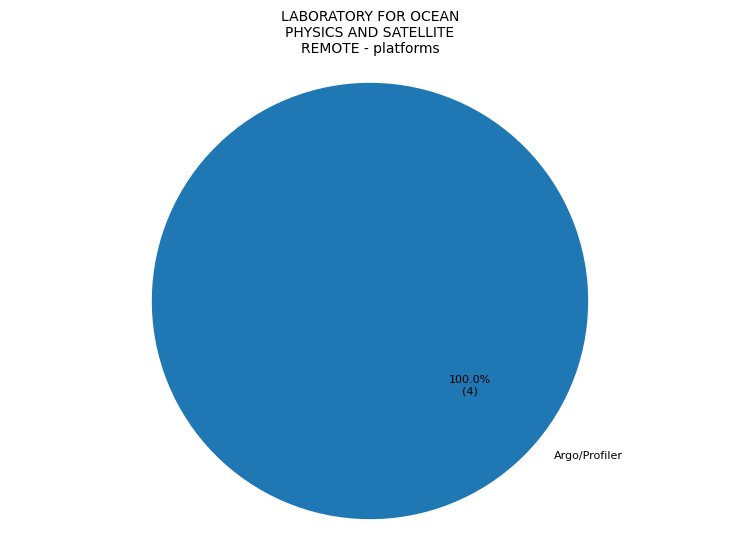

Saved: provider_pies/pie_laboratory-for-ocean-physics-and-satellite-remote.png


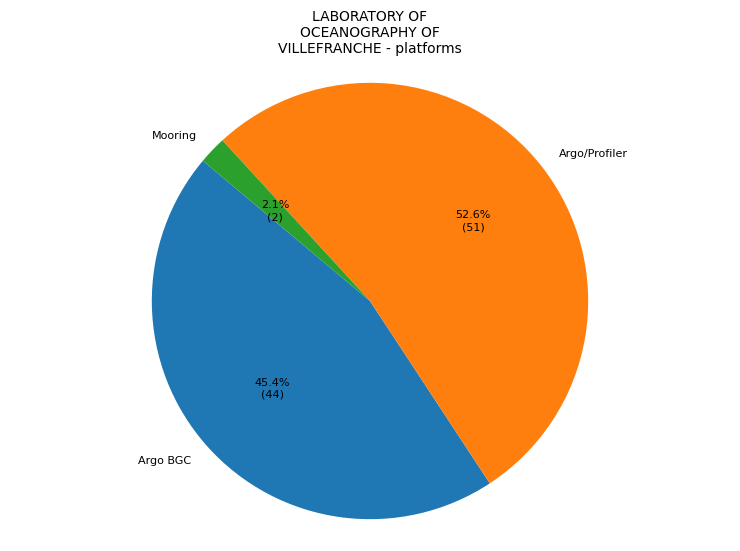

Saved: provider_pies/pie_laboratory-of-oceanography-of-villefranche.png


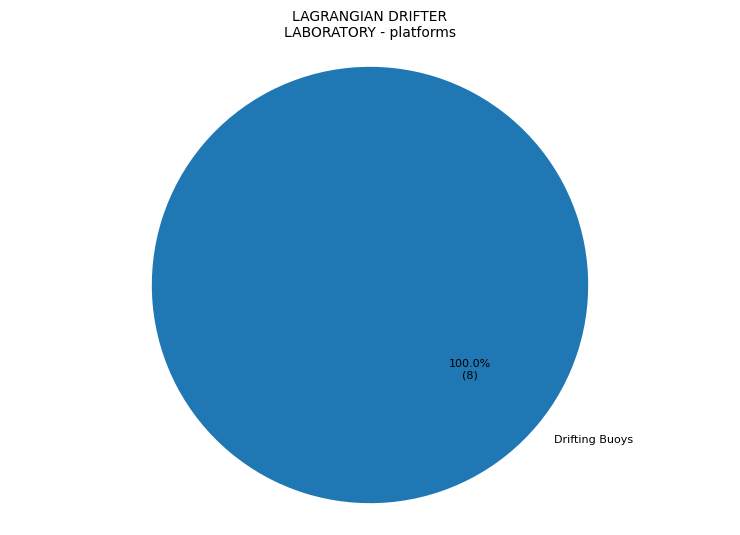

Saved: provider_pies/pie_lagrangian-drifter-laboratory.png


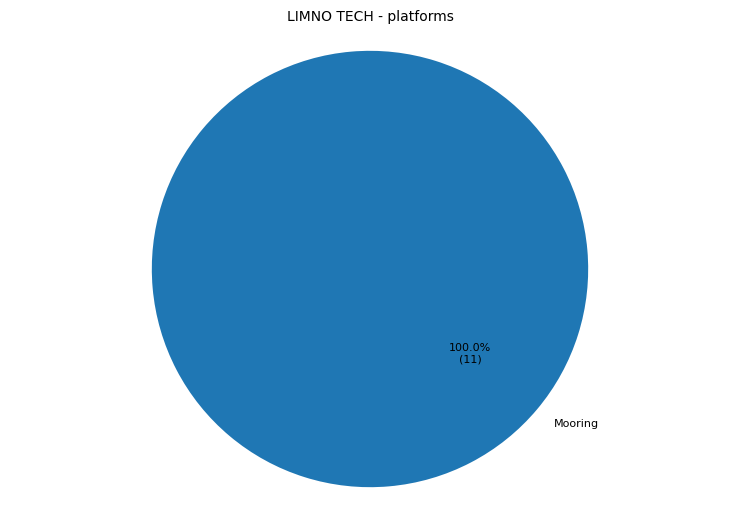

Saved: provider_pies/pie_limno-tech.png


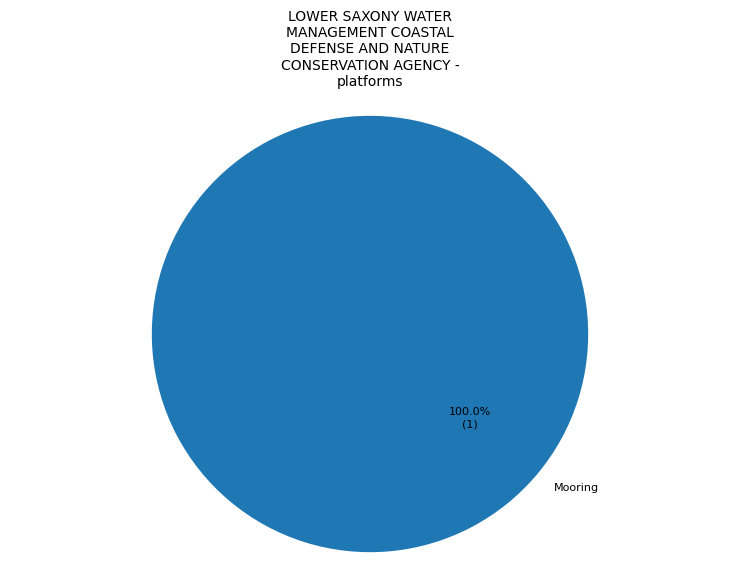

Saved: provider_pies/pie_lower-saxony-water-management-coastal-defense-and-nature-conservation-agency.png


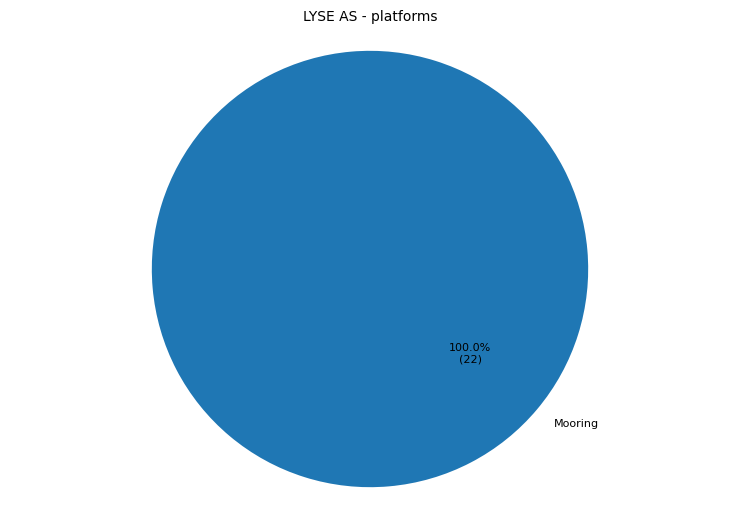

Saved: provider_pies/pie_lyse-as.png


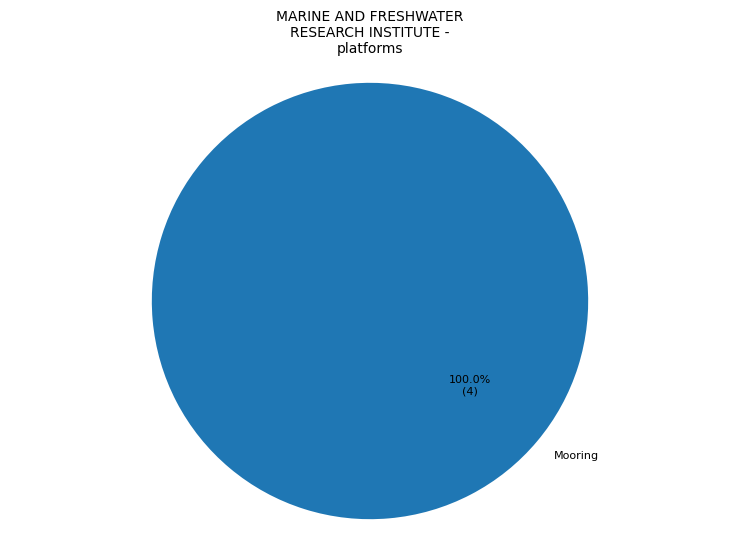

Saved: provider_pies/pie_marine-and-freshwater-research-institute.png


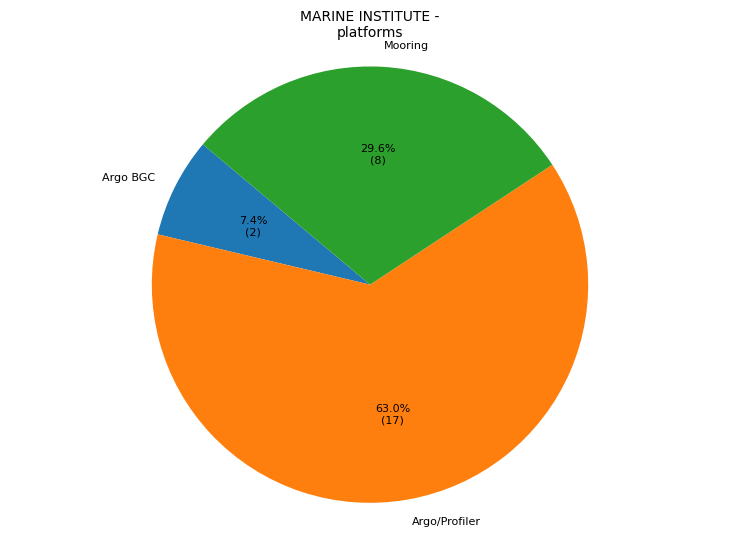

Saved: provider_pies/pie_marine-institute.png


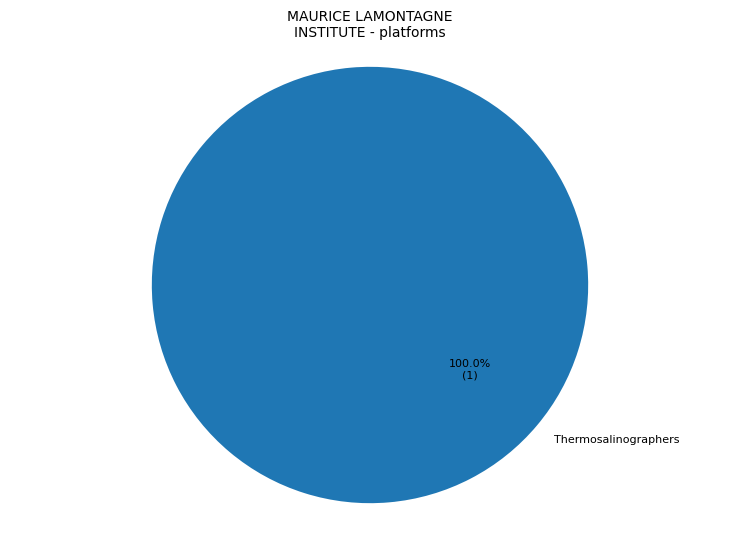

Saved: provider_pies/pie_maurice-lamontagne-institute.png


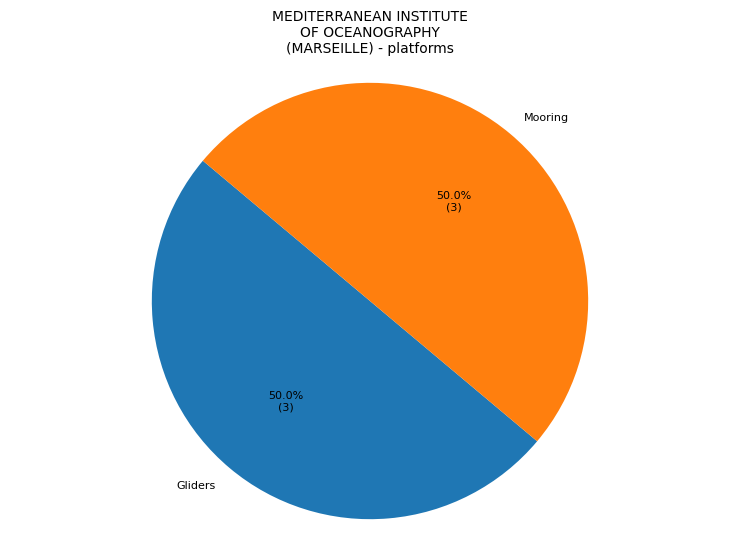

Saved: provider_pies/pie_mediterranean-institute-of-oceanography-marseille.png


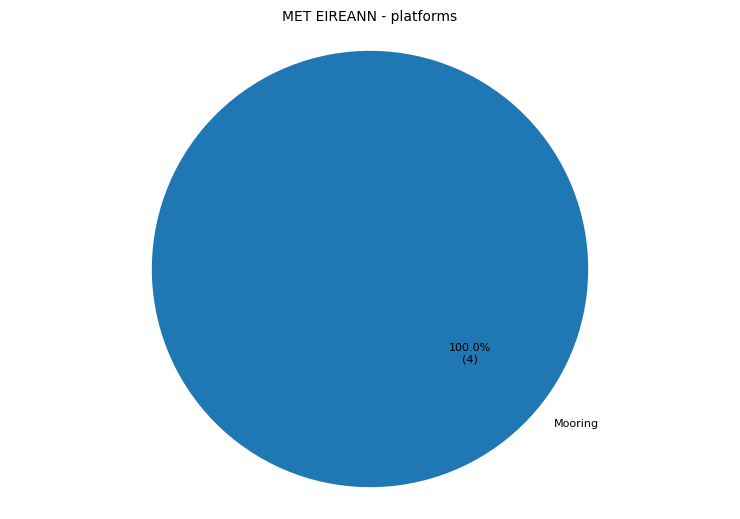

Saved: provider_pies/pie_met-eireann.png


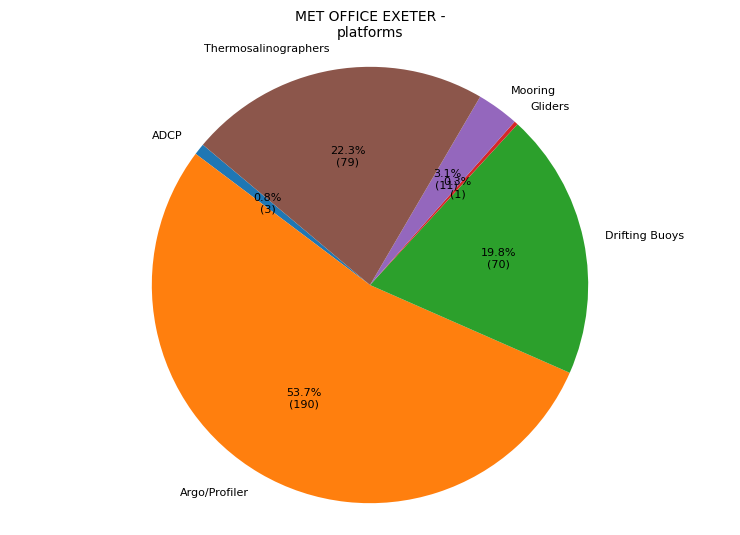

Saved: provider_pies/pie_met-office-exeter.png


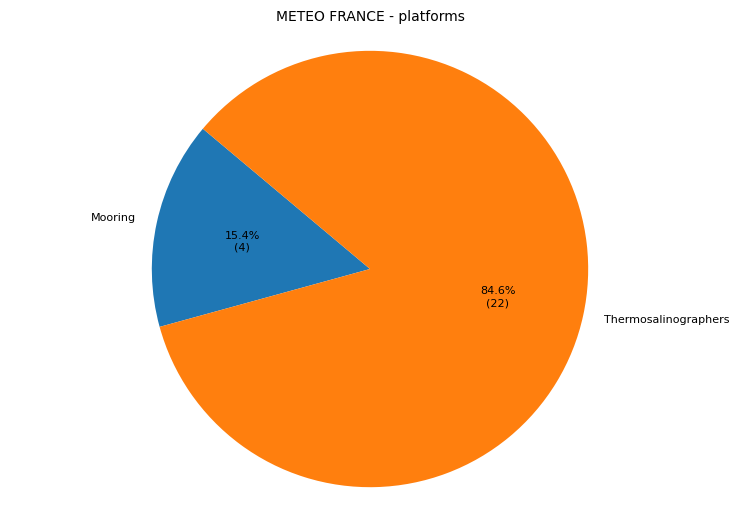

Saved: provider_pies/pie_meteo-france.png


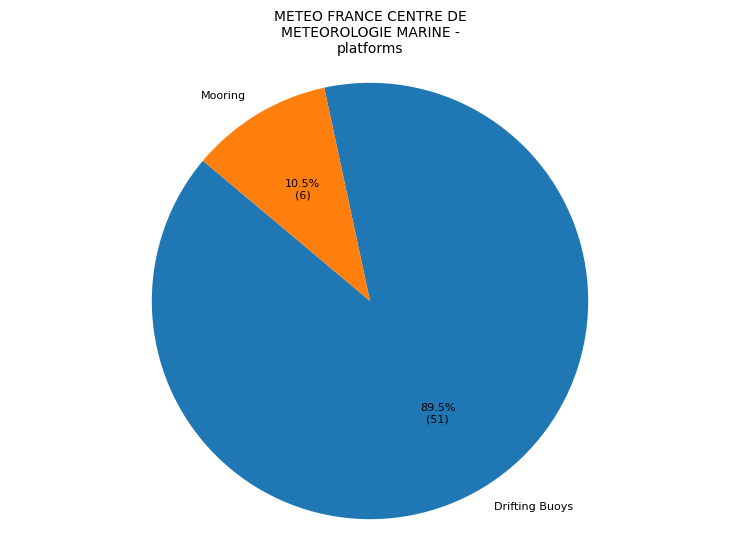

Saved: provider_pies/pie_meteo-france-centre-de-meteorologie-marine.png


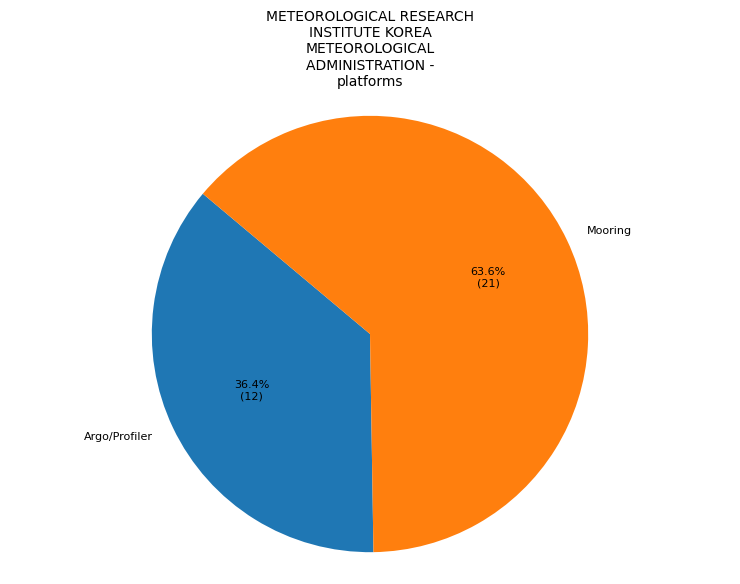

Saved: provider_pies/pie_meteorological-research-institute-korea-meteorological-administration.png


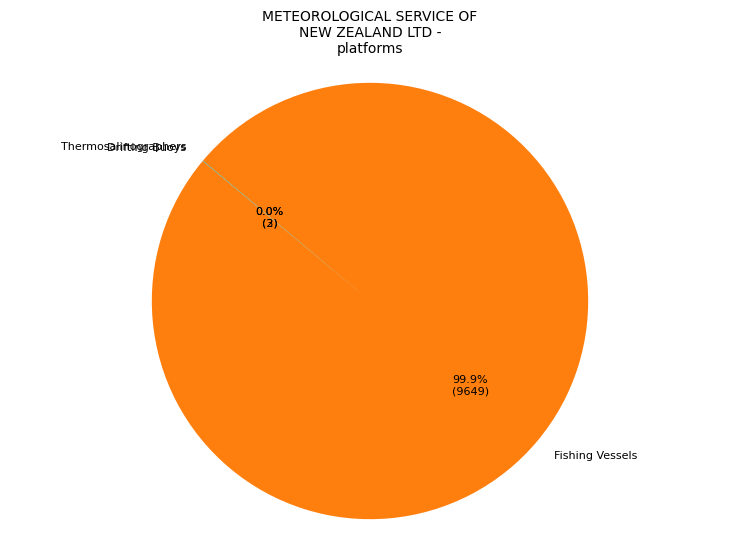

Saved: provider_pies/pie_meteorological-service-of-new-zealand-ltd.png


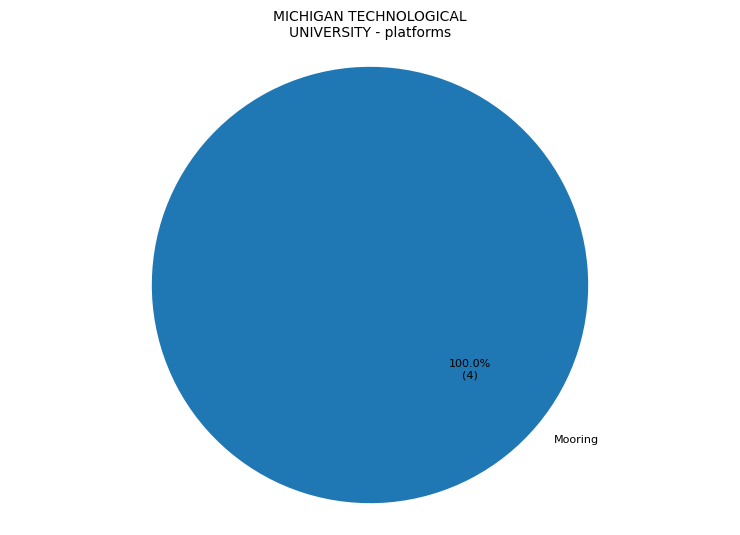

Saved: provider_pies/pie_michigan-technological-university.png


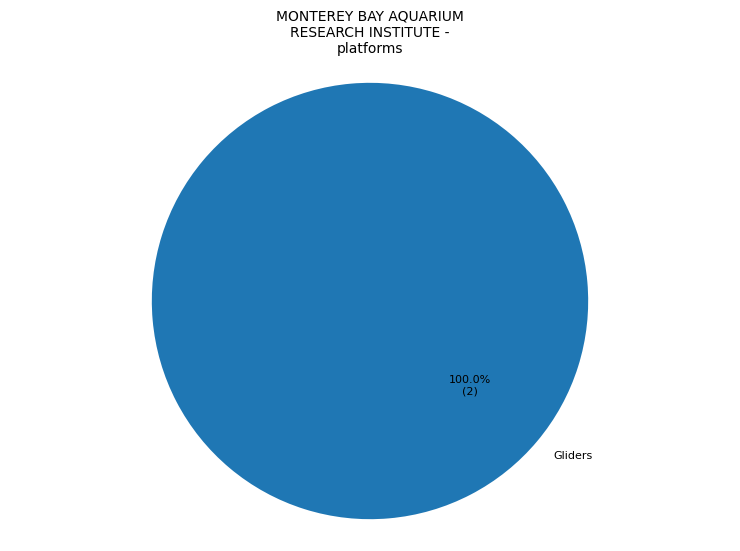

Saved: provider_pies/pie_monterey-bay-aquarium-research-institute.png


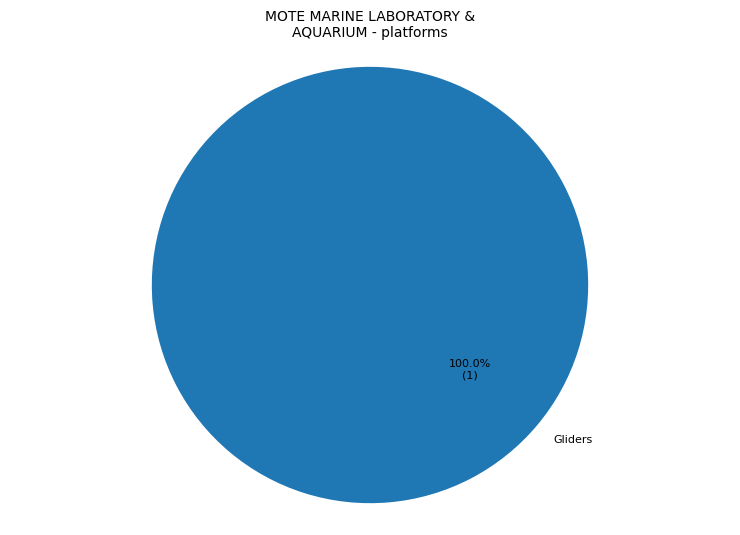

Saved: provider_pies/pie_mote-marine-laboratory-aquarium.png


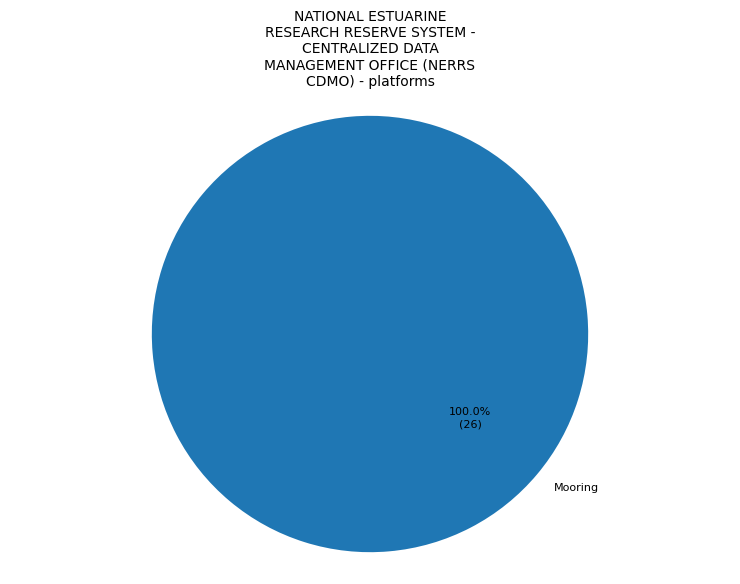

Saved: provider_pies/pie_national-estuarine-research-reserve-system-centralized-data-management-office-nerrs-cdmo.png


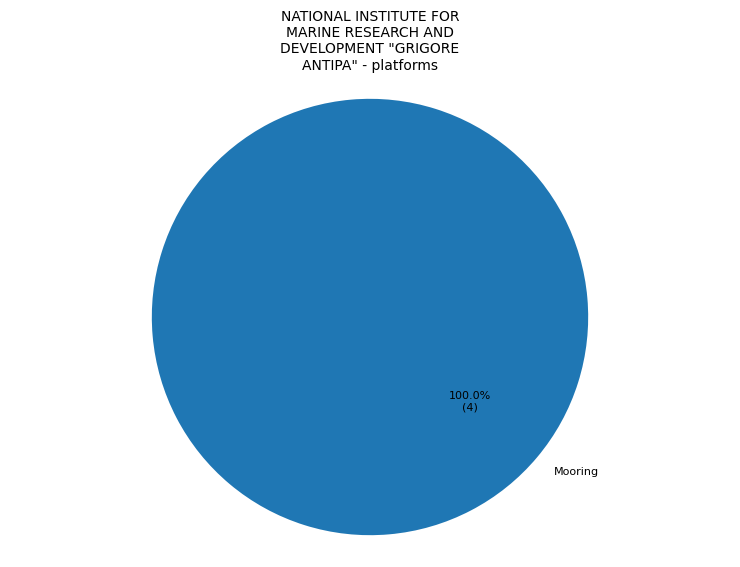

Saved: provider_pies/pie_national-institute-for-marine-research-and-development-grigore-antipa.png


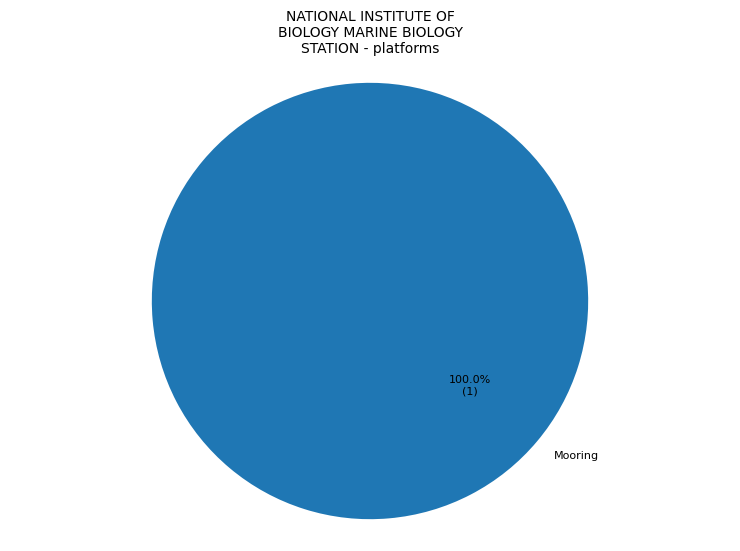

Saved: provider_pies/pie_national-institute-of-biology-marine-biology-station.png


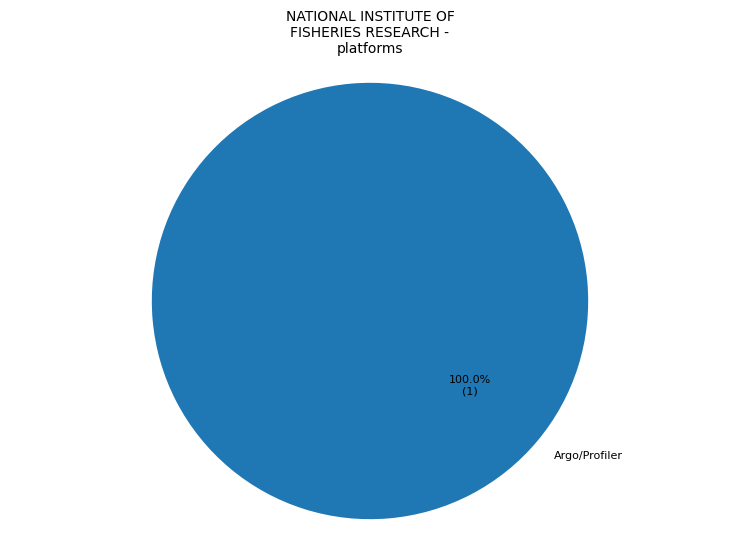

Saved: provider_pies/pie_national-institute-of-fisheries-research.png


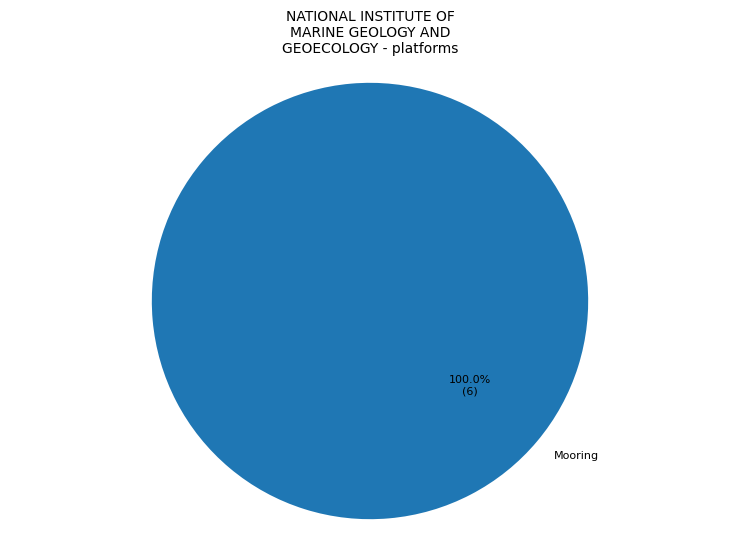

Saved: provider_pies/pie_national-institute-of-marine-geology-and-geoecology.png


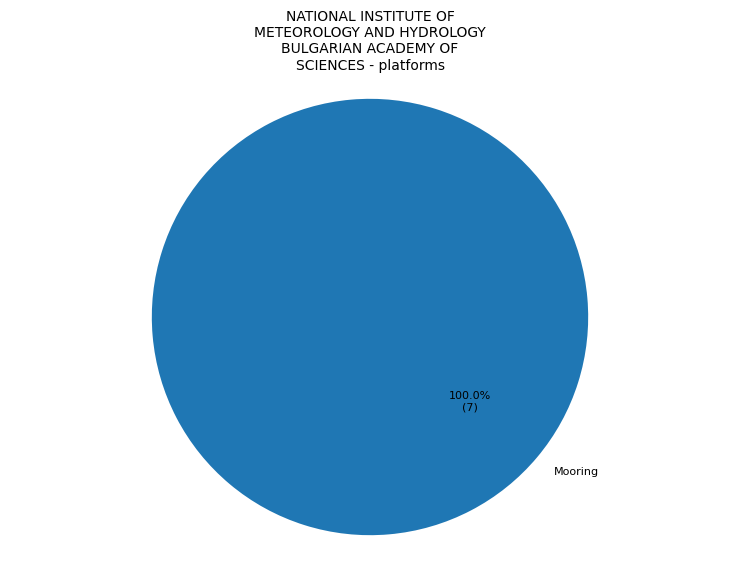

Saved: provider_pies/pie_national-institute-of-meteorology-and-hydrology-bulgarian-academy-of-sciences.png


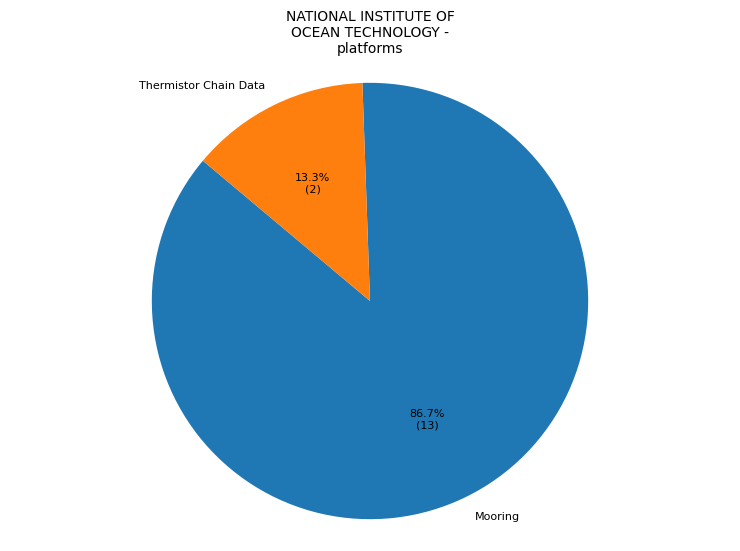

Saved: provider_pies/pie_national-institute-of-ocean-technology.png


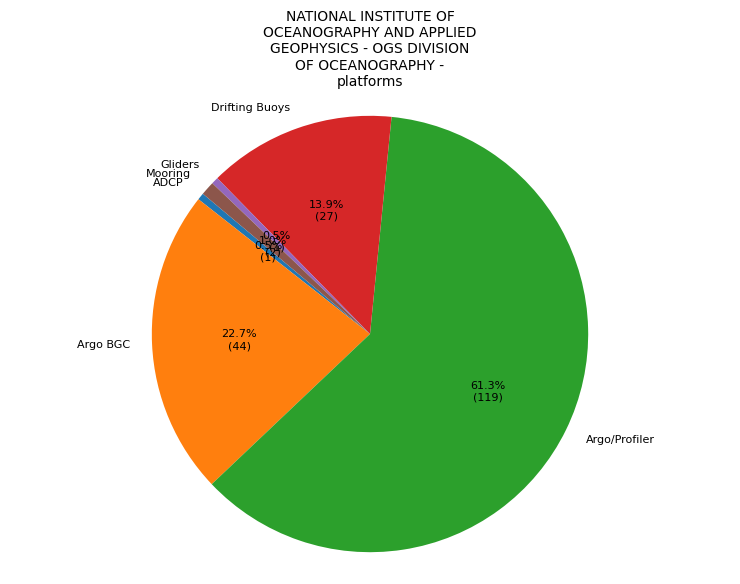

Saved: provider_pies/pie_national-institute-of-oceanography-and-applied-geophysics-ogs-division-of-oceanography.png


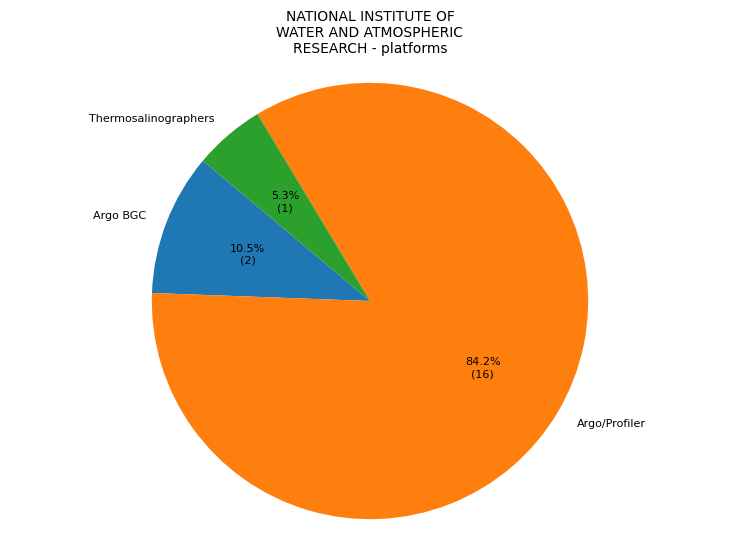

Saved: provider_pies/pie_national-institute-of-water-and-atmospheric-research.png


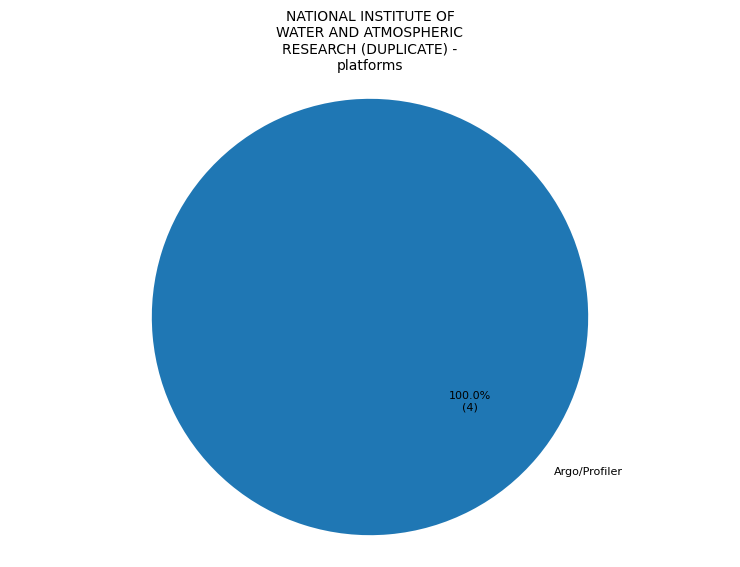

Saved: provider_pies/pie_national-institute-of-water-and-atmospheric-research-duplicate.png


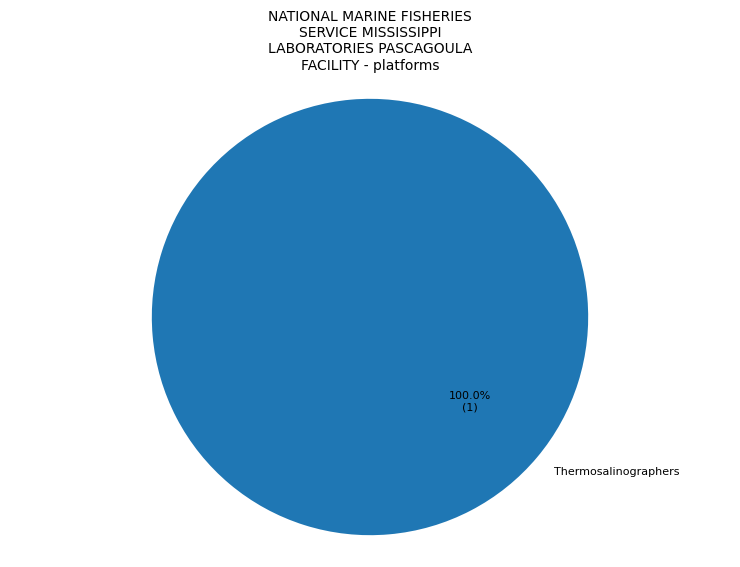

Saved: provider_pies/pie_national-marine-fisheries-service-mississippi-laboratories-pascagoula-facility.png


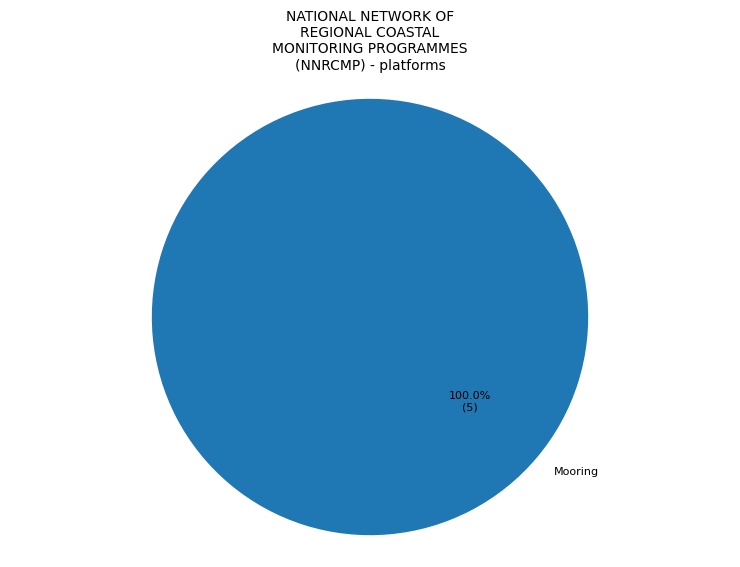

Saved: provider_pies/pie_national-network-of-regional-coastal-monitoring-programmes-nnrcmp.png


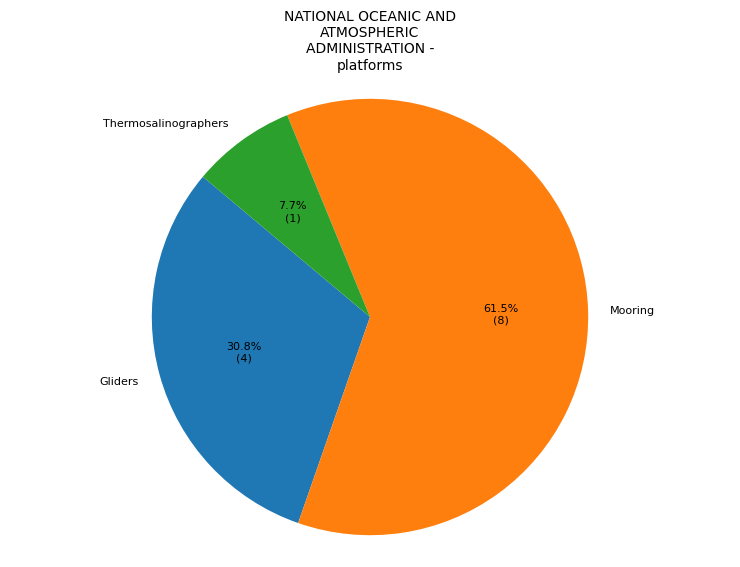

Saved: provider_pies/pie_national-oceanic-and-atmospheric-administration.png


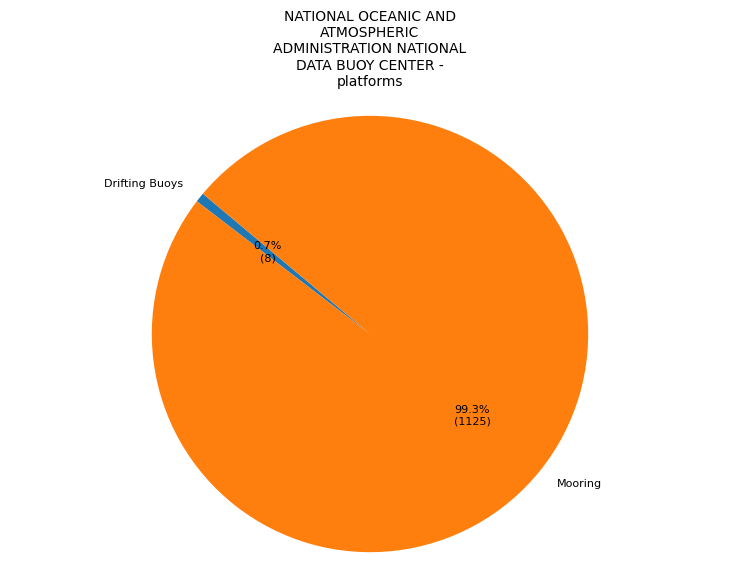

Saved: provider_pies/pie_national-oceanic-and-atmospheric-administration-national-data-buoy-center.png


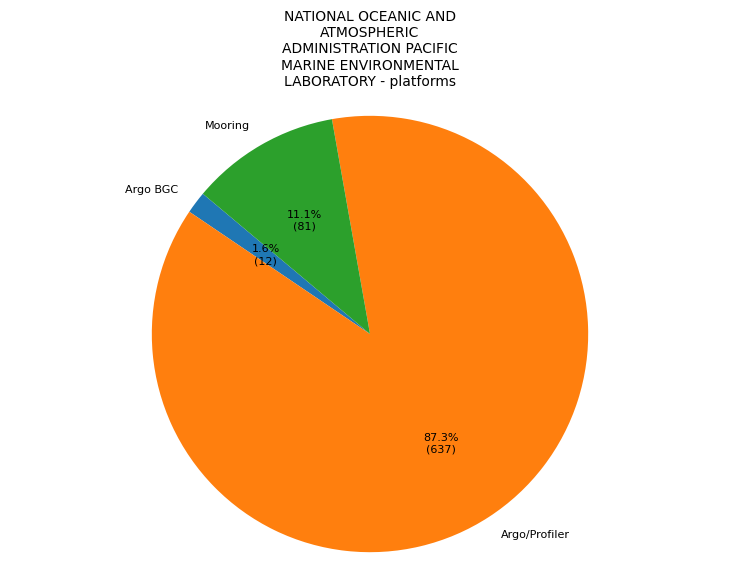

Saved: provider_pies/pie_national-oceanic-and-atmospheric-administration-pacific-marine-environmental-laboratory.png


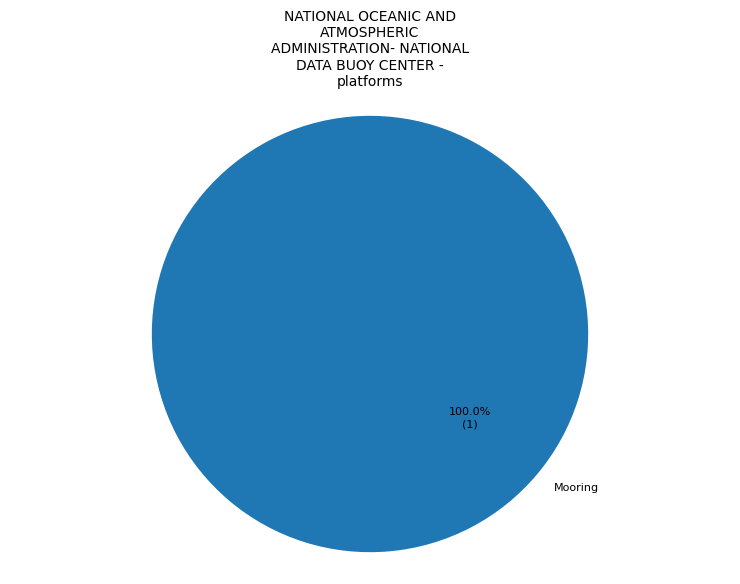

Saved: provider_pies/pie_national-oceanic-and-atmospheric-administration-national-data-buoy-center.png


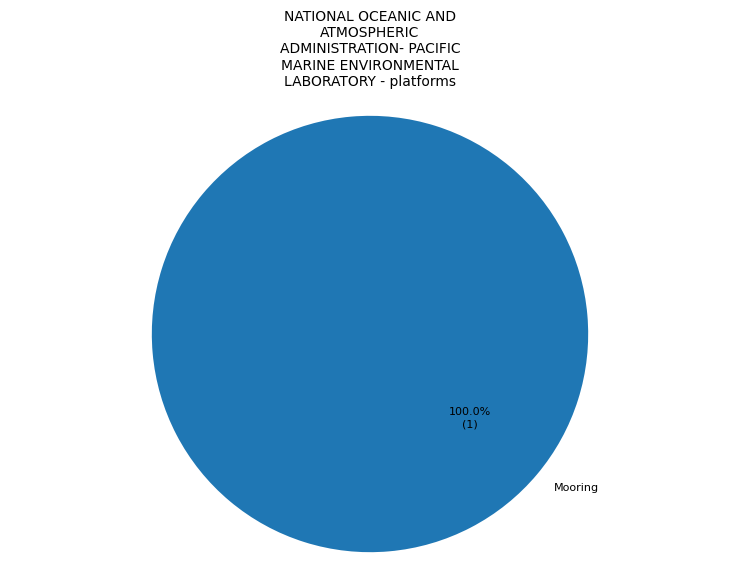

Saved: provider_pies/pie_national-oceanic-and-atmospheric-administration-pacific-marine-environmental-laboratory.png


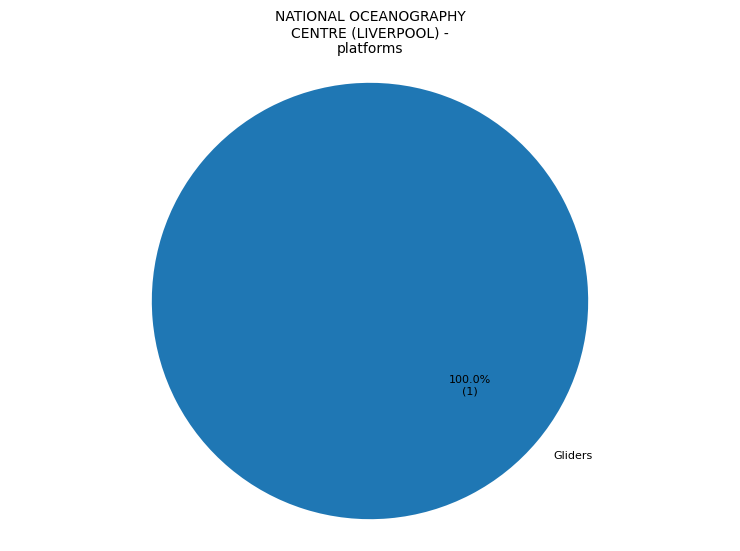

Saved: provider_pies/pie_national-oceanography-centre-liverpool.png


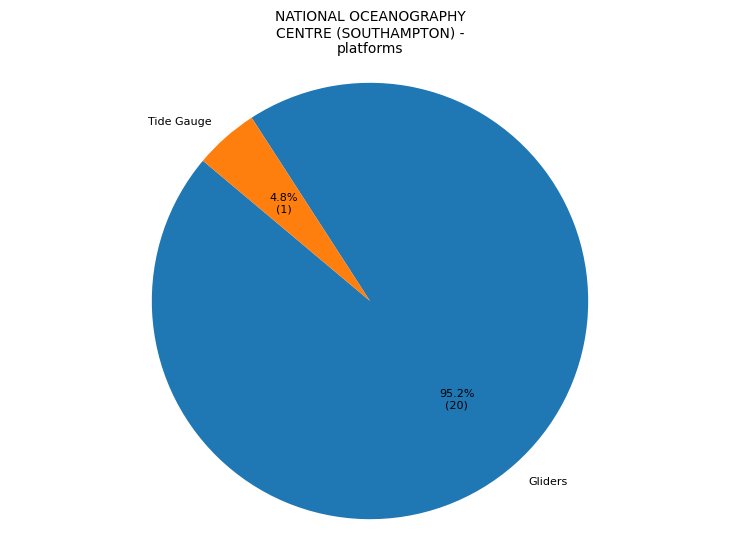

Saved: provider_pies/pie_national-oceanography-centre-southampton.png


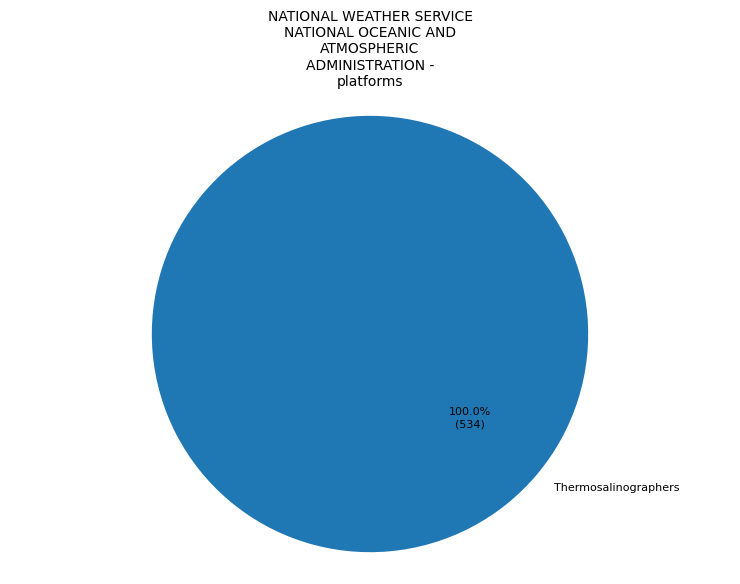

Saved: provider_pies/pie_national-weather-service-national-oceanic-and-atmospheric-administration.png


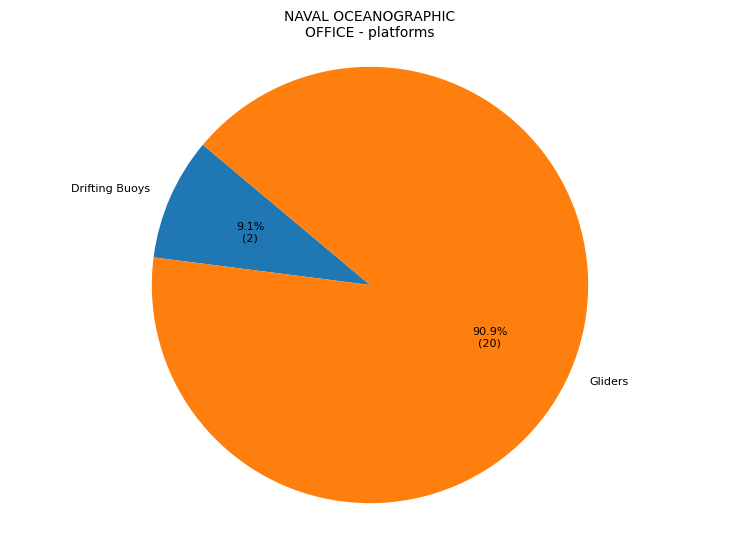

Saved: provider_pies/pie_naval-oceanographic-office.png


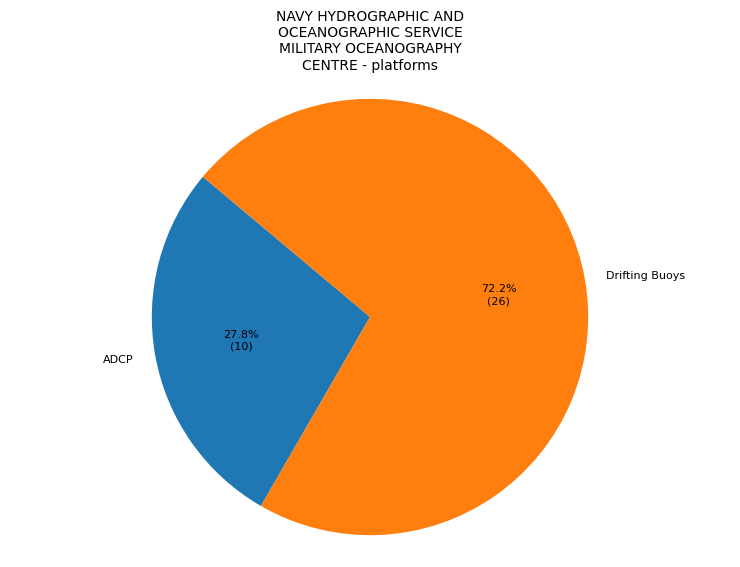

Saved: provider_pies/pie_navy-hydrographic-and-oceanographic-service-military-oceanography-centre.png


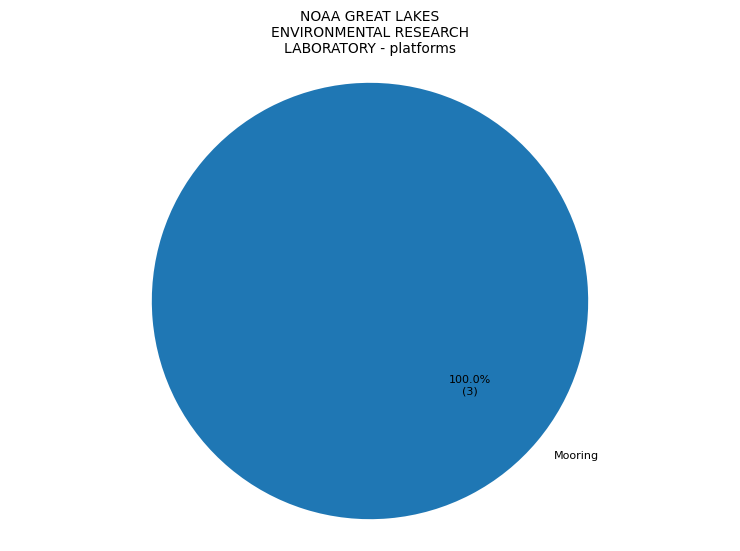

Saved: provider_pies/pie_noaa-great-lakes-environmental-research-laboratory.png


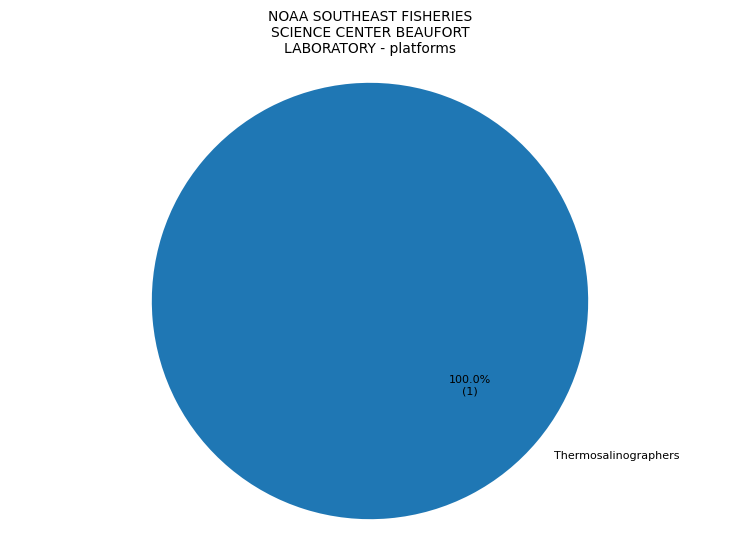

Saved: provider_pies/pie_noaa-southeast-fisheries-science-center-beaufort-laboratory.png


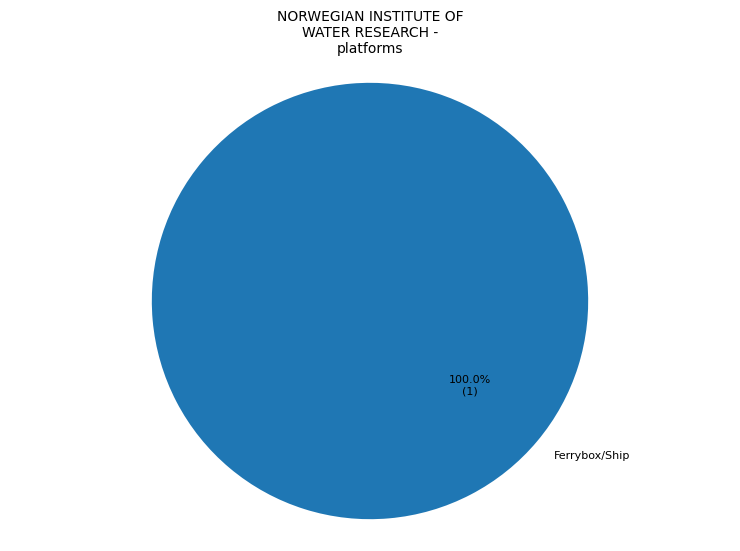

Saved: provider_pies/pie_norwegian-institute-of-water-research.png


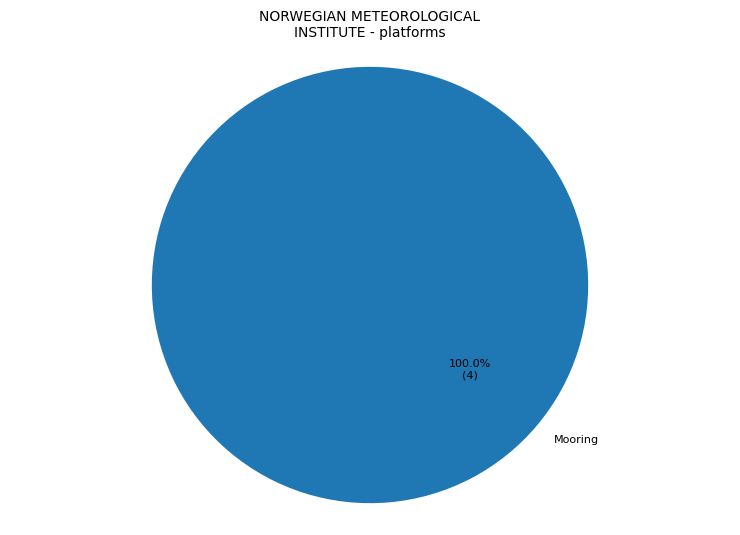

Saved: provider_pies/pie_norwegian-meteorological-institute.png


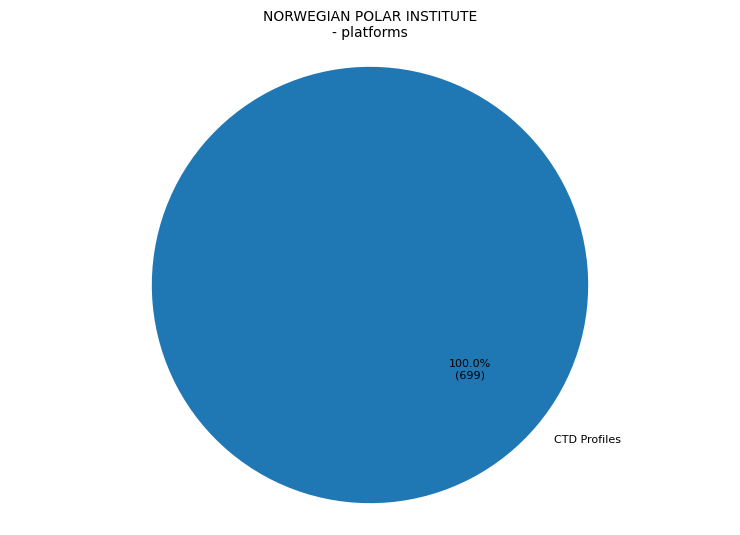

Saved: provider_pies/pie_norwegian-polar-institute.png


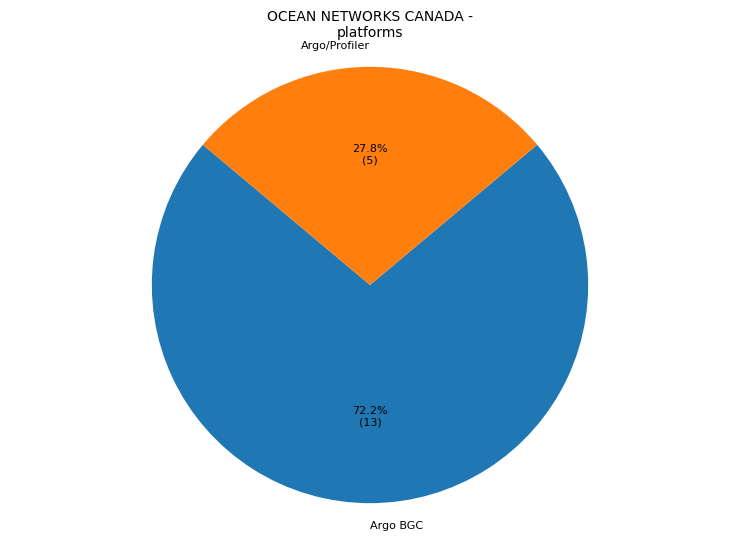

Saved: provider_pies/pie_ocean-networks-canada.png


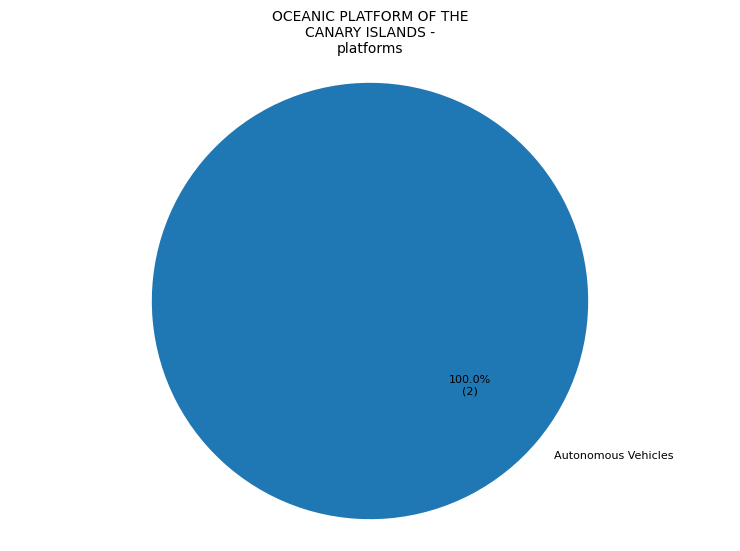

Saved: provider_pies/pie_oceanic-platform-of-the-canary-islands.png


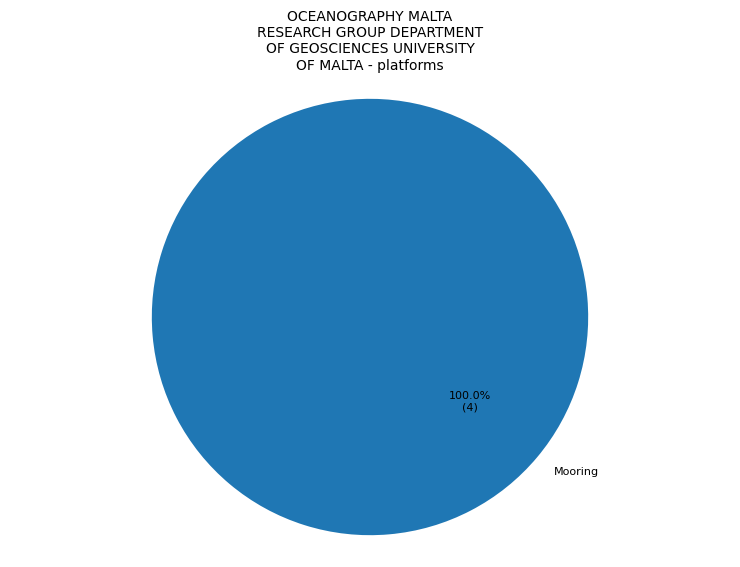

Saved: provider_pies/pie_oceanography-malta-research-group-department-of-geosciences-university-of-malta.png


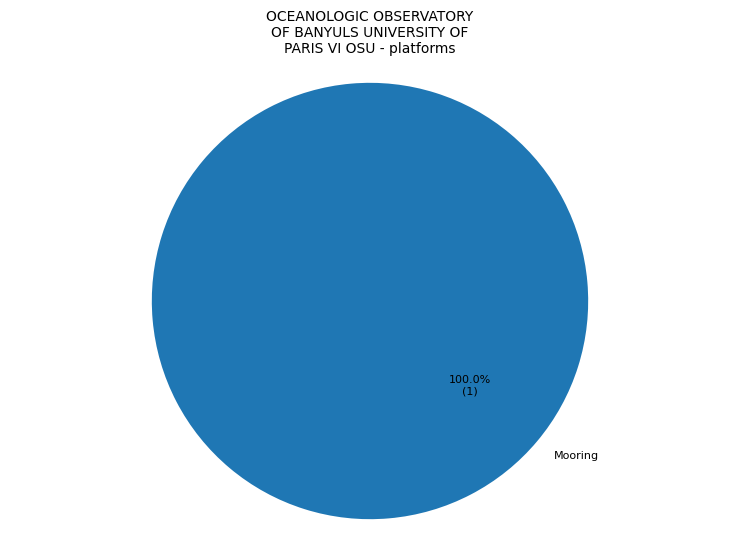

Saved: provider_pies/pie_oceanologic-observatory-of-banyuls-university-of-paris-vi-osu.png


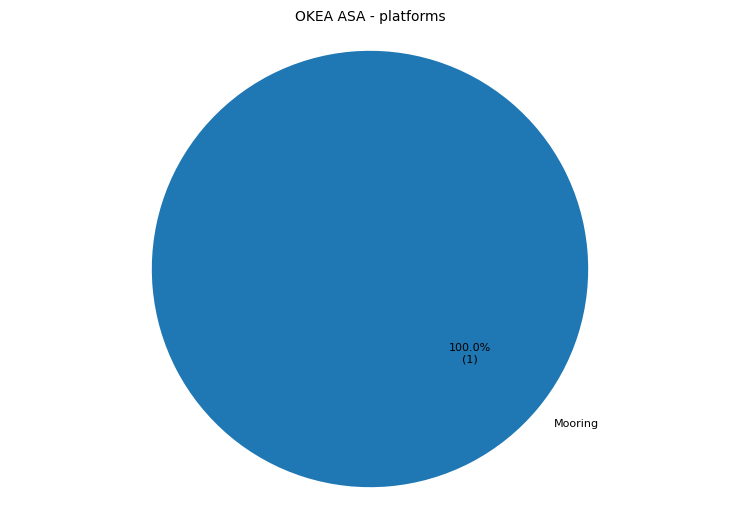

Saved: provider_pies/pie_okea-asa.png


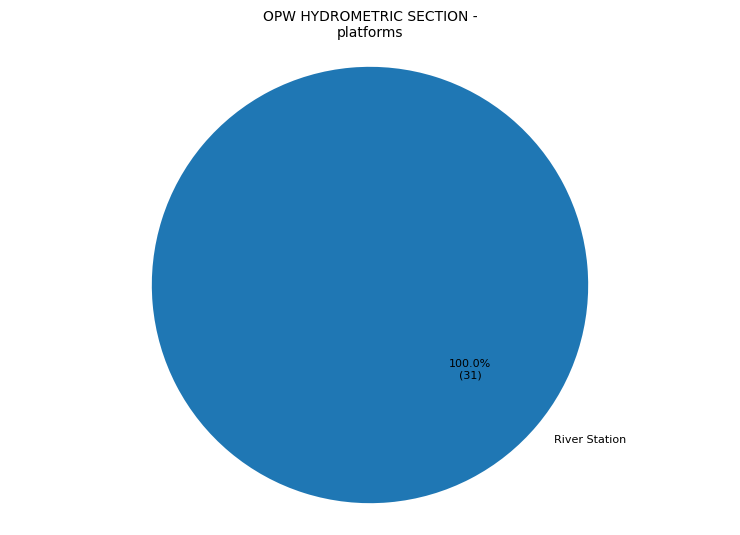

Saved: provider_pies/pie_opw-hydrometric-section.png


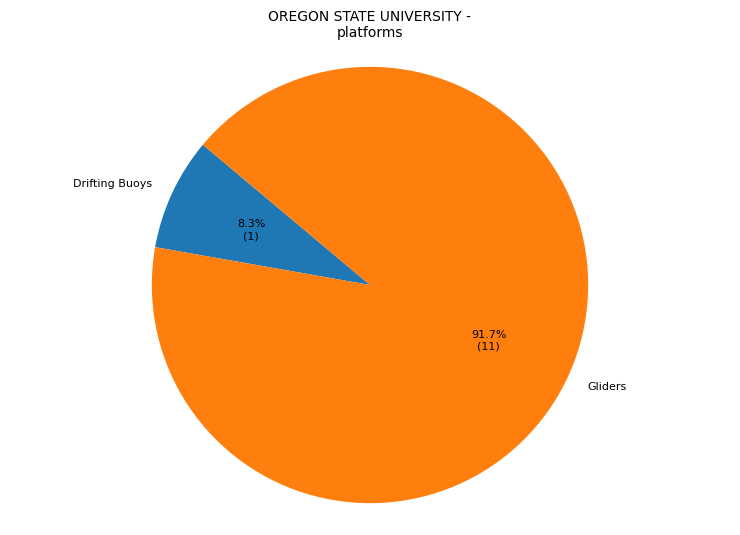

Saved: provider_pies/pie_oregon-state-university.png


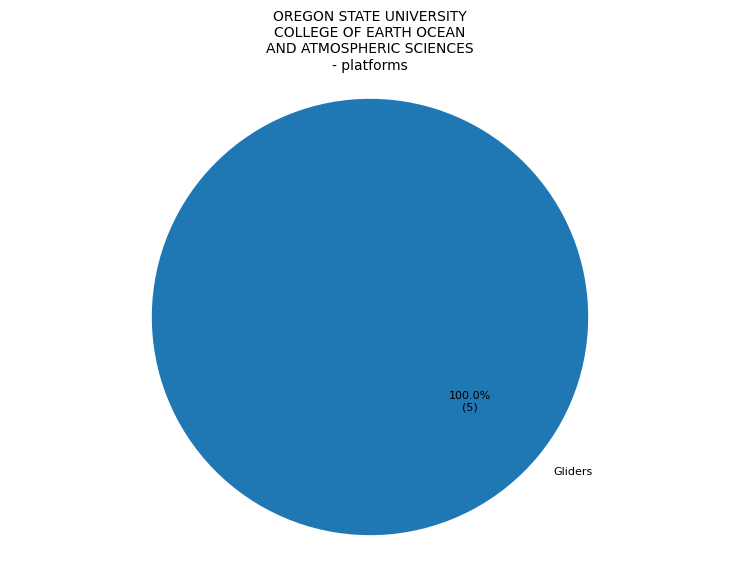

Saved: provider_pies/pie_oregon-state-university-college-of-earth-ocean-and-atmospheric-sciences.png


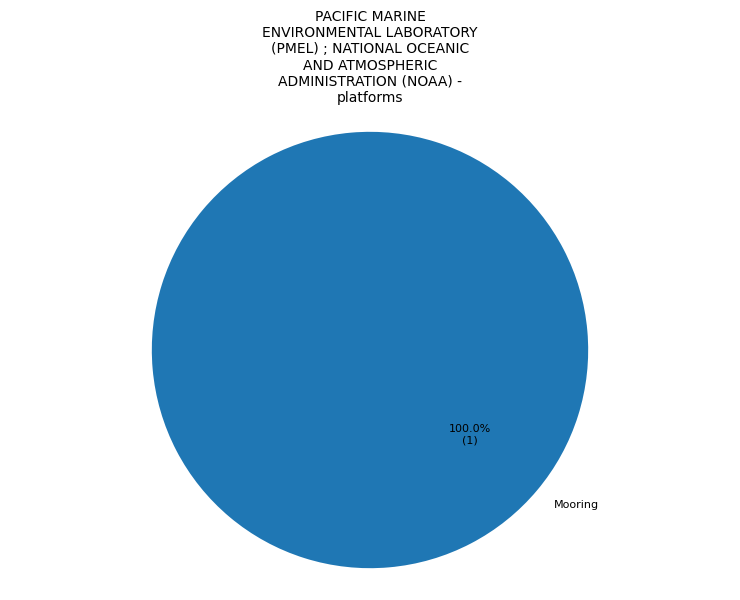

Saved: provider_pies/pie_pacific-marine-environmental-laboratory-pmel-national-oceanic-and-atmospheric-administration-noaa.png


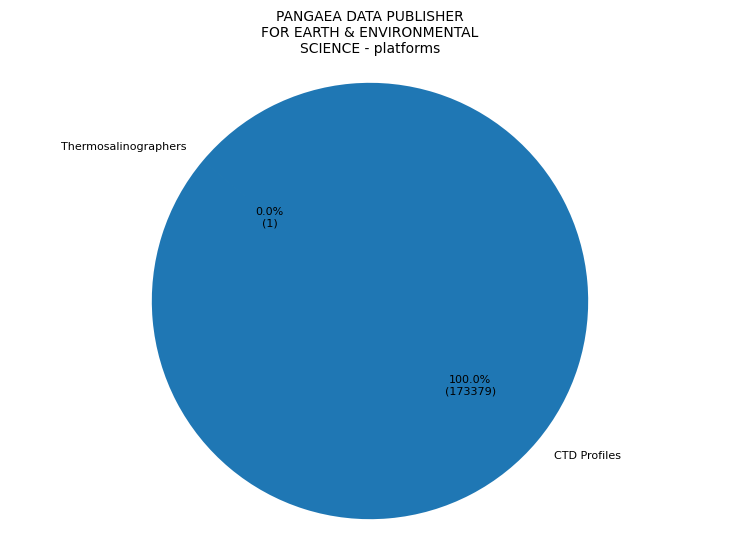

Saved: provider_pies/pie_pangaea-data-publisher-for-earth-environmental-science.png


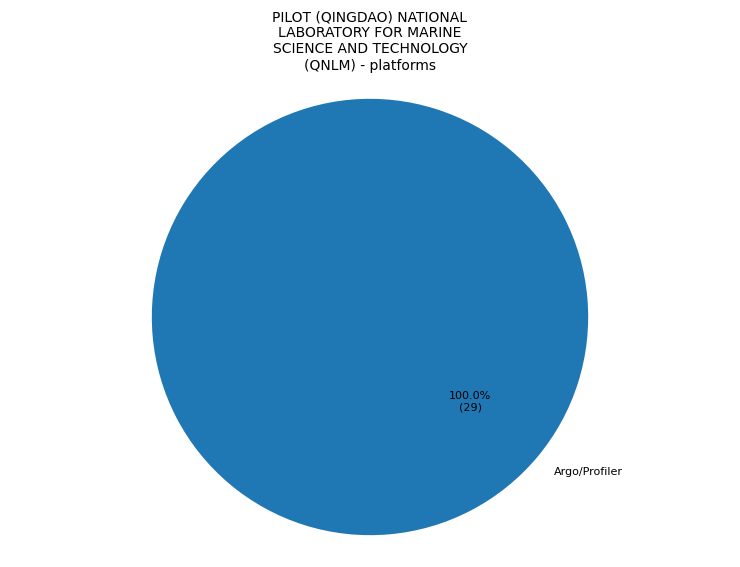

Saved: provider_pies/pie_pilot-qingdao-national-laboratory-for-marine-science-and-technology-qnlm.png


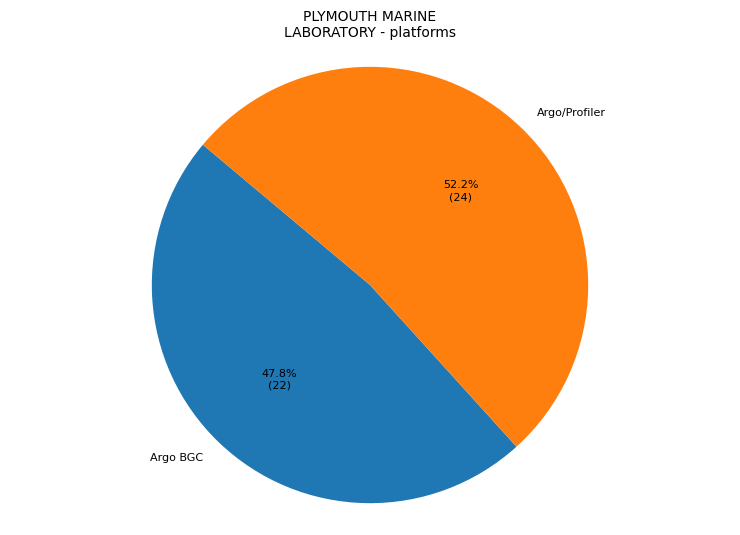

Saved: provider_pies/pie_plymouth-marine-laboratory.png


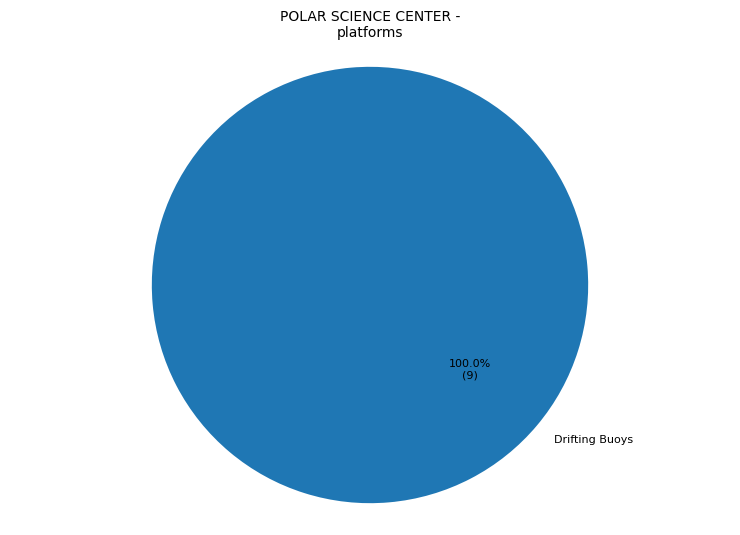

Saved: provider_pies/pie_polar-science-center.png


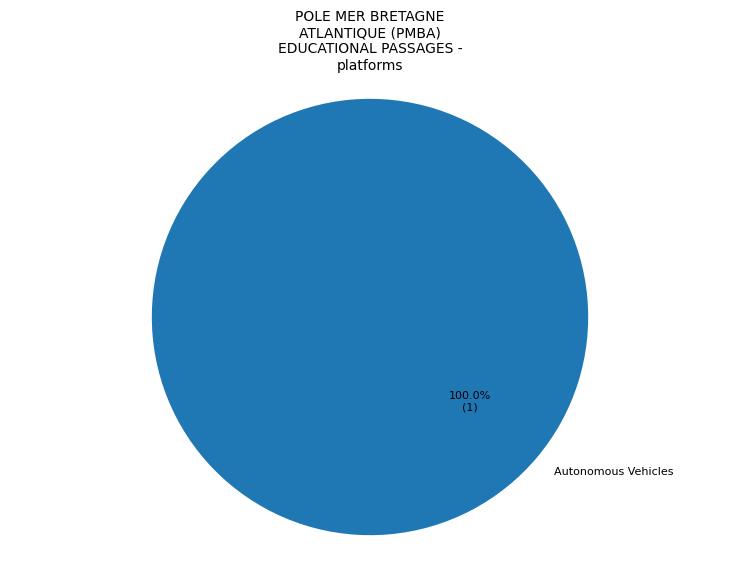

Saved: provider_pies/pie_pole-mer-bretagne-atlantique-pmba-educational-passages.png


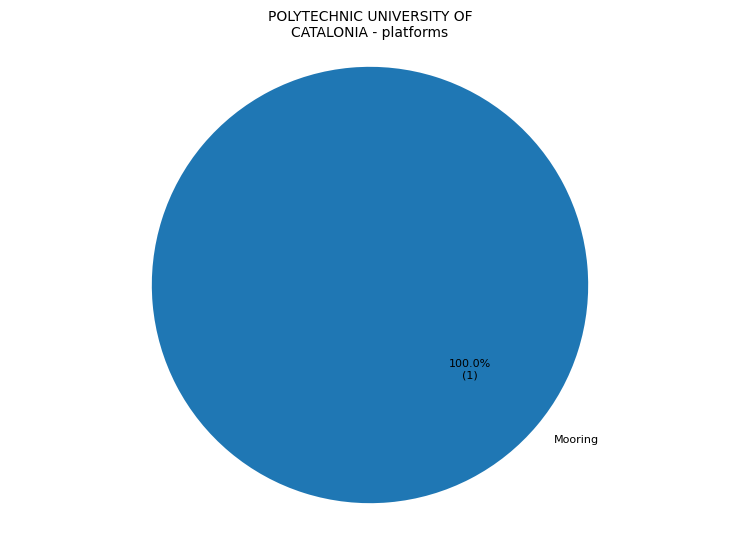

Saved: provider_pies/pie_polytechnic-university-of-catalonia.png


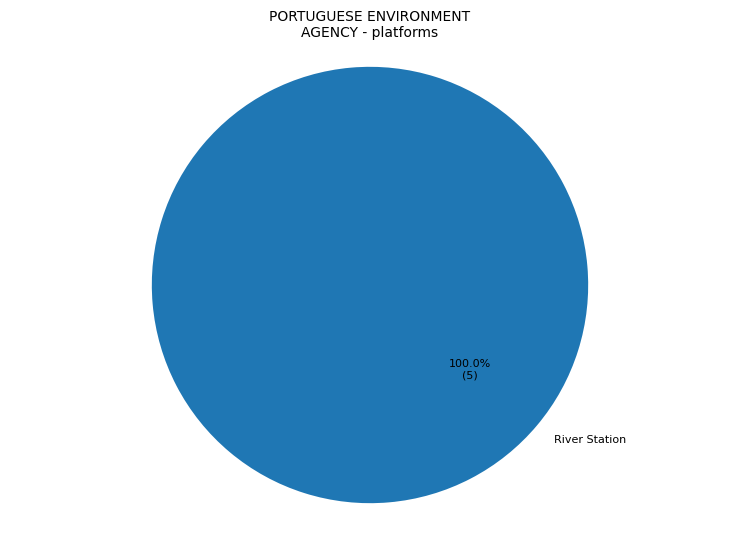

Saved: provider_pies/pie_portuguese-environment-agency.png


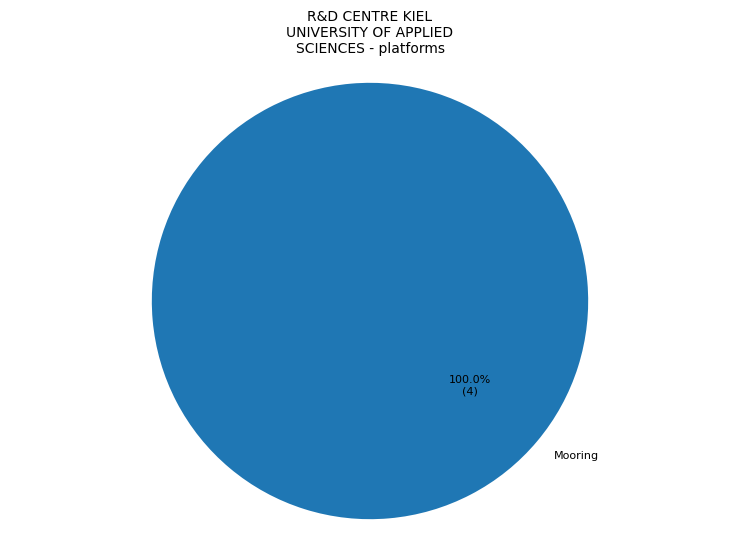

Saved: provider_pies/pie_r-d-centre-kiel-university-of-applied-sciences.png


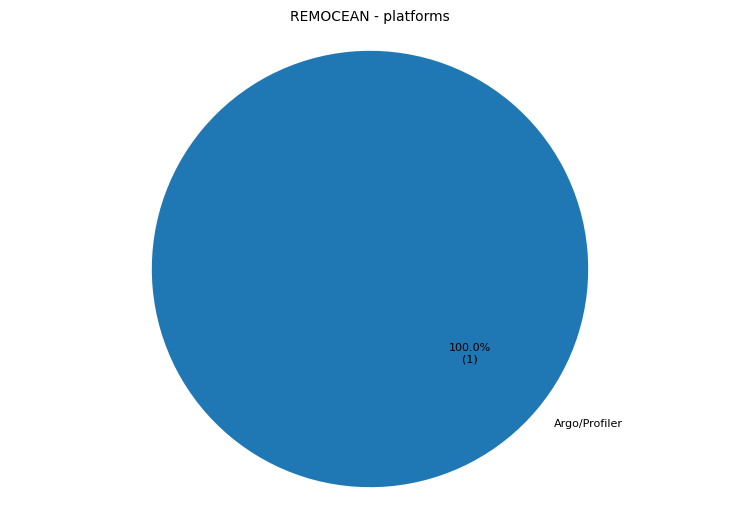

Saved: provider_pies/pie_remocean.png


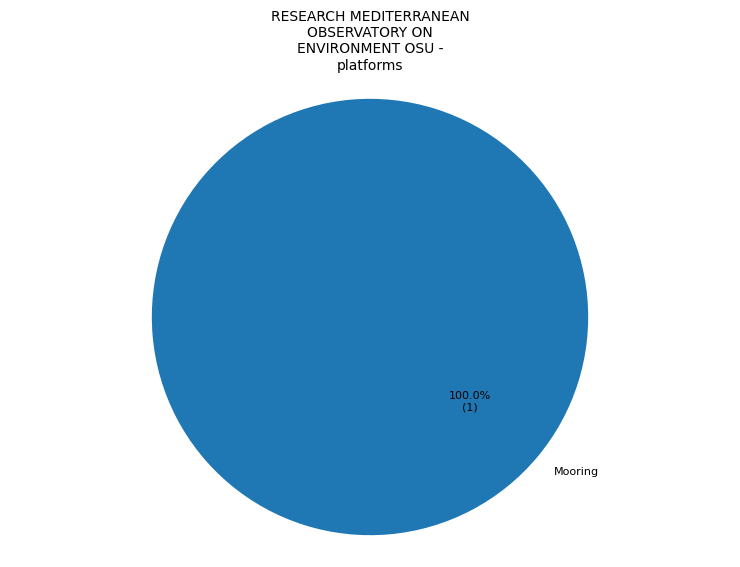

Saved: provider_pies/pie_research-mediterranean-observatory-on-environment-osu.png


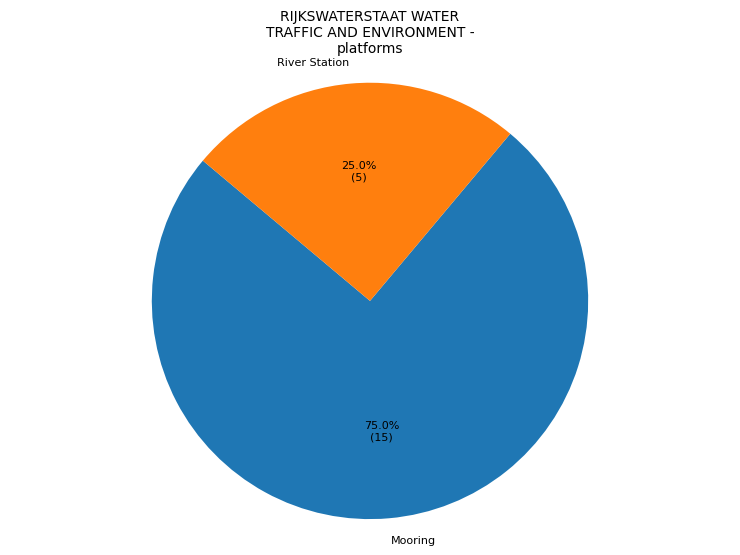

Saved: provider_pies/pie_rijkswaterstaat-water-traffic-and-environment.png


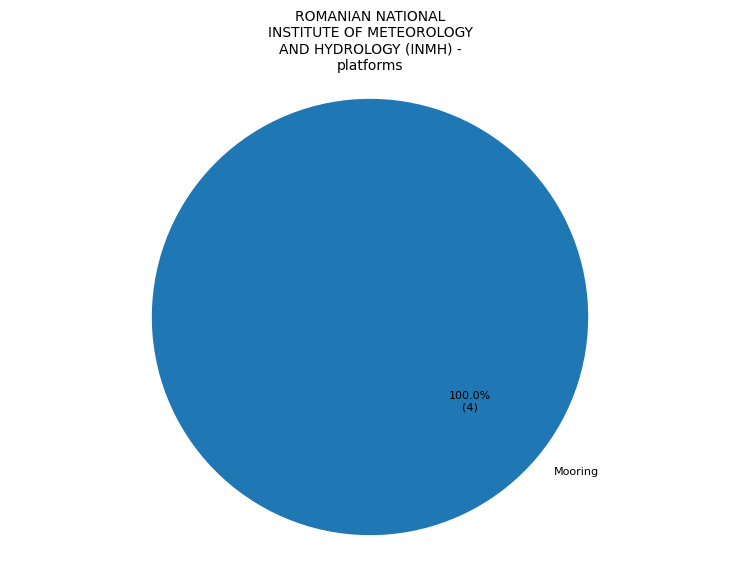

Saved: provider_pies/pie_romanian-national-institute-of-meteorology-and-hydrology-inmh.png


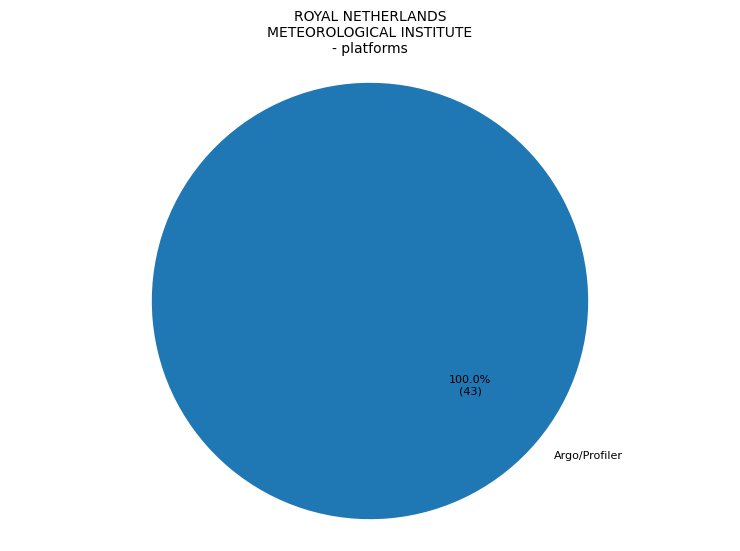

Saved: provider_pies/pie_royal-netherlands-meteorological-institute.png


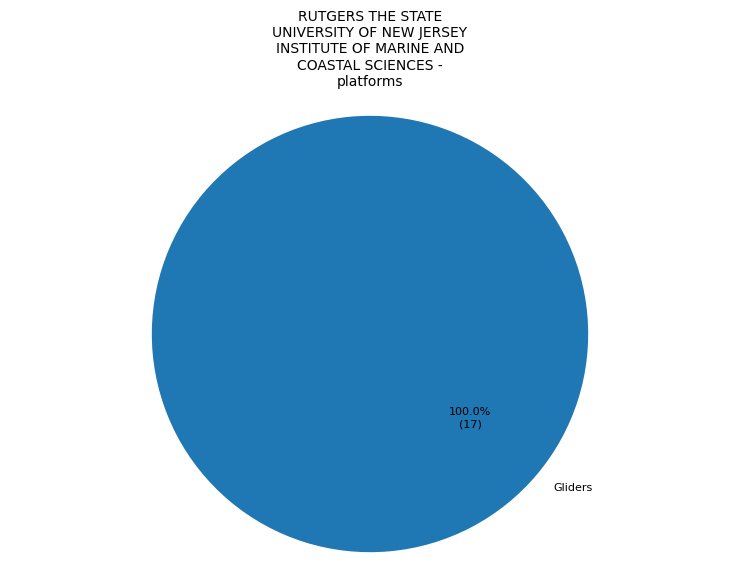

Saved: provider_pies/pie_rutgers-the-state-university-of-new-jersey-institute-of-marine-and-coastal-sciences.png


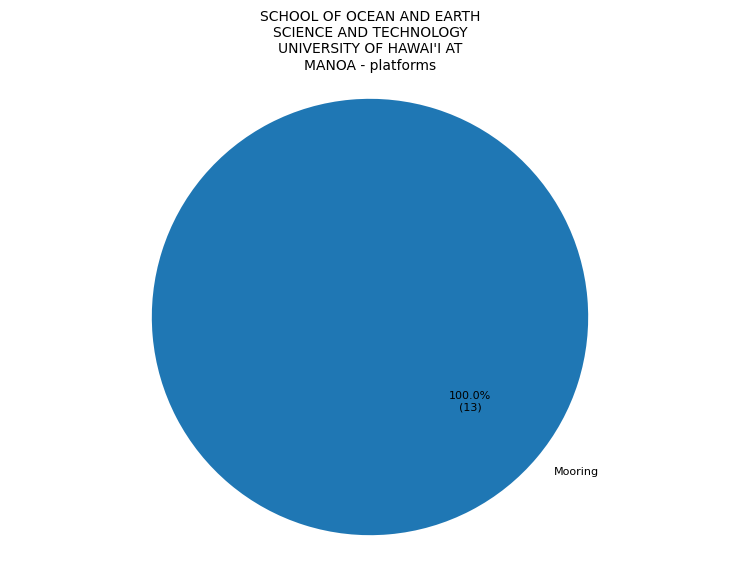

Saved: provider_pies/pie_school-of-ocean-and-earth-science-and-technology-university-of-hawai-i-at-manoa.png


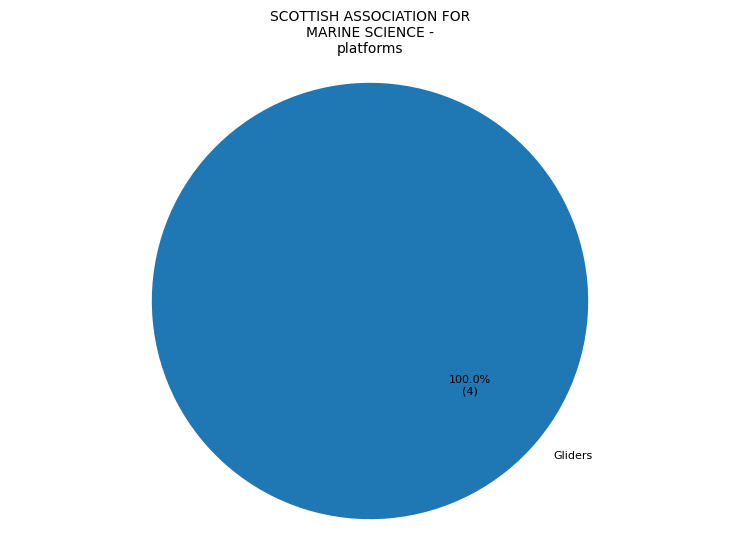

Saved: provider_pies/pie_scottish-association-for-marine-science.png


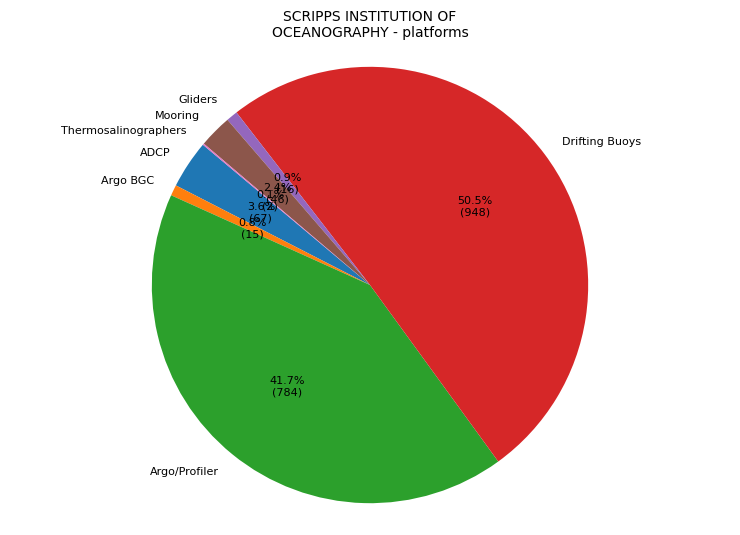

Saved: provider_pies/pie_scripps-institution-of-oceanography.png


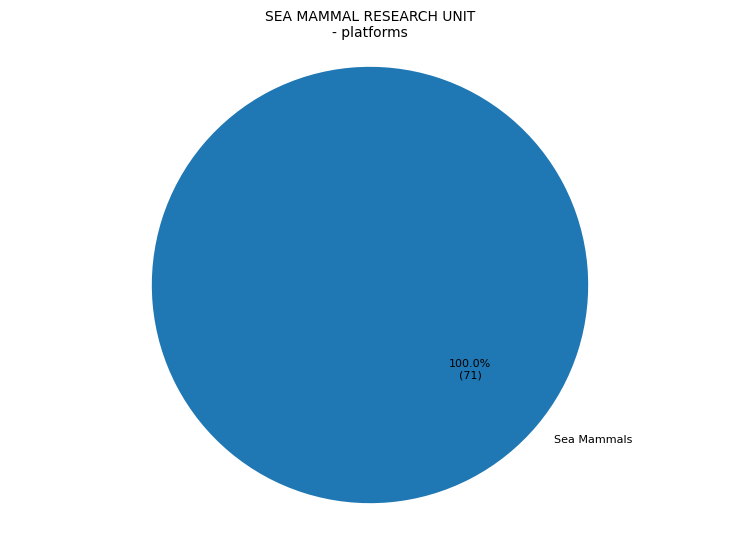

Saved: provider_pies/pie_sea-mammal-research-unit.png


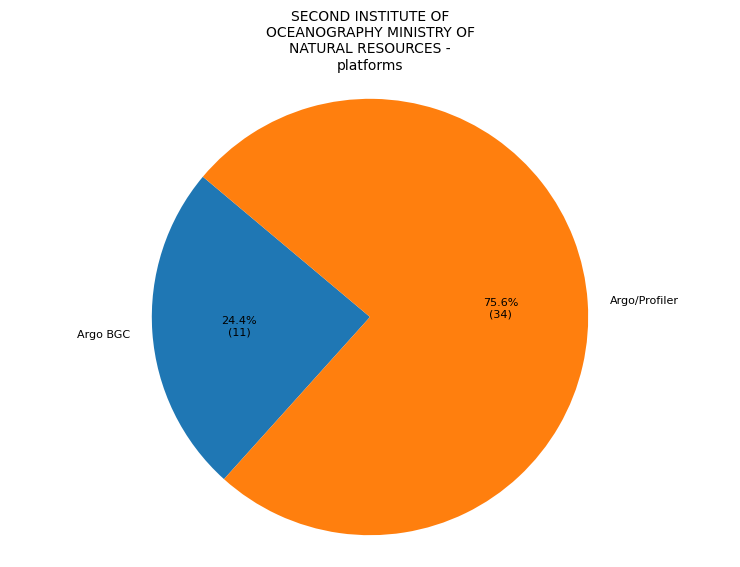

Saved: provider_pies/pie_second-institute-of-oceanography-ministry-of-natural-resources.png


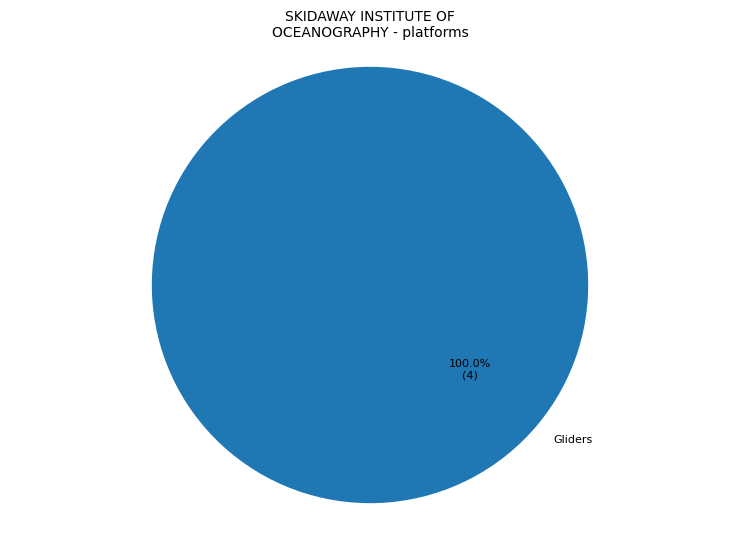

Saved: provider_pies/pie_skidaway-institute-of-oceanography.png


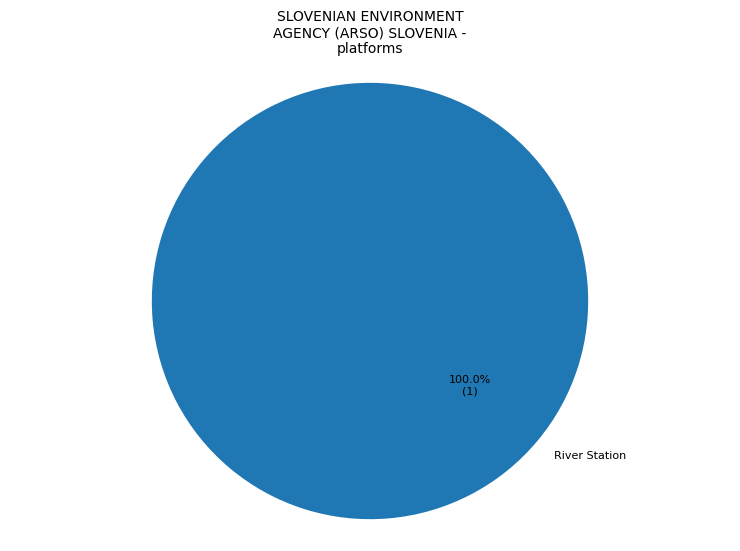

Saved: provider_pies/pie_slovenian-environment-agency-arso-slovenia.png


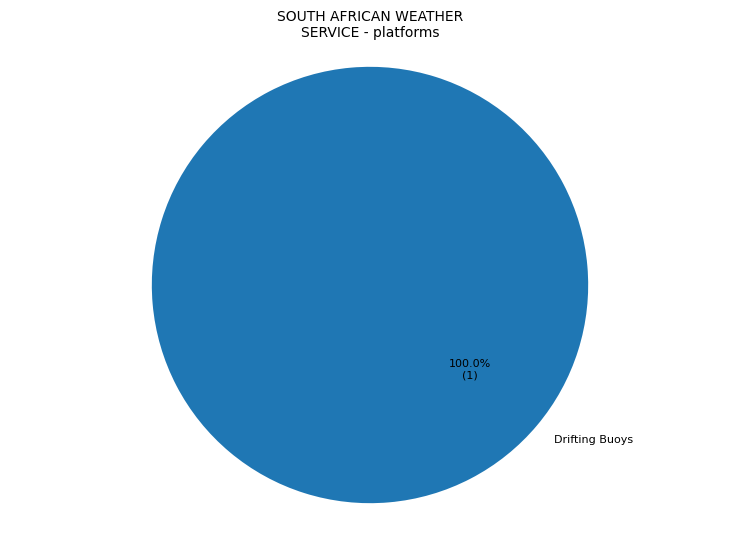

Saved: provider_pies/pie_south-african-weather-service.png


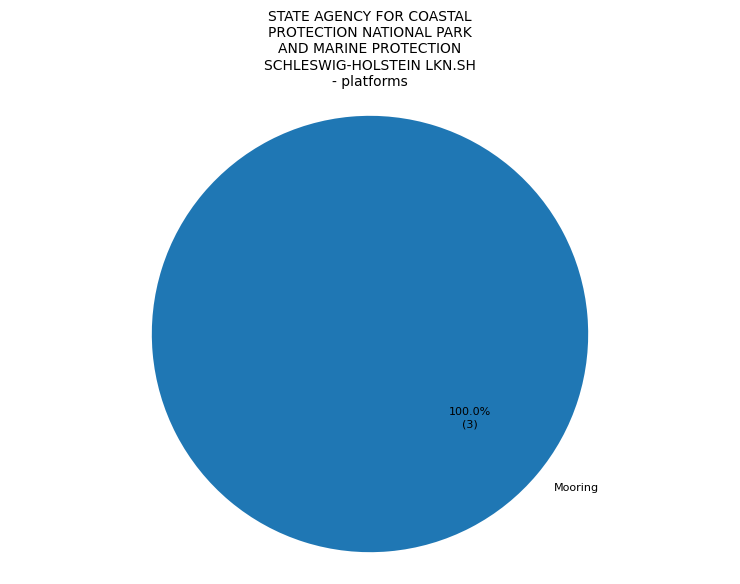

Saved: provider_pies/pie_state-agency-for-coastal-protection-national-park-and-marine-protection-schleswig-holstein-lkn-sh.png


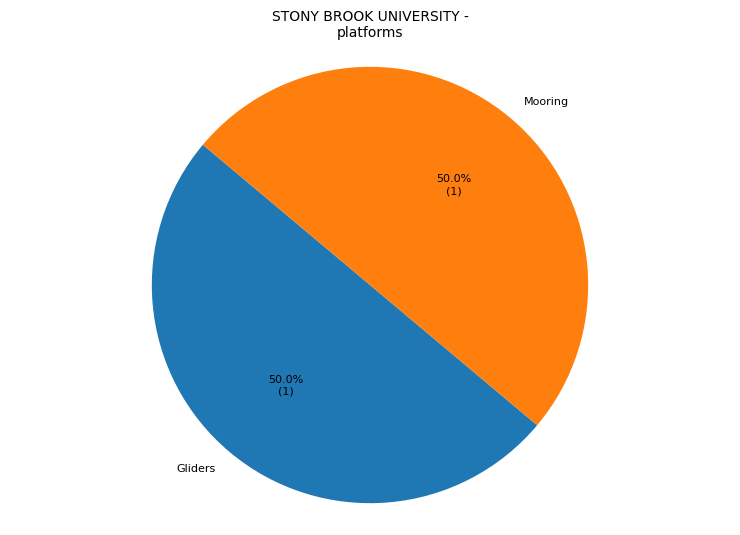

Saved: provider_pies/pie_stony-brook-university.png


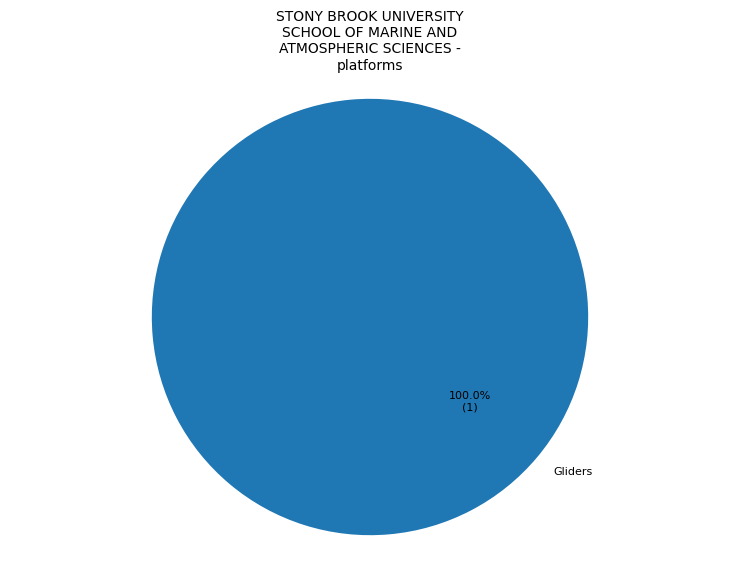

Saved: provider_pies/pie_stony-brook-university-school-of-marine-and-atmospheric-sciences.png


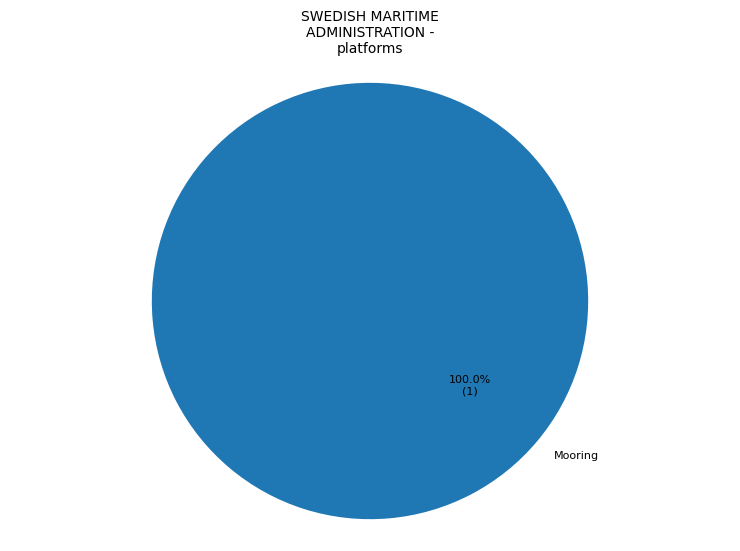

Saved: provider_pies/pie_swedish-maritime-administration.png


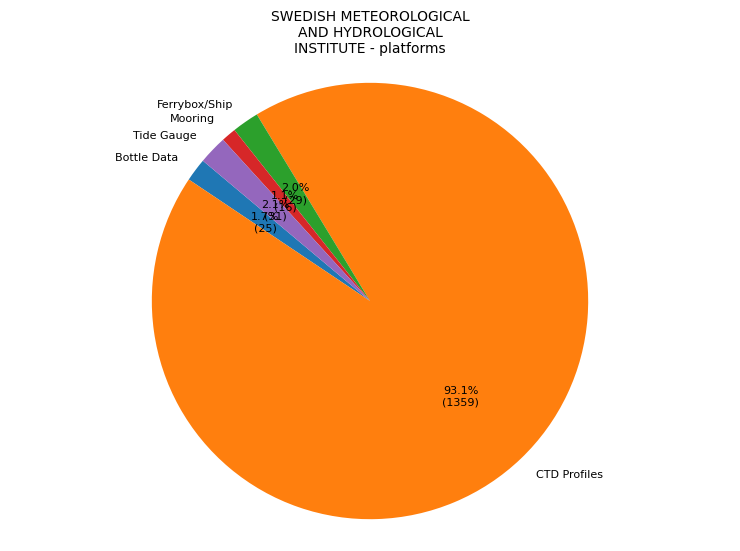

Saved: provider_pies/pie_swedish-meteorological-and-hydrological-institute.png


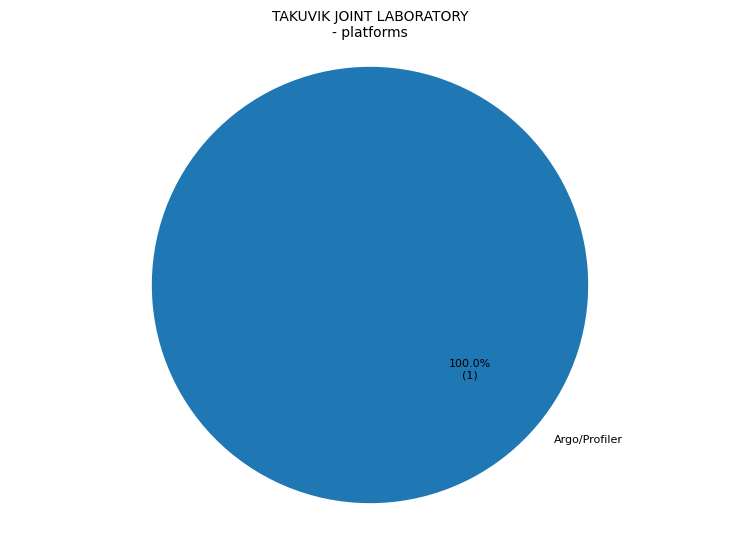

Saved: provider_pies/pie_takuvik-joint-laboratory.png


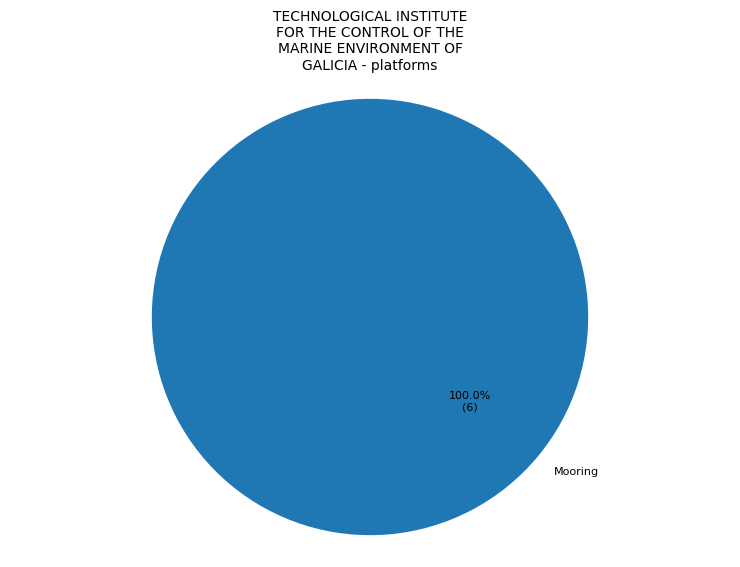

Saved: provider_pies/pie_technological-institute-for-the-control-of-the-marine-environment-of-galicia.png


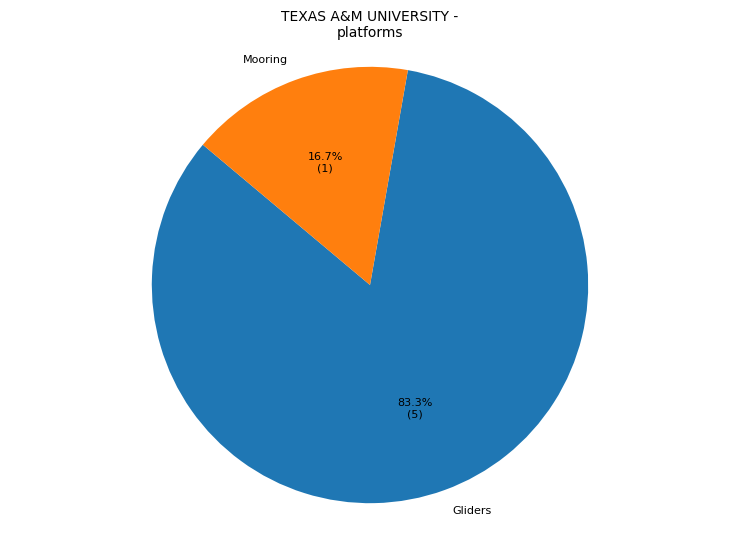

Saved: provider_pies/pie_texas-a-m-university.png


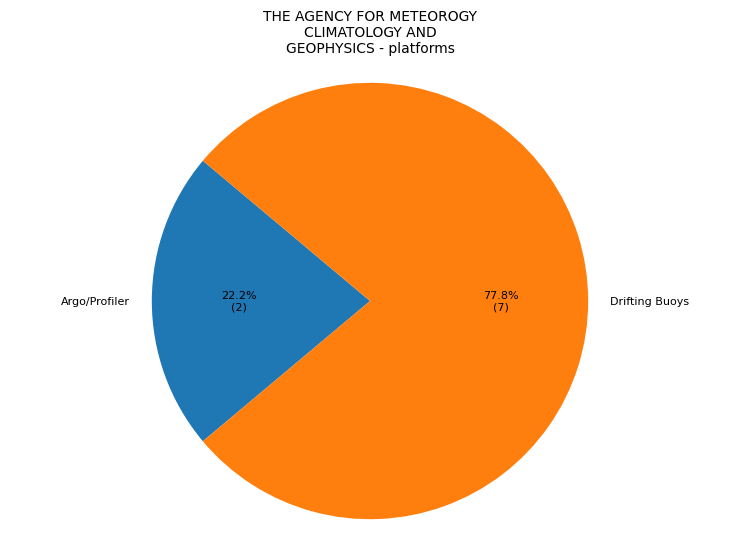

Saved: provider_pies/pie_the-agency-for-meteorogy-climatology-and-geophysics.png


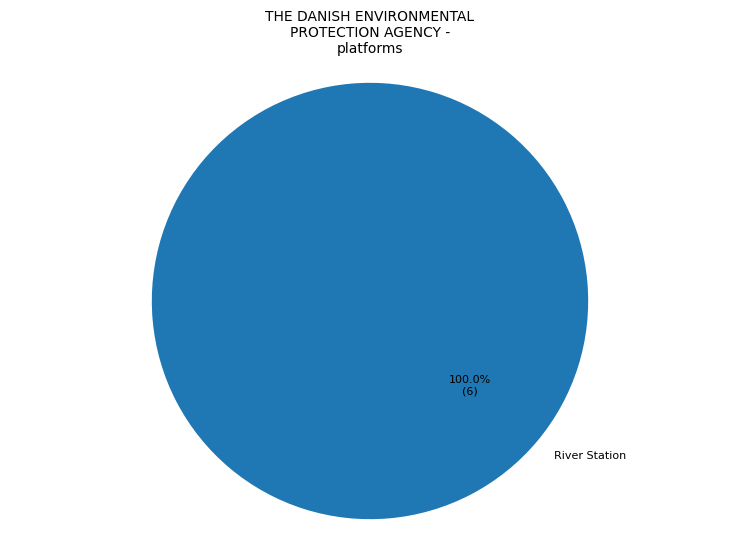

Saved: provider_pies/pie_the-danish-environmental-protection-agency.png


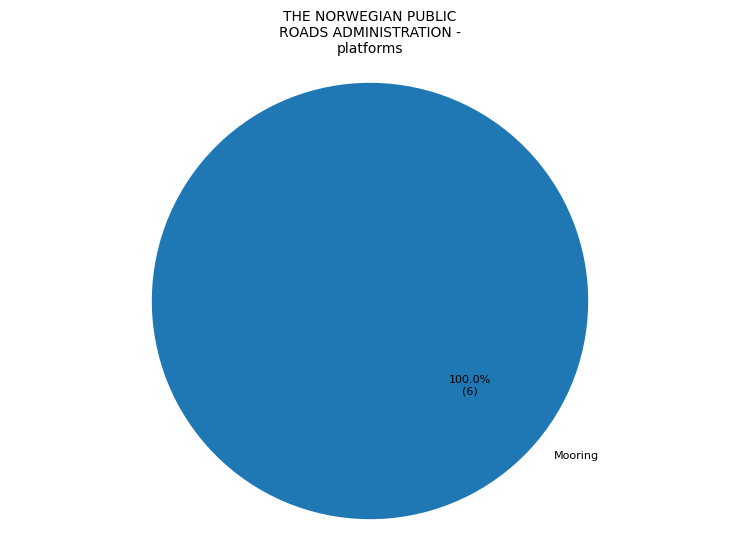

Saved: provider_pies/pie_the-norwegian-public-roads-administration.png


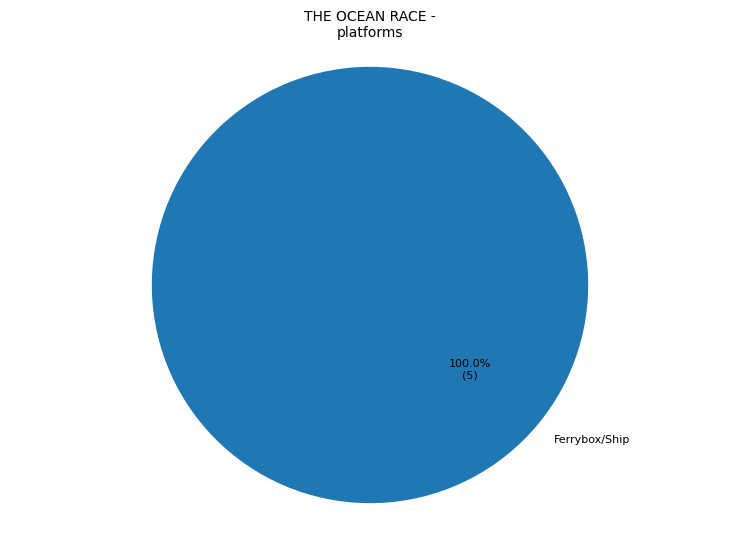

Saved: provider_pies/pie_the-ocean-race.png


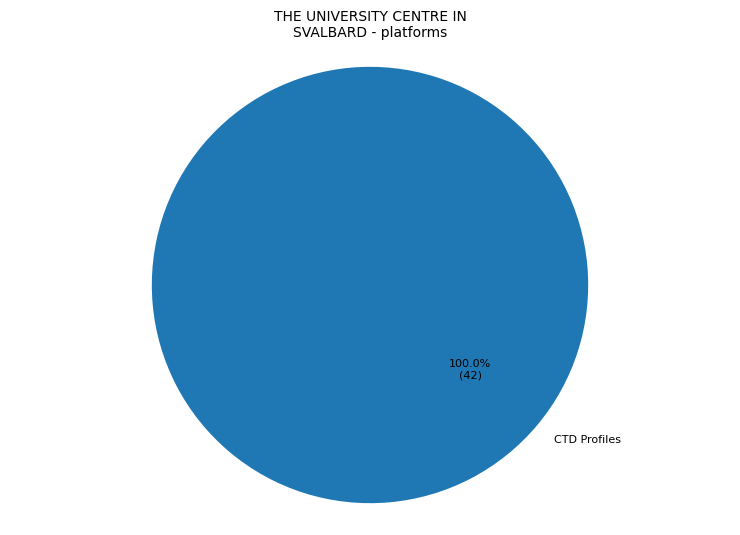

Saved: provider_pies/pie_the-university-centre-in-svalbard.png


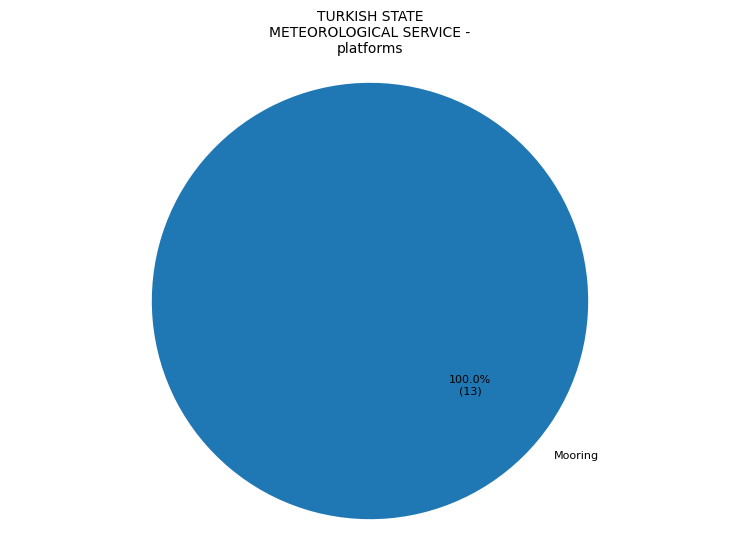

Saved: provider_pies/pie_turkish-state-meteorological-service.png


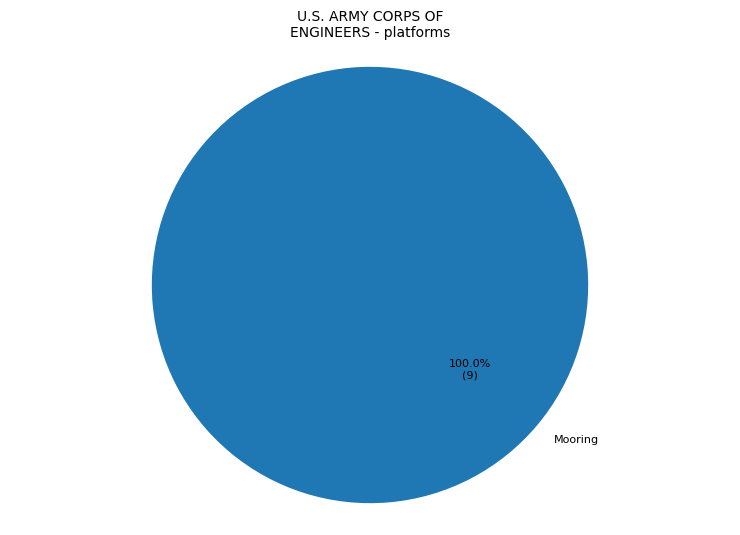

Saved: provider_pies/pie_u-s-army-corps-of-engineers.png


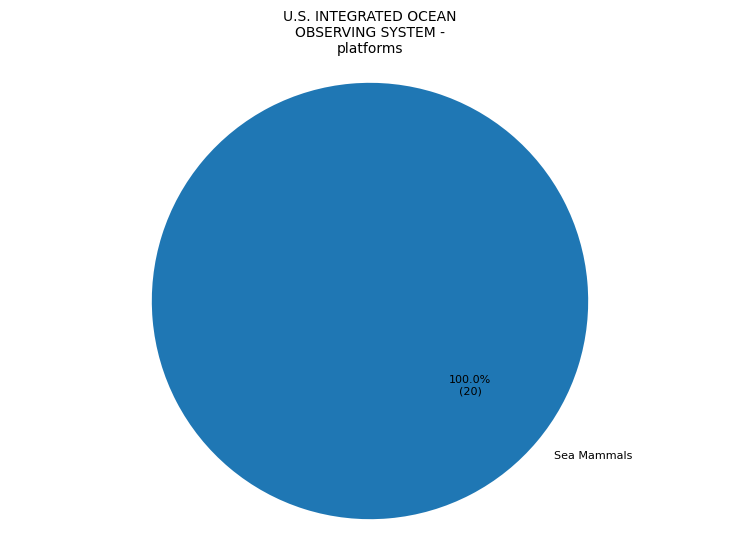

Saved: provider_pies/pie_u-s-integrated-ocean-observing-system.png


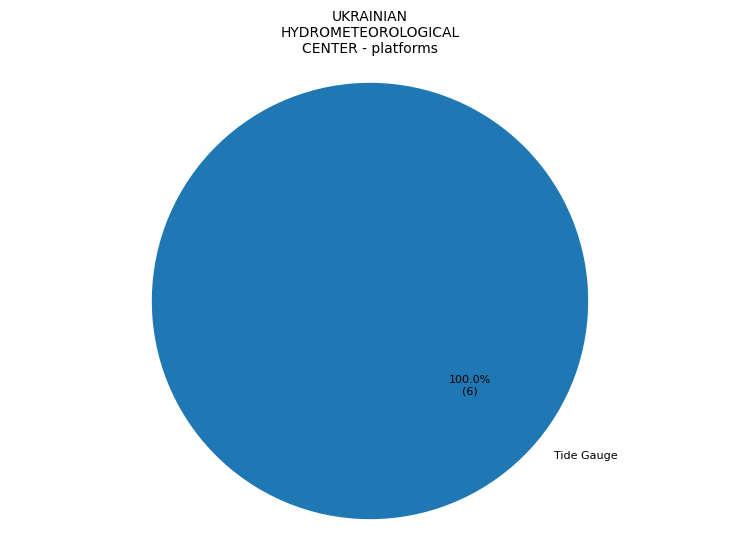

Saved: provider_pies/pie_ukrainian-hydrometeorological-center.png


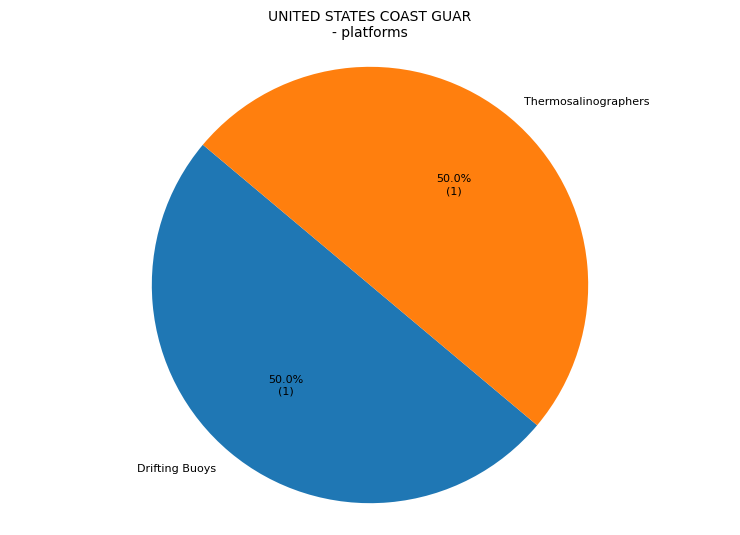

Saved: provider_pies/pie_united-states-coast-guar.png


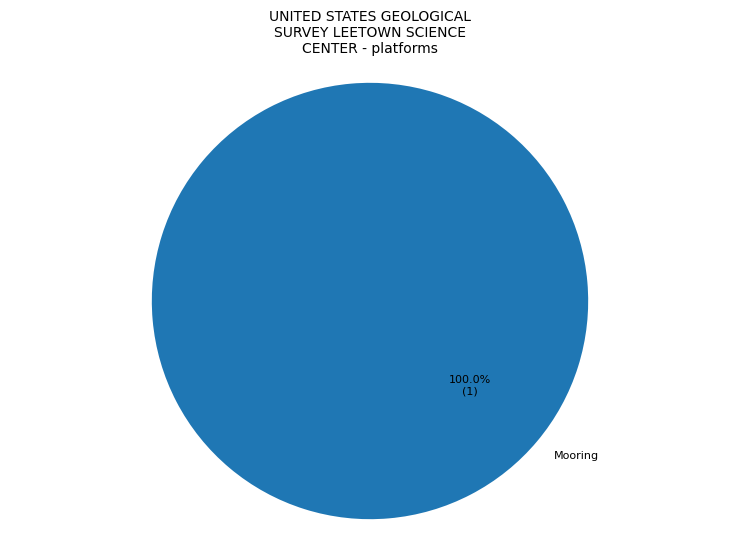

Saved: provider_pies/pie_united-states-geological-survey-leetown-science-center.png


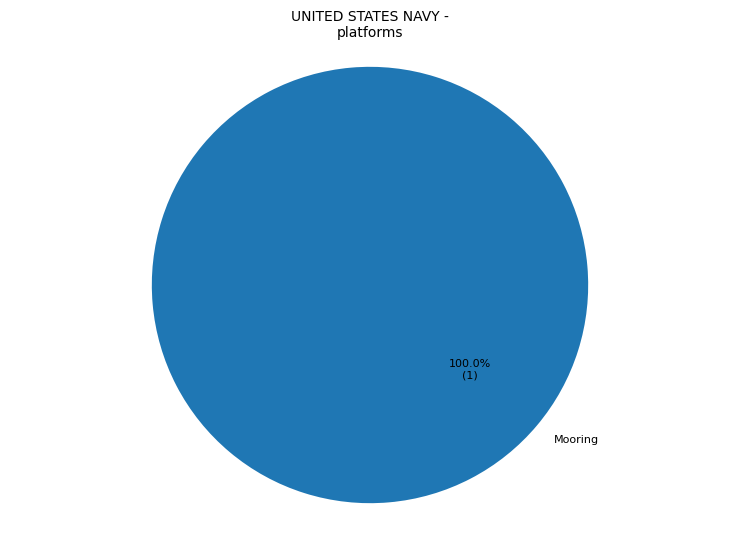

Saved: provider_pies/pie_united-states-navy.png


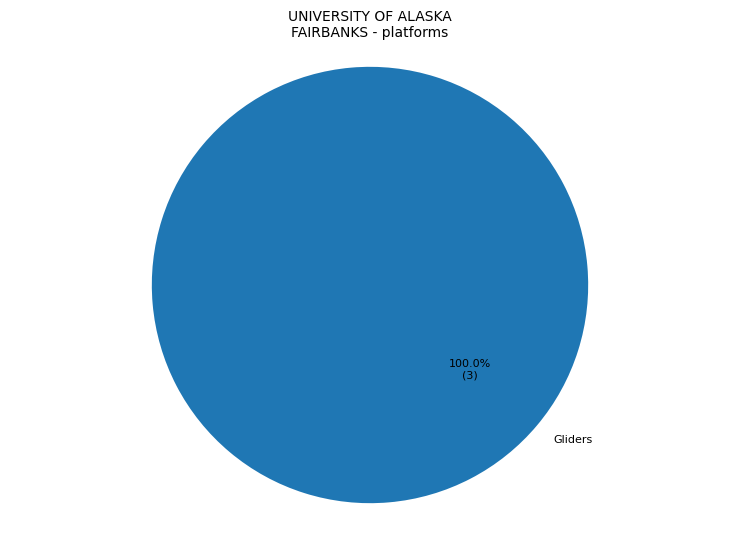

Saved: provider_pies/pie_university-of-alaska-fairbanks.png


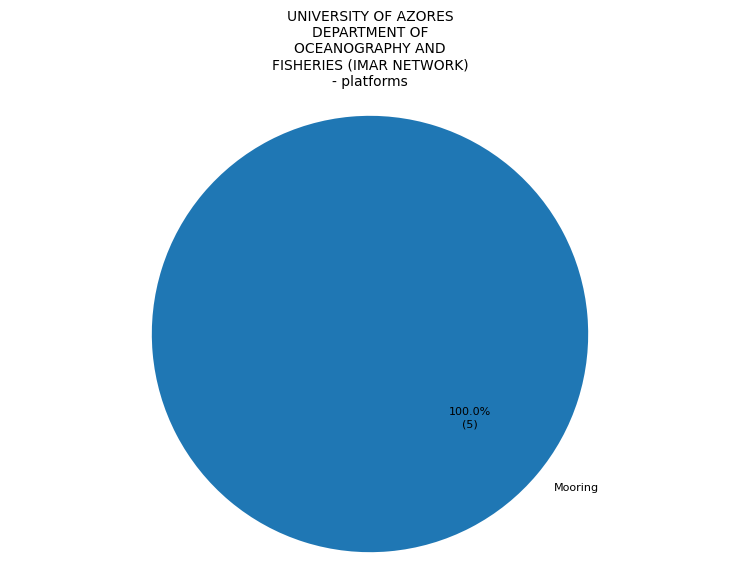

Saved: provider_pies/pie_university-of-azores-department-of-oceanography-and-fisheries-imar-network.png


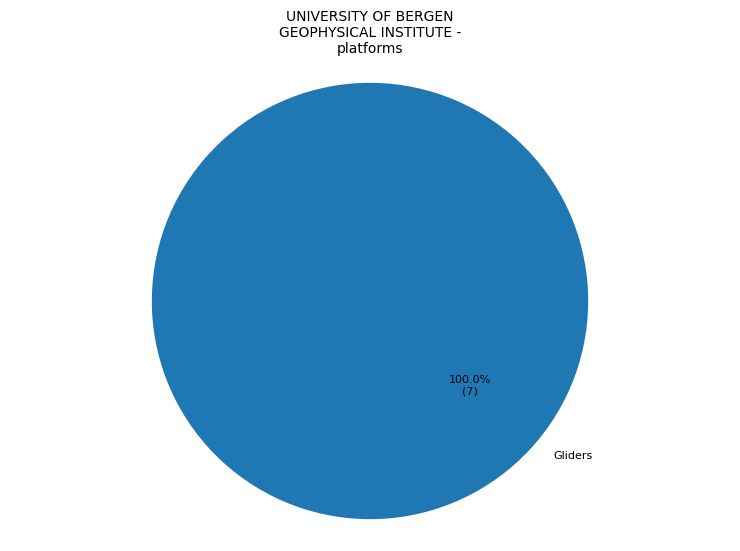

Saved: provider_pies/pie_university-of-bergen-geophysical-institute.png


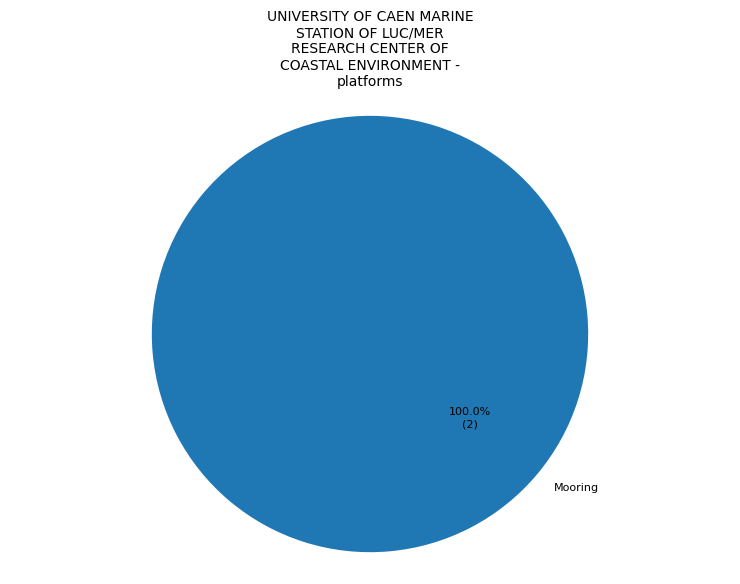

Saved: provider_pies/pie_university-of-caen-marine-station-of-luc-mer-research-center-of-coastal-environment.png


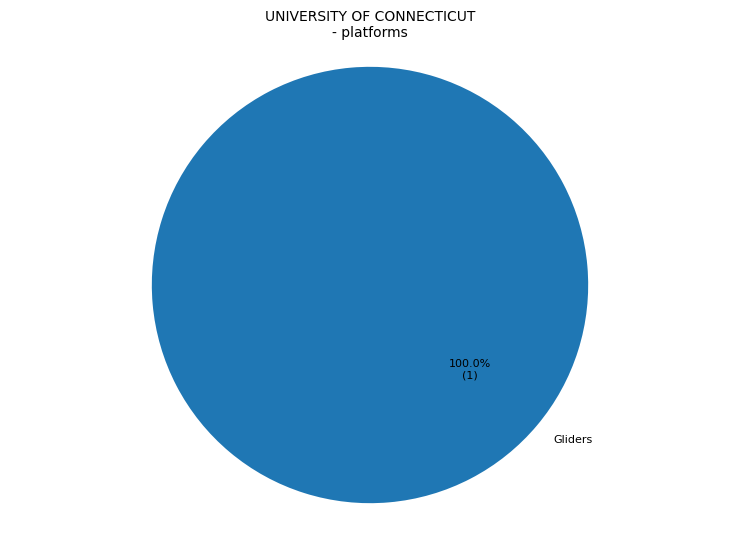

Saved: provider_pies/pie_university-of-connecticut.png


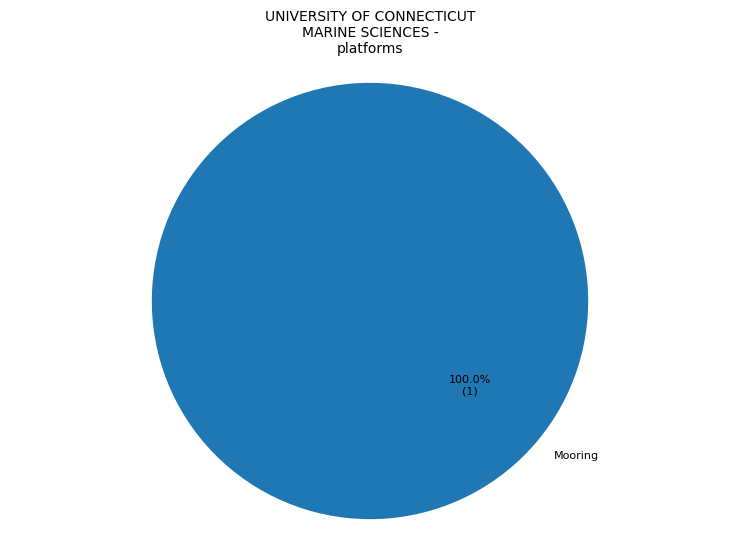

Saved: provider_pies/pie_university-of-connecticut-marine-sciences.png


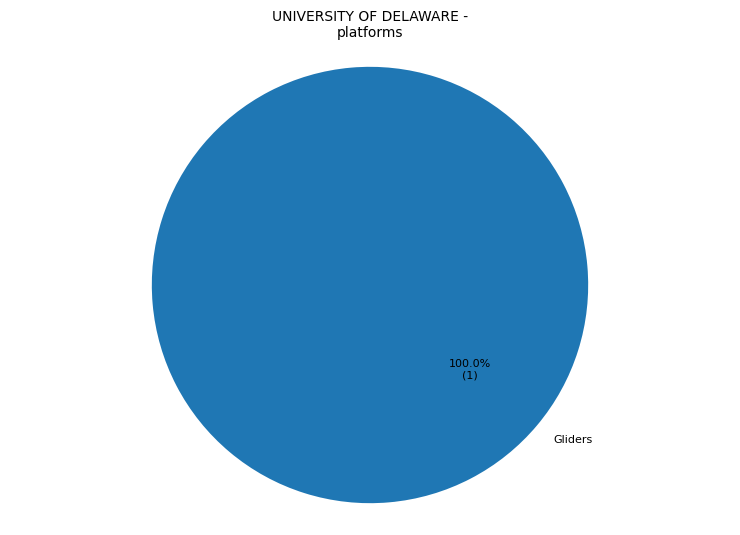

Saved: provider_pies/pie_university-of-delaware.png


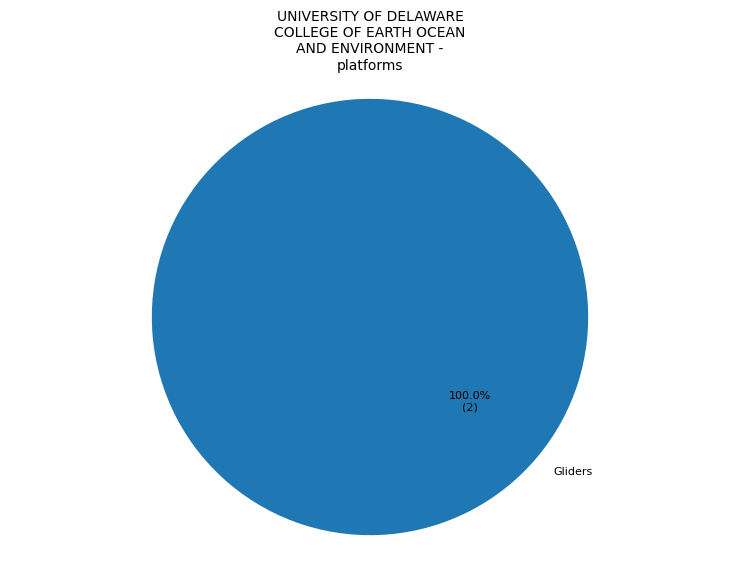

Saved: provider_pies/pie_university-of-delaware-college-of-earth-ocean-and-environment.png


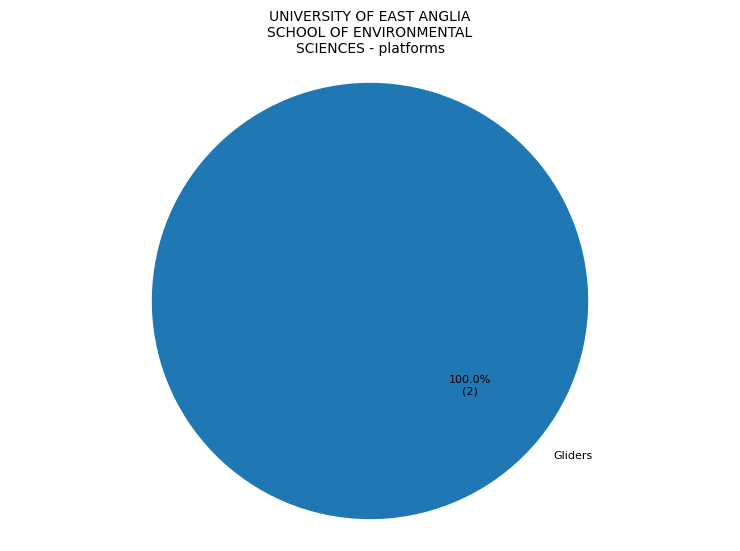

Saved: provider_pies/pie_university-of-east-anglia-school-of-environmental-sciences.png


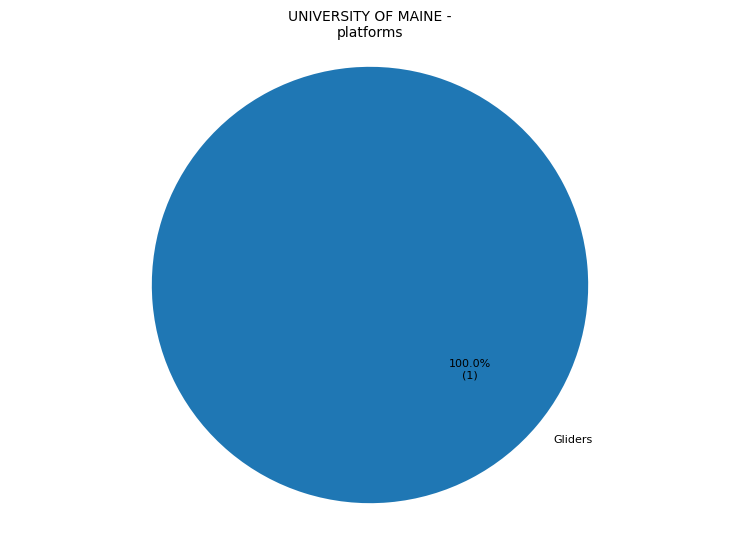

Saved: provider_pies/pie_university-of-maine.png


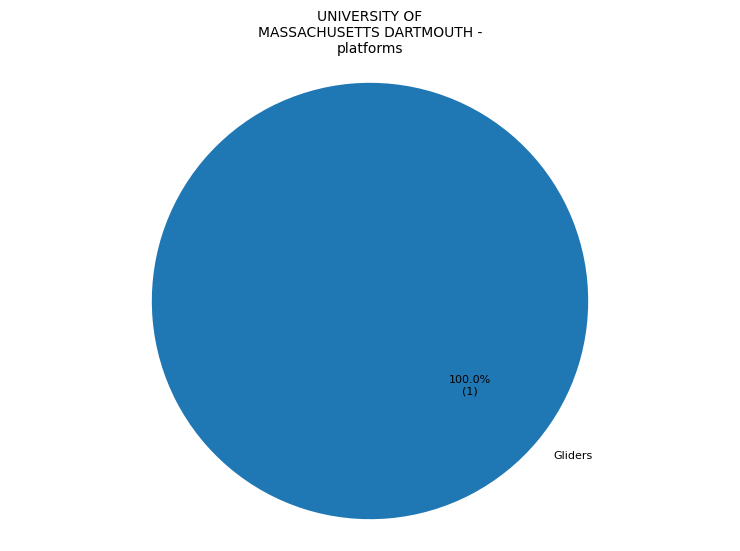

Saved: provider_pies/pie_university-of-massachusetts-dartmouth.png


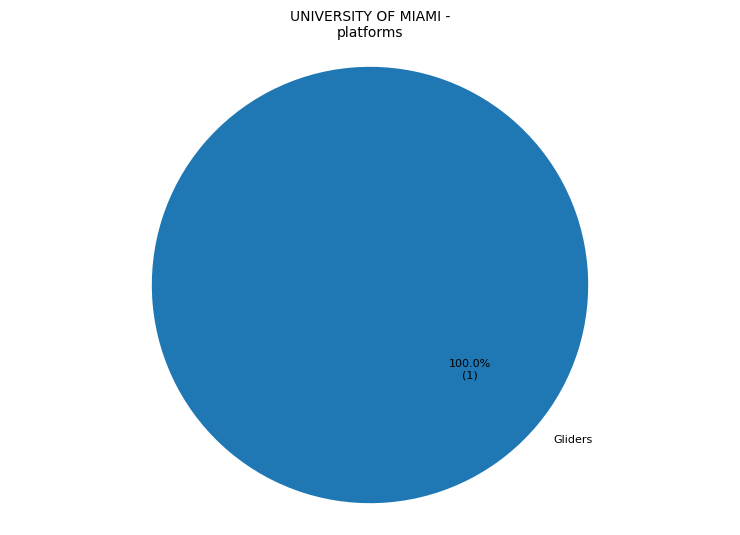

Saved: provider_pies/pie_university-of-miami.png


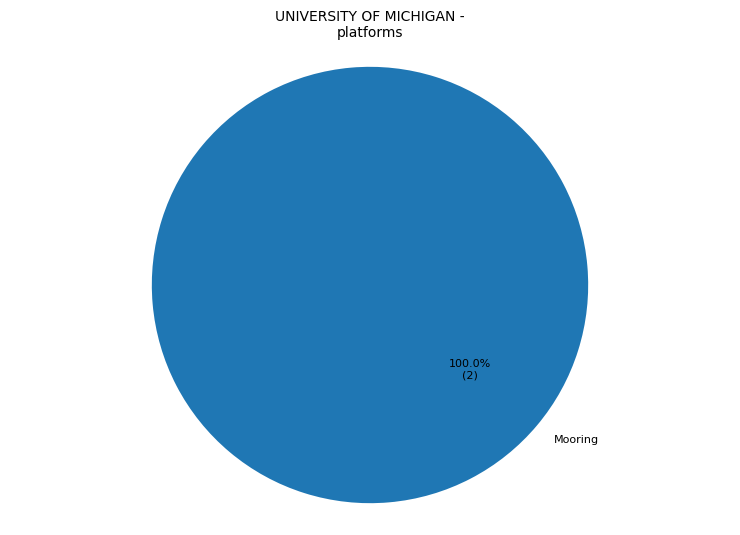

Saved: provider_pies/pie_university-of-michigan.png


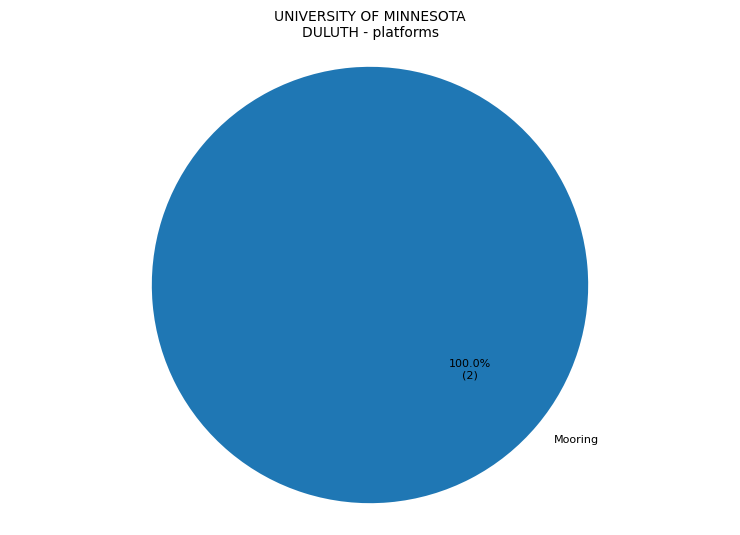

Saved: provider_pies/pie_university-of-minnesota-duluth.png


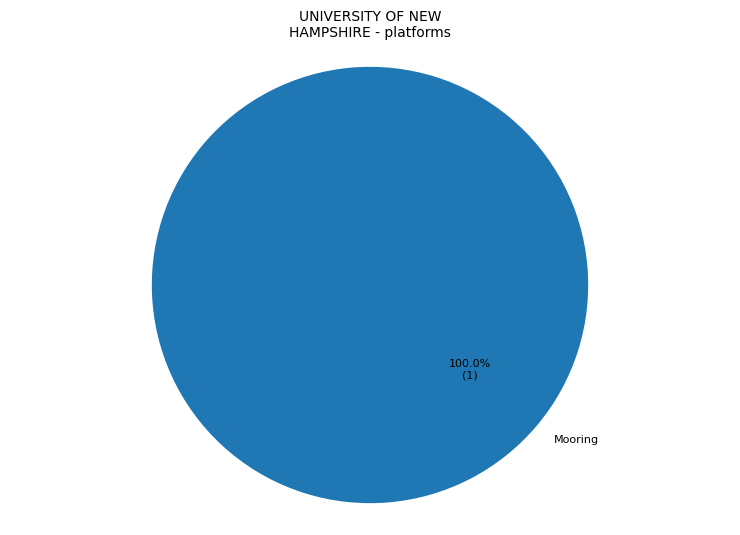

Saved: provider_pies/pie_university-of-new-hampshire.png


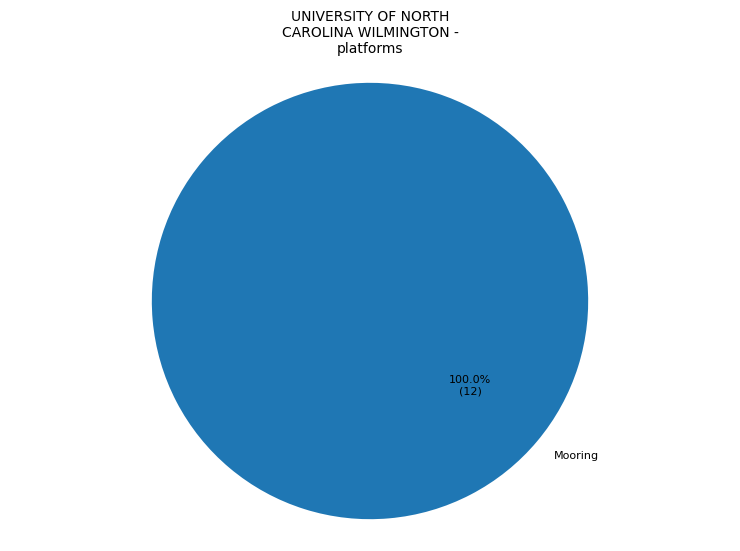

Saved: provider_pies/pie_university-of-north-carolina-wilmington.png


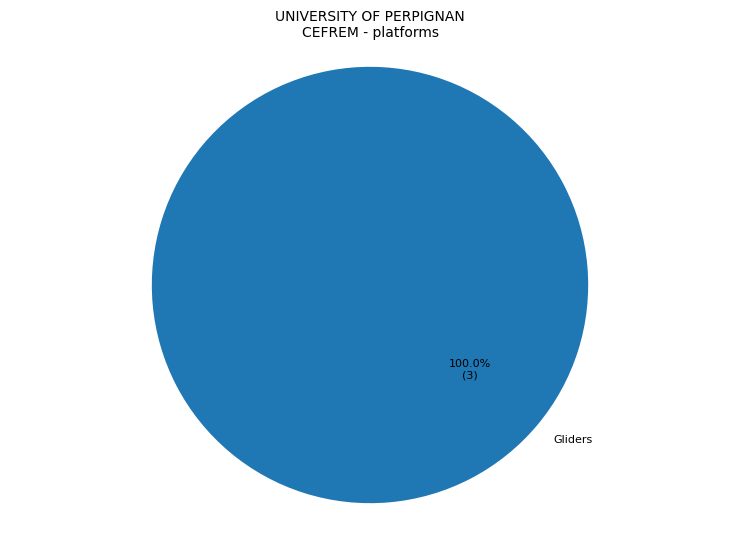

Saved: provider_pies/pie_university-of-perpignan-cefrem.png


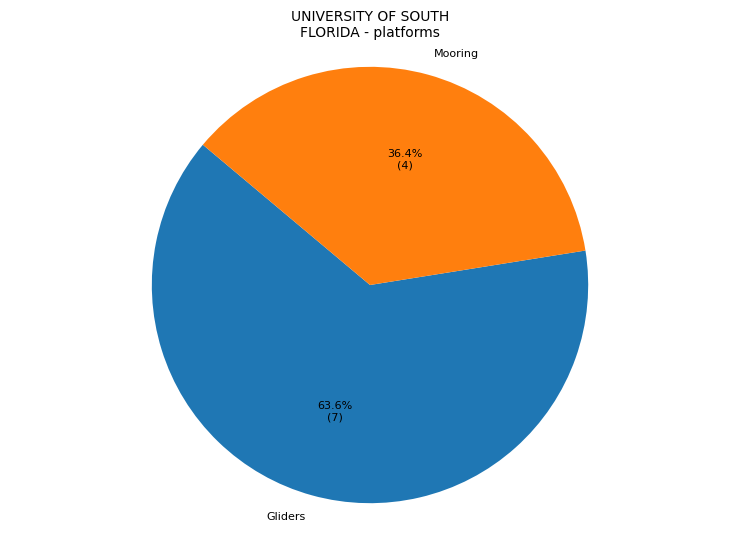

Saved: provider_pies/pie_university-of-south-florida.png


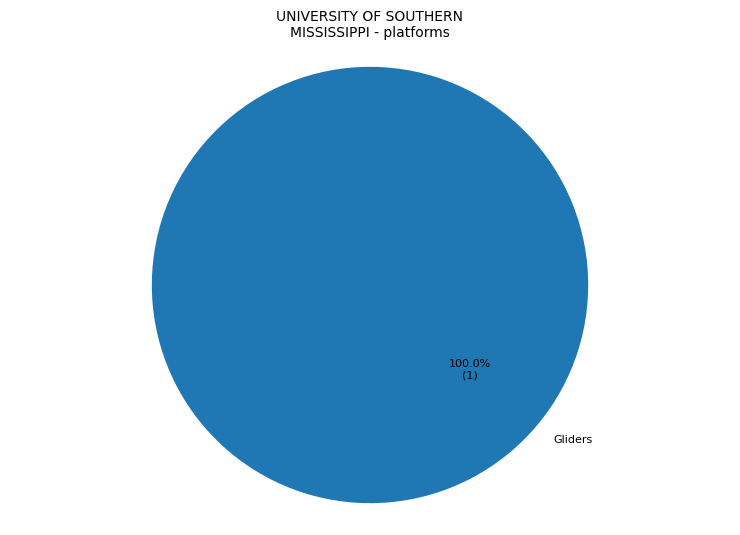

Saved: provider_pies/pie_university-of-southern-mississippi.png


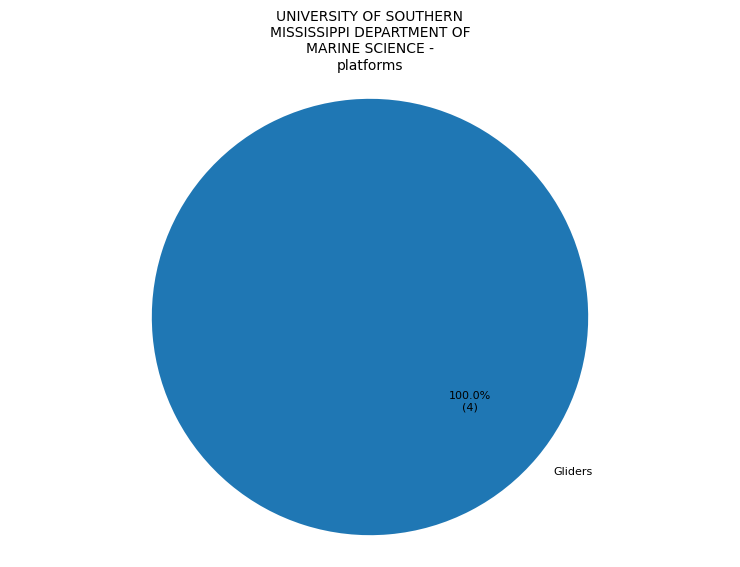

Saved: provider_pies/pie_university-of-southern-mississippi-department-of-marine-science.png


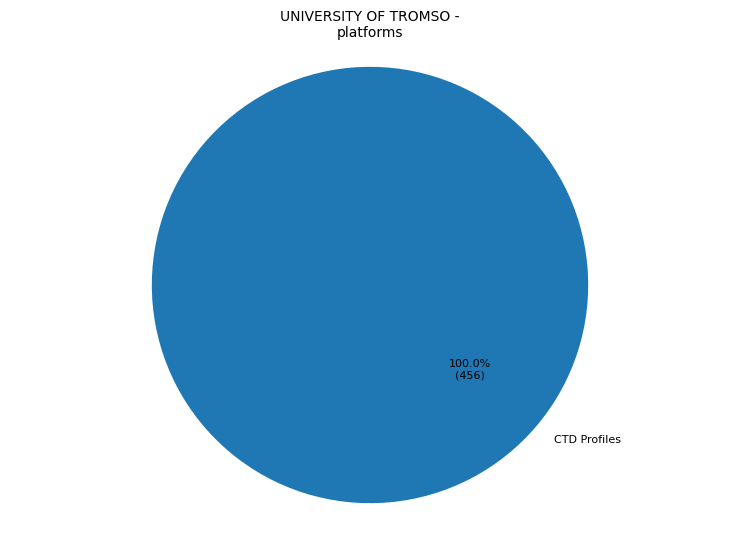

Saved: provider_pies/pie_university-of-tromso.png


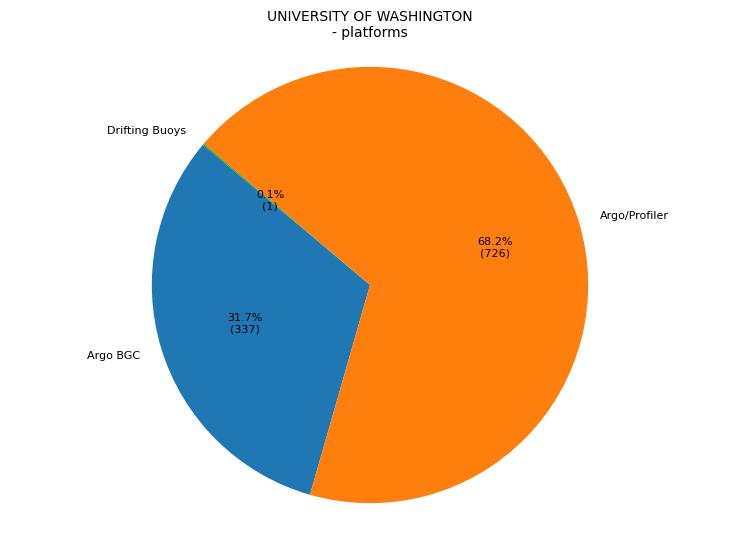

Saved: provider_pies/pie_university-of-washington.png


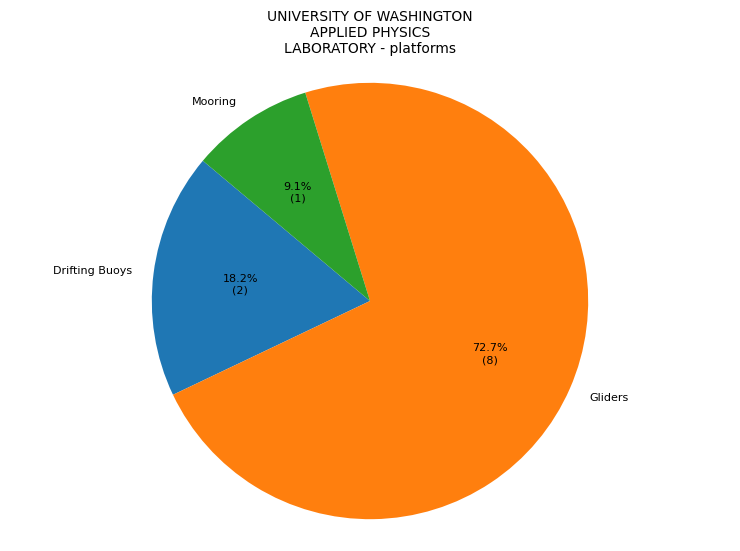

Saved: provider_pies/pie_university-of-washington-applied-physics-laboratory.png


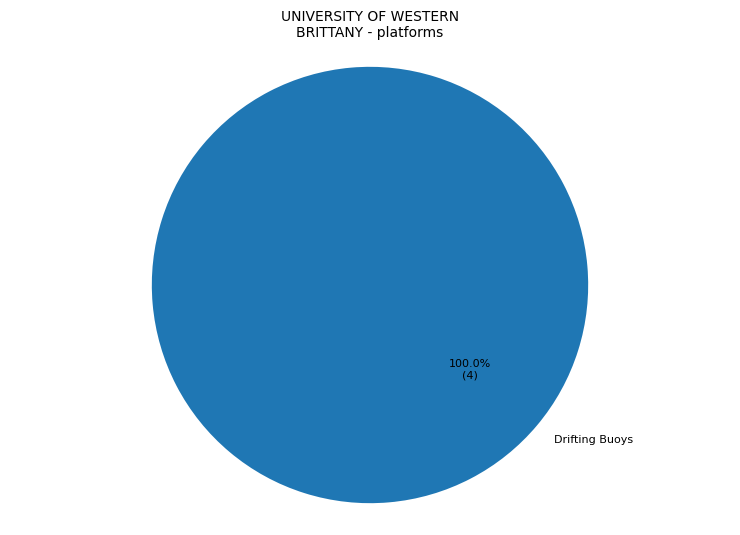

Saved: provider_pies/pie_university-of-western-brittany.png


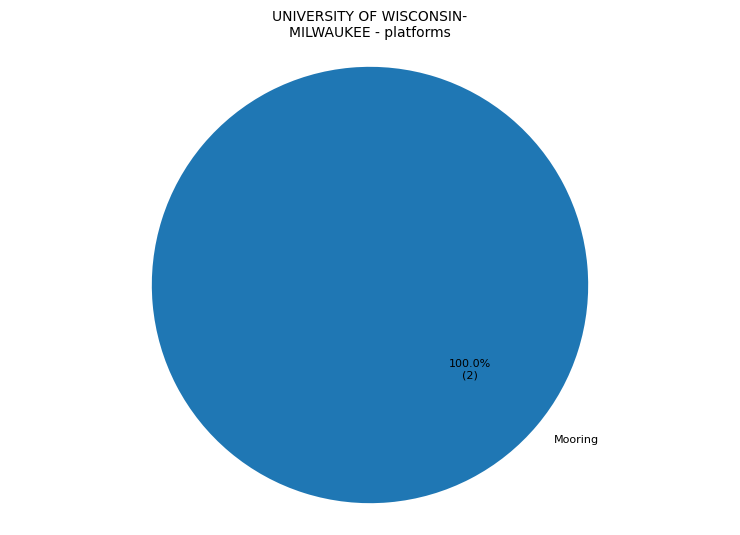

Saved: provider_pies/pie_university-of-wisconsin-milwaukee.png


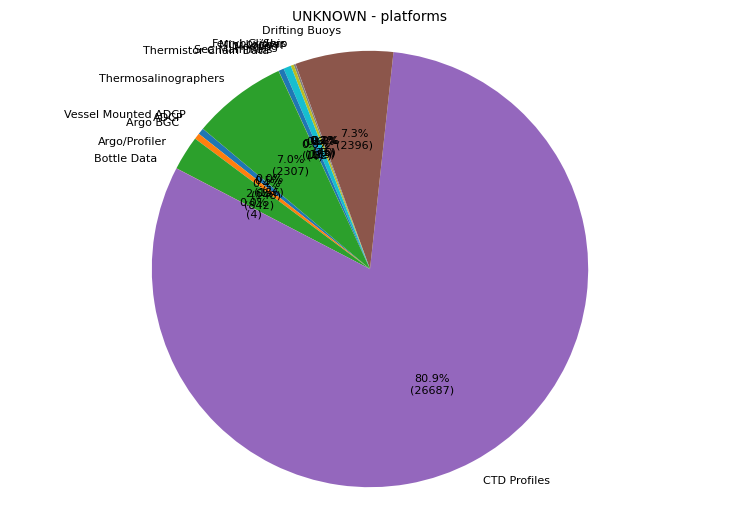

Saved: provider_pies/pie_unknown.png


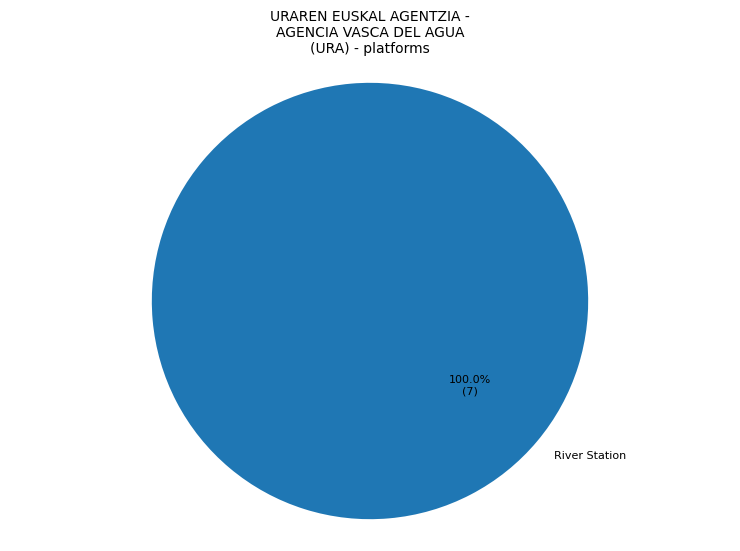

Saved: provider_pies/pie_uraren-euskal-agentzia-agencia-vasca-del-agua-ura.png


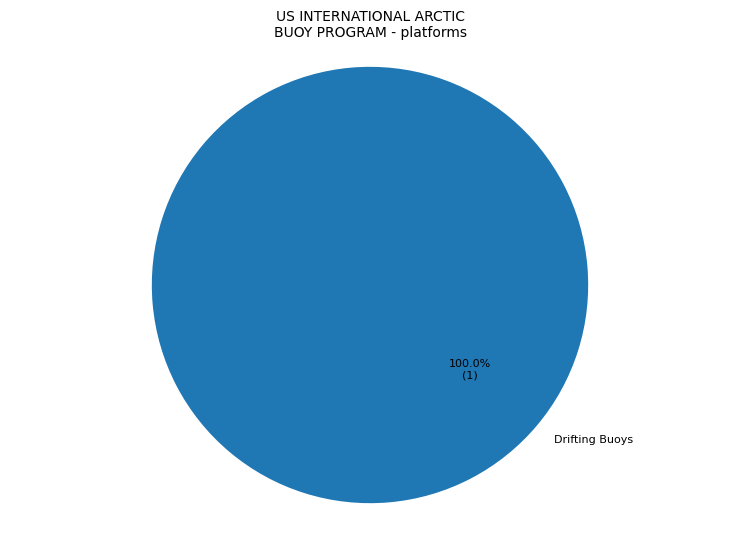

Saved: provider_pies/pie_us-international-arctic-buoy-program.png


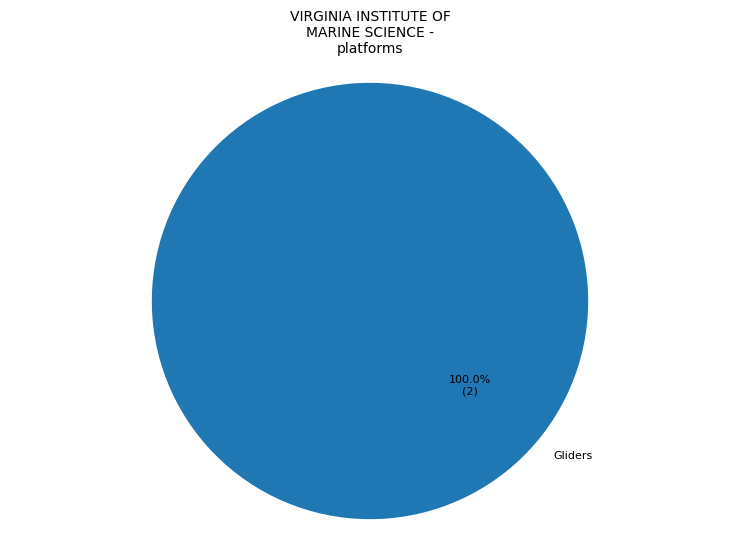

Saved: provider_pies/pie_virginia-institute-of-marine-science.png


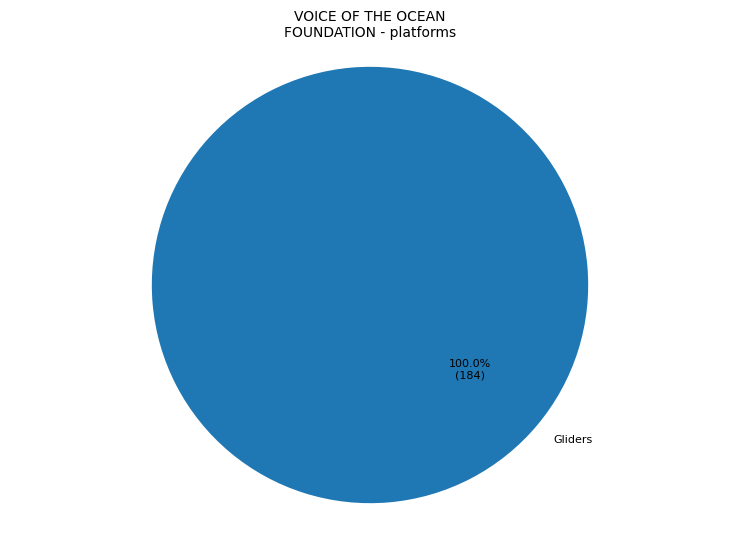

Saved: provider_pies/pie_voice-of-the-ocean-foundation.png


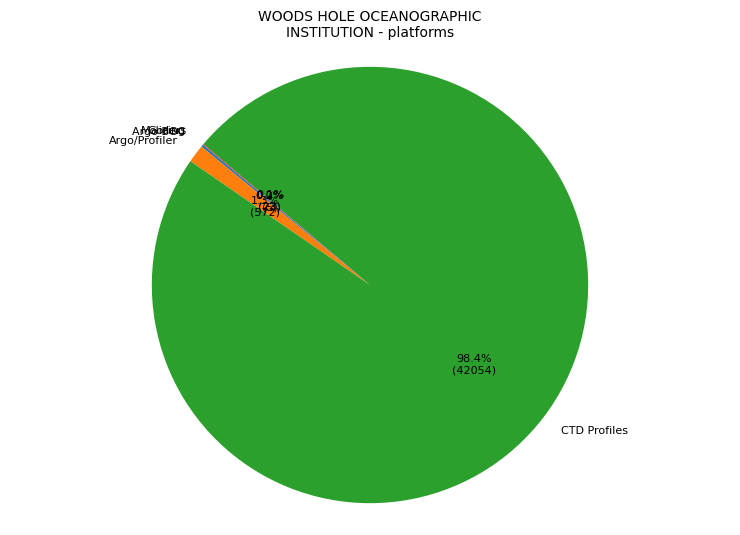

Saved: provider_pies/pie_woods-hole-oceanographic-institution.png


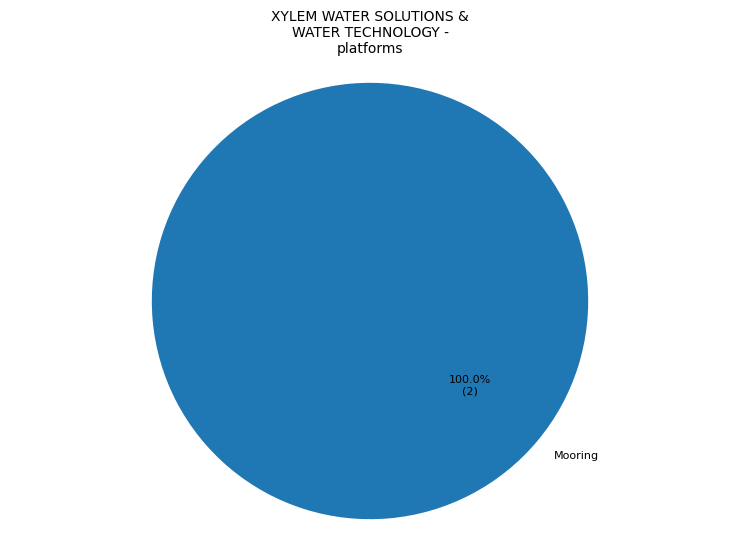

Saved: provider_pies/pie_xylem-water-solutions-water-technology.png


In [ ]:
# Generate PNGs
styles = getSampleStyleSheet()
created_pngs = []

for owner, row in pivot_table.iterrows():
    counts = row[row > 0]
    if counts.empty:
        continue

    owner_slug = slugify(owner)
    png_path = os.path.join(out_dir, f"pie_{owner_slug}.png")

    labels = list(counts.index.astype(str))
    values = list(counts.values)

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_position([0.1, 0.1, 0.8, 0.8])

    def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          count = int(round(pct * total / 100.0))
          return f"{pct:.1f}%\n({count})"
      return my_autopct

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,
        autopct=make_autopct(values),  # <-- qui la modifica
        startangle=140
    )

    ax.axis('equal')

    title = f"{owner} - platforms"
    wrapped_title = "\n".join(textwrap.wrap(title, width=25))
    ax.set_title(wrapped_title, fontsize=10)

    for t in texts + autotexts:
        t.set_fontsize(8)

    plt.show()
    fig.savefig(png_path, dpi=200, bbox_inches=None)
    plt.close(fig)
    created_pngs.append(png_path)
    print(f"Saved: {png_path}")

In [ ]:
# Group by 'dataownername' and select the required columns
platform_details_by_owner = data_df[
    [
        'dataownername',
        'dataownercountryname',
        'platformtypedescription',
        'PLATFORMCODE',
        'call_name',
        'latitude',
        'longitude',
        'datafeaturetype',
        'firstdateobservation',
        'lastdateobservation',
        'creationdate'
    ]
]

platform_details_by_owner = platform_details_by_owner.sort_values(
    by=['dataownercountryname', 'platformtypedescription', 'dataownername']
)

platform_details_by_owner.head(50)


dataownername dataownercountryname  \
119    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
4280   COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
6988   COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
7956   COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
8267   COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
9768   COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
10809  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
12456  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
12905  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
13205  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
13681  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
13863  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14179  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14539  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14569  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14638  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14639  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
14956  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
15894  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
15908  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
16930  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
17197  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
17201  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
18476  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
20027  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
27522  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
27787  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
27921  COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
42     COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
50     COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
60     COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
104    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
145    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
150    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
243    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
290    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
323    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
344    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
360    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
363    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
392    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
402    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
403    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
467    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
615    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
620    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
681    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
706    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRALIA   
712    COMMONWEALTH SCIENTIFIC AND INDUSTRIAL RESEARC...            AUSTRA

In [ ]:
## PDF with all pie charts

# PDF per provider
SAVE_PER_PROVIDER = False
if SAVE_PER_PROVIDER:
    pdf_path = os.path.join(out_dir, f"provider_{owner_slug}.pdf")
    doc = SimpleDocTemplate(pdf_path, pagesize=A4)
    elements = []
    elements.append(Paragraph(f"{owner} - In Situ Platforms", styles['Title']))
    elements.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), styles['Normal']))
    elements.append(Spacer(1, 0.5*cm))

    max_w, max_h = (A4[0] - 2*cm), (A4[1] - 4*cm)
    with PILImage.open(png_path) as im:
        w, h = im.size
    aspect = w / h
    if w >= h:
        draw_w = min(max_w, w)
        draw_h = draw_w / aspect
        if draw_h > max_h:
            draw_h = max_h
            draw_w = draw_h * aspect
    else:
        draw_h = min(max_h, h)
        draw_w = draw_h * aspect
        if draw_w > max_w:
            draw_w = max_w
            draw_h = draw_w / aspect

    elements.append(RLImage(png_path, width=draw_w, height=draw_h))
    doc.build(elements)
    print(f"PDF created: {pdf_path}")

# Cumulative PDF with all pie charts
if created_pngs:
    all_pdf = "all_owners_pie_charts.pdf"
    doc = SimpleDocTemplate(all_pdf, pagesize=A4)
    elements = []
    elements.append(Paragraph("All providers - In Situ Platforms", styles['Title']))
    elements.append(Paragraph(datetime.now().strftime("%Y-%m-%d %H:%M"), styles['Normal']))
    elements.append(Spacer(1, 0.5*cm))

    for i, png in enumerate(sorted(created_pngs), 1):
        base = os.path.basename(png)
        owner_slug = base.replace("pie_", "").replace(".png", "")
        elements.append(Paragraph(owner_slug, styles['Heading3']))

        max_w, max_h = (A4[0] - 2*cm), (A4[1] - 4*cm)
        with PILImage.open(png) as im:
            w, h = im.size
        aspect = w / h
        if w >= h:
            draw_w = min(max_w, w)
            draw_h = draw_w / aspect
            if draw_h > max_h:
                draw_h = max_h
                draw_w = draw_h * aspect
        else:
            draw_h = min(max_h, h)
            draw_w = draw_h * aspect
            if draw_w > max_w:
                draw_w = max_w
                draw_h = draw_w / aspect

        elements.append(RLImage(png, width=draw_w, height=draw_h))
        if i != len(created_pngs):
            elements.append(PageBreak())

    doc.build(elements)
    print(f"Cumulative PDF created: {all_pdf}")
else:
    print("No charts created: pivot_table empty or all zero.")

Cumulative PDF created: all_owners_pie_charts.pdf
